## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [1]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [3]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [4]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

⚠️  Trí nhớ trống, không có gì để xây dựng vector store.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [5]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [6]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [7]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [8]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH, PERSONA & CÁC CẤU TRÚC DỮ LIỆU (NÂNG CẤP V9.0)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- HÀM TIỆN ÍCH & PERSONA (giữ nguyên) ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === NÂNG CẤP V9.0: PYDANTIC MODELS MỚI CHO TƯ DUY SÂU ===

class DifferentiatedInstructionModel(BaseModel):
    """Gợi ý cụ thể cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str = Field(description="Một gợi ý hoạt động, câu hỏi, hoặc sự hỗ trợ cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Một câu hỏi mở rộng, một thử thách, hoặc một hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập. Ví dụ: 'Thảo luận nhóm về ứng dụng của Tích phân'")
    description: str = Field(description="Mô tả chi tiết các bước HỌC SINH cần làm.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở cụ thể cho học sinh.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá. Ví dụ: 'Thử thách cuối bài'")
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán cụ thể.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này, ví dụ một câu hỏi phụ khó hơn.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    """Mở rộng StudentPersona để bao gồm cả chiến lược phân hóa tổng thể."""
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

# --- Các model khác giữ nguyên ---
class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]

class BlueprintStage(BaseModel):
    stage_name: str = Field(description="Tên của giai đoạn.")
    stage_objective: str = Field(description="Mô tả mục tiêu của giai đoạn này.")
    stage_direction: str = Field(description="Định hướng chung về hoạt động trong giai đoạn này.")

class PedagogicalBlueprint(BaseModel):
    blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.


In [9]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [10]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [11]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [12]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ CÁC AGENT CHUYÊN MÔN (NÂNG CẤP V9.0)
# ==============================================================================
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    reflection_notes = state.get('reflection_notes') # Lấy phản hồi từ lần trước (nếu có)

    # Xây dựng prompt động
    replan_prompt_part = ""
    if reflection_notes:
        print_warning(f"Nhận được yêu cầu làm lại kế hoạch từ Critic: {reflection_notes}")
        replan_prompt_part = f"""
        **PHẢN HỒI QUAN TRỌNG TỪ LẦN LẬP KẾ HOẠCH TRƯỚC (CẦN KHẮC PHỤC):**
        "{reflection_notes}"
        Dựa trên phản hồi này, hãy điều chỉnh lại danh sách nhiệm vụ của bạn. Có thể bạn cần tạo nhiều hoạt động hơn, hoặc phân bổ lại thời gian một cách hợp lý hơn.
        """

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
        **VAI TRÒ:** Bạn là một **Trợ lý Sư phạm**, chuyên viên thực thi và điều chỉnh kế hoạch.
        **NHIỆM VỤ:** Dựa vào **Bản thiết kế Sư phạm**, hãy **chuyển đổi** nó thành một danh sách các **NHIỆM VỤ HỌC TẬP CỤ THỂ** về chủ đề "{topic}".

        {replan_prompt_part}

        **QUY TẮC TUYỆT ĐỐI:**
        1.  **BÁM SÁT KỊCH BẢN:** Mỗi giai đoạn trong bản thiết kế PHẢI được chuyển đổi thành ít nhất MỘT nhiệm vụ học tập tương ứng.
        2.  **LẮNG NGHE PHẢN HỒI (NẾU CÓ):** Nếu `PHẢN HỒI QUAN TRỌNG` có chứa `SUGGESTED_DURATION: [số phút]`, BẠN BẮT BUỘC phải sử dụng con số đó để điều chỉnh thời gian cho nhiệm vụ liên quan và phân bổ lại thời gian của các nhiệm vụ khác cho hợp lý. Đây là ưu tiên cao nhất.
        3.  **HÀNH ĐỘNG CỤ THỂ:** Mô tả hành động học sinh sẽ làm. CẤM các từ ngữ chung chung.
        4.  **PHÂN BỔ THỜI GIAN:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút một cách hợp lý cho tất cả các nhiệm vụ.
        5.  **TỐI ƯU HÓA:** Gộp các nhiệm vụ có mục tiêu quá giống nhau.

        **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN CẦN TUÂN THỦ):**
        {json.dumps(blueprint, ensure_ascii=False, indent=2)}

        **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
        """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        # Xóa các agent_outputs cũ (trừ RAG) để bắt đầu vòng lặp mới
        # Điều này rất quan trọng để tránh các hoạt động cũ bị lẫn vào vòng mới
        agent_outputs_history = state.get("agent_outputs", {})
        new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết (lần chạy lại)")
        
        # Xóa reflection_notes cũ sau khi đã sử dụng
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        # ... (fallback giữ nguyên)
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        topic_fallback = state.get('analyzed_objective', {}).get('topic', state.get('original_request', 'chủ đề đã cho'))
        fallback_task = {
            "task_id": 0, "task_name": f"Hoạt động luyện tập về {topic_fallback}",
            "task_description": f"Học sinh thực hành các bài tập cơ bản liên quan đến chủ đề: {topic_fallback}.",
            "estimated_duration": 45, "status": "pending"
        }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Contextual Critic` (v9.2) đang phản biện nội dung...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        print_warning("Bỏ qua phản biện do lỗi ở bước tạo nội dung.")
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia thẩm định giáo án cực kỳ kinh nghiệm và cẩn thận.
    **NHIỆM VỤ:** Hãy xem xét nội dung được tạo ra cho một hoạt động và đối chiếu nó với yêu cầu ban đầu.
    **YÊU CẦU GỐC CỦA NHIỆM VỤ:**
    - Tên nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Mô tả: "{current_task.get('task_description', 'N/A')}"
    - Thời lượng dự kiến: "{current_task.get('estimated_duration', 'N/A')} phút"

    **NỘI DUNG ĐƯỢC TẠO RA CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```

    **TIÊU CHÍ PHẢN BIỆN (THEO THỨ TỰ ƯU TIÊN):**
    1.  **Lỗi Cấu trúc hoặc Thời gian (Rất quan trọng):** Nội dung được tạo có mâu thuẫn với yêu cầu gốc không? Đặc biệt, thời lượng `duration_minutes` có hợp lý với các bước được mô tả trong `description` không? Nếu có mâu thuẫn lớn (ví dụ: mô tả một hoạt động 20 phút nhưng `duration_minutes` chỉ là 5), đây là LỖI CẤU TRÚC.
    2.  **Tính chính xác chuyên môn:** Nội dung có sai sót về kiến thức không?
    3.  **Tính phù hợp sư phạm:** Nội dung có phù hợp với lứa tuổi và đặc điểm lớp học không?

    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu nội dung hợp lệ, trả về JSON với `is_valid: true` và `feedback` là "Nội dung hợp lệ.".
    - Nếu có lỗi về chuyên môn hoặc sư phạm (lỗi có thể sửa bằng cách viết lại nội dung), trả về `is_valid: false` và `feedback` mô tả lỗi đó.
    - **NẾU CÓ LỖI CẤU TRÚC HOẶC THỜI GIAN**, trả về `is_valid: false` và bắt đầu `feedback` bằng từ khóa **`[STRUCTURAL_FEEDBACK]`**. Ví dụ: `[STRUCTURAL_FEEDBACK] Thời lượng 5 phút là bất khả thi cho hoạt động được mô tả, cần ít nhất 15 phút.`
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
        else:
            # --- LOGIC NÂNG CẤP ---
            # Nếu có đề xuất thời gian, hãy đính kèm nó vào feedback
            final_feedback = result.feedback
            if result.suggested_duration:
                final_feedback += f" | SUGGESTED_DURATION: {result.suggested_duration}"
            
            print_warning(f"PHẢN BIỆN: {final_feedback}")
            return {"validation_feedback": final_feedback, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Content Validator: {e}. Mặc định cho qua.")
    return {"validation_feedback": None, "current_content_to_validate": content}

print("✅ Agent phản biện nội dung 'content_validator_agent' (v9.2 - Hỗ trợ Leo thang) đã được định nghĩa.")


# === NÂNG CẤP: Logic của agent chuyên môn giờ đây phải suy nghĩ về phân hóa ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}, "validation_feedback": None}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    
    # Lấy chiến lược phân hóa tổng thể từ state
    differentiation_strategy = state.get('student_persona', {}).get('differentiation_strategy', {})

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và chu đáo.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT**, có tính đến sự đa dạng của học sinh trong lớp.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung của bài:** {json.dumps(differentiation_strategy, ensure_ascii=False)}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    
    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài toán, các bước thực hành rõ ràng.
    2.  **MÔ TẢ HÀNH ĐỘNG CỦA GIÁO VIÊN:** Liệt kê các hành động cụ thể.
    3.  **SUY NGHĨ VỀ PHÂN HÓA (RẤT QUAN TRỌNG):** Dựa vào "Chiến lược phân hóa chung", hãy tạo ra các gợi ý phân hóa (`differentiation`) **cụ thể cho hoạt động này**. Ví dụ: Nếu chiến lược chung là "cung cấp gợi ý", thì gợi ý cụ thể ở đây là gì?
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (có phân hóa)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}


async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.4 - Hỗ trợ Phân hóa và Lập kế hoạch lại) đã sẵn sàng.")

✅ Agent phản biện nội dung 'content_validator_agent' (v9.2 - Hỗ trợ Leo thang) đã được định nghĩa.
✅ Các agent giao việc và chuyên môn (v9.4 - Hỗ trợ Phân hóa và Lập kế hoạch lại) đã sẵn sàng.


In [13]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP CÓ CẤU TRÚC & NODE TRÌNH BÀY (NÂNG CẤP V9.0)
# ==============================================================================
# Nâng cấp 1: Agent này giờ chỉ tạo đối tượng JSON có cấu trúc
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.0) đang tổng hợp giáo án có cấu trúc...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    # Kiểm tra điều kiện hợp lệ (giữ nguyên)
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    if not all_content_items or not ((allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ hoặc số lượng hoạt động quá ít. Lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án dạng JSON...")
    
    # Tổ chức dữ liệu từ state
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = {
        "chủ đề": objective.get('topic', 'N/A'),
        "môn học": state.get('domain', 'N/A'),
        "lớp": objective.get('grade_level', 'N/A'),
        "thời lượng": f"{allowed_duration} phút",
        "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'),
        "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'),
    }

    learning_objectives = [
        f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.",
        "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.",
        "Phát triển kỹ năng hợp tác và trình bày."
    ]

    preparation = {
        "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập (nếu có trong hoạt động)"],
        "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"]
    }
    
    # Sắp xếp các hoạt động
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Xây dựng đối tượng JSON cuối cùng theo schema FinalStructuredPlan
    final_plan_obj: FinalStructuredPlan = {
        "general_info": general_info,
        "learning_objectives": learning_objectives,
        "preparation": preparation,
        "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'),
        "lesson_flow": all_content_sorted,
    }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# Nâng cấp 2: Thêm Node mới chỉ để tạo Markdown từ JSON
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.0) đang tạo bản trình bày Markdown...")
    
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict):
        return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án có cấu trúc để tạo Markdown."}

    # Dùng Python f-string để "dịch" JSON thành Markdown
    md_parts = []
    
    # Phần I: Thông tin chung
    info = plan_json['general_info']
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items():
        md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json['learning_objectives']:
        md_parts.append(f"- {obj}")

    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json['preparation'].items():
        md_parts.append(f"- **{key.title()}:** {', '.join(items)}")


    # === SỬA ĐỔI FORMAT Ở ĐÂY ===
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json['lesson_flow']):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        
        description_key = 'question' if 'question' in activity else 'description'
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get(description_key)}")
        
        if activity.get('differentiation'):
            diff = activity['differentiation']
            # Sử dụng cú pháp blockquote (>) để thụt đầu dòng và làm nổi bật
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
        
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json['knowledge_summary'])

    final_md = "\n".join(md_parts)
    
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.")


✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [14]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v8.0)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# === NÂNG CẤP #0: Thêm node delay để chống Rate Limit ===
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    """Node này chỉ đơn giản là dừng lại một chút để tránh vượt giới hạn API."""
    delay_seconds = 2
    print_step(f"...Đang nghỉ {delay_seconds} giây để tránh vượt rate limit...")
    time.sleep(delay_seconds)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    print_step("Kiểm tra để lưu vào Trí nhớ Dài hạn...")
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.


In [15]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [16]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (ĐÃ SỬA LỖI)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node vào graph
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent) # <-- THÊM NODE CÒN THIẾU
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# --- LUỒNG THỰC THI NHIỆM VỤ ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler"
    }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# SỬA LỖI Ở ĐÂY: Logic điều hướng sau khi Validate
workflow.add_conditional_edges(
    "content_validator", 
    route_after_validation, # Sử dụng hàm đã sửa
    {
        "commit": "commit_validated_content", 
        "retry_content": "task_dispatcher", # <-- Sửa khóa cho khớp với hàm
        "replan_task": "plan_delegator"   # <-- Sửa khóa cho khớp với hàm
    }
)

workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- LUỒNG KẾT THÚC ---
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation, # <-- SỬA LỖI TÊN HÀM
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter"
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với các lỗi đã được sửa.")

✅ Graph đã được biên dịch thành công với các lỗi đã được sửa.


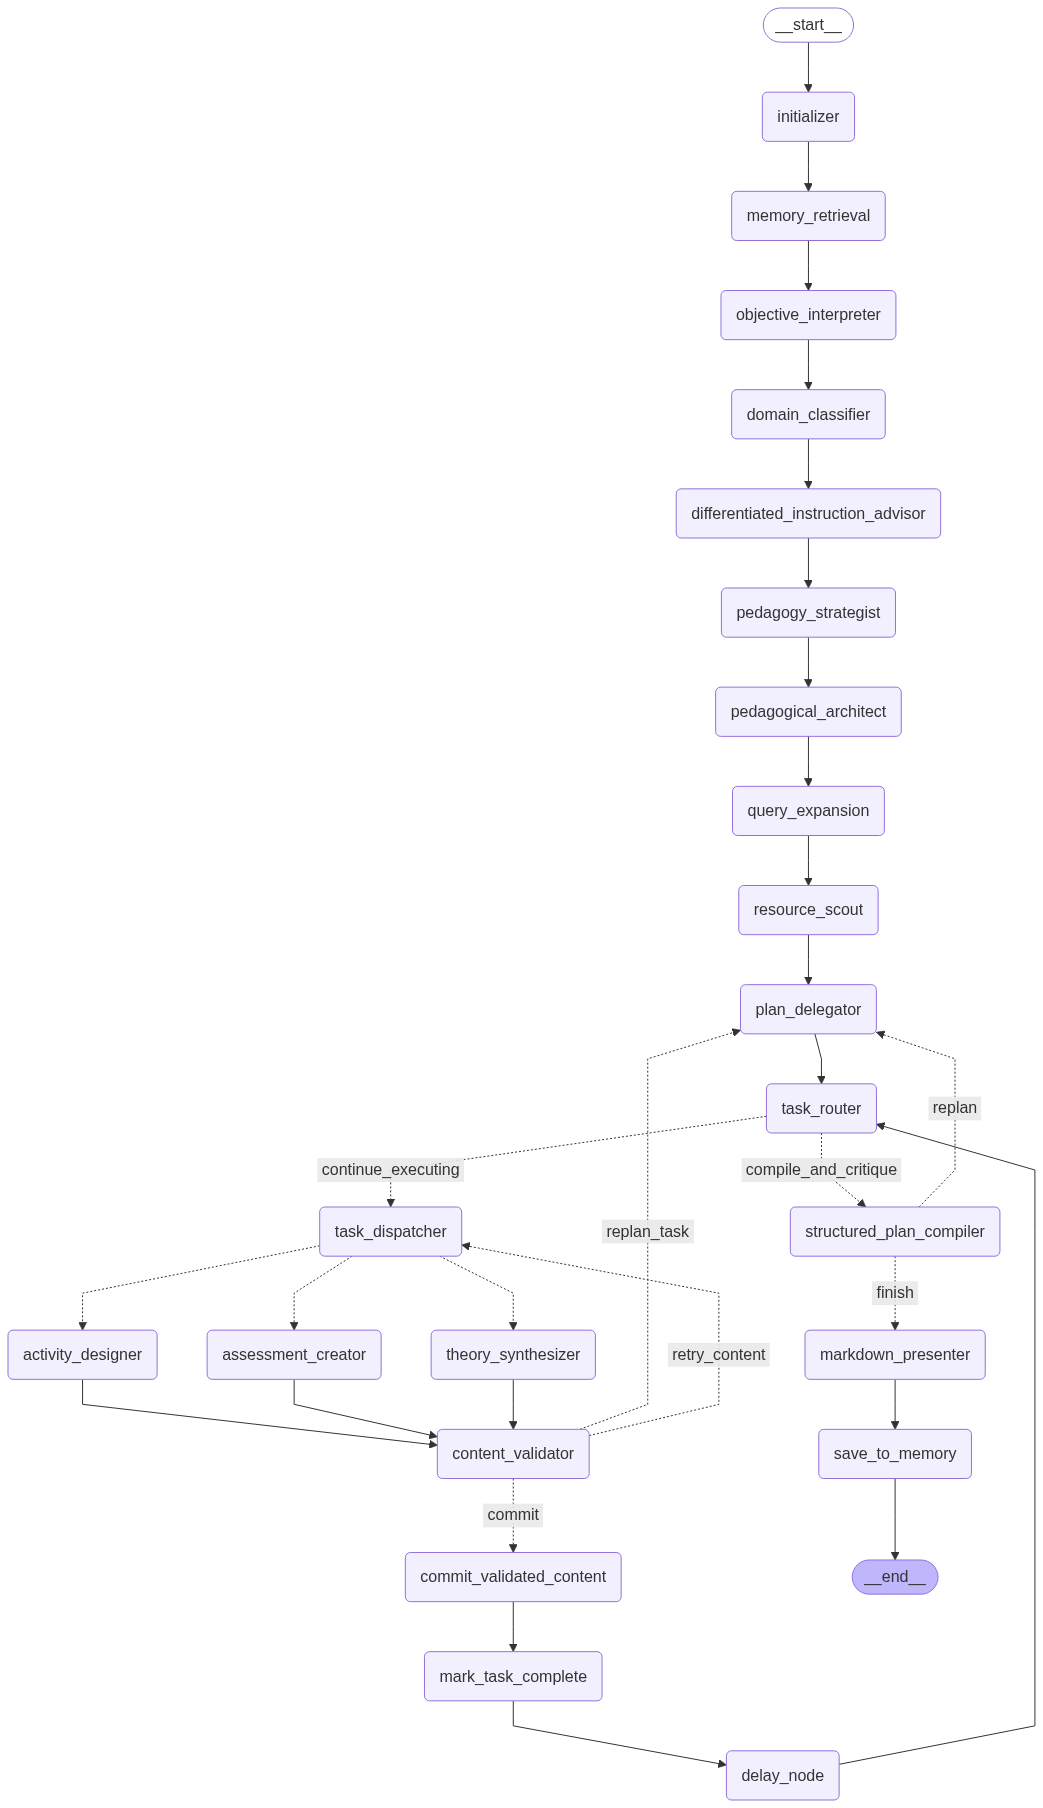

In [17]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [18]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [19]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

⚠️  Không có Trí nhớ Dài hạn. Bỏ qua bước này.

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 16
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

⚠️  Lỗi tại Objective Interpreter: 429 You exceeded your current quota, please check your plan and billing details.
For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. . Sử dụng mục tiêu 
mặc định.

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 13
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu về kiến thức nền tảng, học sinh dễ mất tập trung và cần các hoạt động có tính tương tác cao, đa dạng để duy trì sự chú ý và hứng thú trong suốt buổi học.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần cơ bản, sử dụng nhiều hình vẽ và ví dụ minh họa trực quan. Cung cấp phiếu bài tập có gợi ý, công thức và các bài tập điền khuyết để củng cố. Tổ chức hoạt động nhóm nhỏ để học sinh yếu được hỗ trợ từ bạn bè và giáo viên.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, yêu cầu chứng minh các tính chất hoặc giải các bài toán tổng hợp có nhiều bước. Khuyến khích học sinh tìm hiểu thêm về ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp hoặc tự thiết kế một bài toán nhỏ để thử thách tư duy.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học yếu và dễ mất tập trung vì nó khuyến khích học sinh tương tác tích cực, hỗ trợ lẫn nhau trong quá trình học tập. Việc làm việc nhóm giúp duy trì sự chú ý, tạo môi trường học tập thân thiện, giảm áp lực cho học sinh yếu và phát huy vai trò của học sinh khá giỏi trong việc giúp đỡ bạn bè. Các hoạt động đa dạng trong nhóm cũng giúp bài học trở nên sinh động, hấp dẫn hơn, từ đó nâng cao hiệu quả tiếp thu kiến thức.',
│   'key_actions': [
│   │   'Giới thiệu bài học và tổ chức nhóm học tập (chia nhóm ngẫu nhiên hoặc theo năng lực để đảm bảo sự hỗ trợ lẫn nhau).',
│   │   'Giao nhiệm vụ học tập theo nhóm (ví dụ: vẽ hình, khám phá tính chất, giải bài tập vận dụng từ cơ bản đến nâng cao).',
│   │   'Học sinh thảo luận, hợp tác và hỗ trợ lẫn nhau trong nhóm để hoàn thành nhiệm vụ.',
│   │   'Giáo viên quan sát, hướng dẫn, gợi mở và hỗ trợ các nhóm khi cần thiết, đặc biệt chú ý đến các nhóm yếu.',
│   │   'Đại diện nhóm trình bày kết quả, chia sẻ cách giải quyết hoặc sản phẩm của nhóm trước lớp.',
│   │   'Giáo viên tổng kết, củng cố kiến thức trọng tâm, giải đáp thắc mắc và giao bài tập về nhà.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   "Khởi động và Khám phá ban đầu: Giáo viên sử dụng các câu hỏi gợi mở, hình ảnh hoặc vật thật để liên hệ kiến thức cũ. Tổ chức hoạt động nhóm nhỏ (2-3 học sinh) để học sinh cùng nhau vẽ hình, cắt dán hoặc sử dụng compa, thước để 'khám phá' vị trí tâm của đường tròn ngoại tiếp/nội tiếp của các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông). Khuyến khích học sinh chia sẻ những gì các em quan sát được.",
│   'Xây dựng kiến thức và Luyện tập cơ bản: Giáo viên hệ thống hóa kiến thức từ hoạt động khám phá của học sinh, đưa ra các định nghĩa và tính chất chính thức. Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu để củng cố định nghĩa và tính chất. Giáo viên quan sát, đi vòng quanh hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời.',
│   'Vận dụng và Phát triển tư duy: Giao các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) theo nhóm. Các bài tập được phân hóa: bài cơ bản cho tất cả các nhóm, bài nâng cao hơn cho nhóm khá/giỏi hoặc như một thử thách thêm. Khuyến khích các nhóm thảo luận sâu, trình bày cách giải, chia sẻ kinh nghiệm và bảo vệ lập luận của mình trước lớp.',
│   "Tổng kết và Củng cố: Giáo viên cùng học sinh tổng kết các kiến thức trọng tâm của bài học thông qua sơ đồ tư duy hoặc bảng tóm tắt. Tổ chức trò chơi nhỏ (ví dụ: 'Ai nhanh hơn', 'Đố vui') hoặc câu hỏi nhanh để kiểm tra mức độ hiểu bài của học sinh. Giao bài tập về nhà có phân hóa và hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm."
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'giáo án đường tròn ngoại tiếp và nội tiếp lớp 9 90 phút',
│   'giáo án toán 9 đường tròn ngoại tiếp nội tiếp cho học sinh yếu',
│   'hoạt động tương tác bài đường tròn ngoại tiếp nội tiếp lớp 9',
│   'phương pháp dạy học hấp dẫn đường tròn ngoại tiếp nội tiếp toán 9',
│   'bài tập thực hành đường tròn ngoại tiếp nội tiếp lớp 9 cho học sinh yếu',
│   'giáo án đổi mới đường tròn ngoại tiếp nội tiếp lớp 9',
│   'kế hoạch bài dạy đường tròn ngoại tiếp nội tiếp 90 phút có trò chơi',
│   'tài liệu dạy học đường tròn ngoại tiếp nội tiếp lớp 9 tương tác',
│   'cách làm cho học sinh yếu tập trung bài đường tròn ngoại tiếp nội tiếp',
│   'giáo án chi tiết đường tròn ngoại tiếp nội tiếp lớp 9 có hoạt động nhóm'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 50 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh và quý đồng nghiệp,\n\nVới vai trò là một giáo viên giàu kinh nghiệm, tôi xin tổng hợp kiến thức cốt lõi từ các đoạn văn bản được cung cấp để chuẩn bị cho một buổi học 90 phút về chủ đề liên quan đến đường tròn, đặc biệt lưu ý đến đặc điểm của một lớp học khá yếu, cần các hoạt động tương tác cao.\n\nDựa trên các trang 87, 88, 98, 99 và 111 được cung cấp, các kiến thức cốt lõi có thể tổng hợp được tập trung vào các khái niệm cơ bản về cung, dây của đường tròn và vị trí tương đối của đường thẳng với đường tròn. **Lưu ý rằng các đoạn văn bản này không trực tiếp đề cập đến "Đường tròn ngoại tiếp" hay "Đường tròn nội tiếp" mà tập trung vào các khái niệm nền tảng hơn.**\n\nDưới đây là bản tóm tắt kiến thức cốt lõi từ các đoạn văn bản đã cho:\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI**\n**Chủ đề: Các khái niệm cơ bản về Đường tròn (Cung, Dây và Vị trí tương đối của Đường thẳng với Đường tròn)**\n\n**I. Các Khái Niệm Cơ Bản về Cung và Dây của Đường Tròn**\n\n1.  **Dây (hay Dây cung):**\n    *   **Định nghĩa:** Đoạn thẳng nối hai điểm tùy ý của một đường tròn.\n    *   **Ví dụ:** Trên Hình 5.6 (không được cung cấp nhưng được nhắc đến), CD là một dây.\n\n2.  **Đường kính:**\n    *   **Định nghĩa:** Một dây đi qua tâm của đường tròn.\n    *   **Ví dụ:** Trên Hình 5.6, AB là một đường kính của đường tròn (O).\n\n3.  **Các Thuật Ngữ Liên Quan:**\n    *   **Cung:** Một phần của đường tròn.\n    *   **Nửa đường tròn:** Cung được tạo bởi đường kính.\n    *   **Góc ở tâm:** Góc có đỉnh trùng với tâm đường tròn.\n    *   **Cung bị chắn:** Cung nằm bên trong góc ở tâm.\n    *   **Số đo cung:** Giá trị đo của một cung.\n\n**II. Tính Chất của Dây và Đường Kính**\n\n1.  **Quan hệ độ dài:**\n    *   **Định lí:** Trong một đường tròn, đường kính là dây cung lớn nhất.\n    *   **Suy luận:** Đối với một dây AB tùy ý không đi qua tâm của đường tròn (O; R), độ dài dây AB luôn nhỏ hơn hai lần bán kính (tức là nhỏ hơn đường kính): $AB < 2R$.\n\n**III. Các Khái Niệm về Vị Trí Tương Đối của Đường Thẳng và Đường Tròn**\n\n1.  **Các Thuật Ngữ Liên Quan:**\n    *   **Tiếp tuyến:** Đường thẳng có một điểm chung duy nhất với đường tròn.\n    *   **Tiếp điểm:** Điểm chung duy nhất giữa tiếp tuyến và đường tròn.\n    *   **Hai tiếp tuyến cắt nhau:** Trường hợp hai đường thẳng cùng là tiếp tuyến của một đường tròn và cắt nhau tại một điểm.\n\n---\n\n**Lưu ý cho giáo án:**\nMặc dù các đoạn văn bản không trực tiếp cung cấp kiến thức về "Đường tròn ngoại tiếp" và "Đường tròn nội tiếp", nhưng các khái niệm về dây, đường kính, cung và tiếp tuyến là nền tảng quan trọng để học sinh có thể tiếp thu các kiến thức nâng cao hơn về đường tròn ngoại tiếp và nội tiếp sau này. Với một lớp học yếu, việc củng cố vững chắc các khái niệm cơ bản này là rất cần thiết trước khi đi sâu vào các chủ đề phức tạp hơn.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 6 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá vị trí tâm đường tròn',
│   │   'task_description': 'Học sinh theo nhóm 2-3 người, sử dụng compa và thước để vẽ các tam giác đặc biệt (đều, vuông) và xác định vị trí tâm của đường tròn ngoại tiếp, nội tiếp bằng cách vẽ các đường đặc biệt (trung trực, phân giác). Sau đó, các nhóm chia sẻ quan sát và nhận xét của mình trước lớp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức cơ bản về đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa và tính chất chính thức của đường tròn ngoại tiếp, nội tiếp tam giác vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu để củng cố định nghĩa và tính chất vừa học. Giáo viên đi vòng quanh hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời cho các nhóm.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng kiến thức giải bài tập và phát triển tư duy',
│   │   'task_description': 'Học sinh theo nhóm giải các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được phân hóa theo mức độ. Các nhóm thảo luận sâu, trình bày cách giải và bảo vệ lập luận của mình trước lớp, đồng thời chia sẻ kinh nghiệm giải bài.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết kiến thức và kiểm tra nhanh',
│   │   'task_description': "Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, tham gia trò chơi nhỏ (ví dụ: 'Ai nhanh hơn', 'Đố vui') hoặc trả lời câu hỏi nhanh để kiểm tra mức độ hiểu bài.",
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Hướng dẫn bài tập về nhà và tự học',
│   │   'task_description': 'Học sinh lắng nghe giáo viên giao bài tập về nhà có phân hóa và hướng dẫn cách tự học, gợi ý các nguồn tài liệu tham khảo thêm để mở rộng kiến thức.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá vị trí tâm đường tròn' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Khám phá vị trí tâm đường tròn',
│   'description': 'Học sinh làm việc theo nhóm 2-3 người, sử dụng compa, thước thẳng và bút chì để thực hiện các bước sau:\n\n1.  Vẽ một tam giác đều ABC bất kỳ.\n    *   Xác định tâm đường tròn ngoại tiếp tam giác bằng cách vẽ ít nhất hai đường trung trực của các cạnh. Đánh dấu giao điểm là O.\n    *   Vẽ đường tròn tâm O đi qua ba đỉnh của tam giác.\n    *   Ghi lại quan sát của em về vị trí của điểm O so với tam giác.\n\n2.  Vẽ một tam giác vuông DEF bất kỳ (ví dụ: vuông tại D).\n    *   Xác định tâm đường tròn ngoại tiếp tam giác bằng cách vẽ ít nhất hai đường trung trực của các cạnh. Đánh dấu giao điểm là P.\n    *   Vẽ đường tròn tâm P đi qua ba đỉnh của tam giác.\n    *   Ghi lại quan sát của em về vị trí của điểm P so với tam giác.\n\n3.  Vẽ một tam giác bất kỳ GHI.\n    *   Xác định tâm đường tròn nội tiếp tam giác bằng cách vẽ ít nhất hai đường phân giác của các góc. Đánh dấu giao điểm là Q.\n    *   Vẽ đường tròn tâm Q tiếp xúc với ba cạnh của tam giác.\n    *   Ghi lại quan sát của em về vị trí của điểm Q so với tam giác.\n\n4.  Thảo luận trong nhóm về các quan sát và nhận xét của mình. Chuẩn bị trình bày trước lớp về vị trí của tâm đường tròn ngoại tiếp và nội tiếp trong các loại tam giác đã vẽ.',
│   'duration_minutes': 15,
│   'activity_type': 'Thực hành nhóm và Khám phá',
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và chia lớp thành các nhóm 2-3 học sinh.',
│   │   'Phát phiếu hướng dẫn hoạt động và các dụng cụ cần thiết (giấy, compa, thước).',
│   │   'Đi lại giữa các nhóm, quan sát quá trình thực hiện của học sinh.',
│   │   'Gợi ý, đặt câu hỏi dẫn dắt cho các nhóm gặp khó khăn, đảm bảo tất cả học sinh đều tham gia.',
│   │   'Khuyến khích học sinh yếu trong nhóm được bạn bè hỗ trợ và tự tin thực hiện.',
│   │   'Yêu cầu đại diện các nhóm trình bày kết quả và quan sát của mình trước lớp.',
│   │   'Tổng hợp các kết quả, chốt lại kiến thức về định nghĩa và vị trí của tâm đường tròn ngoại tiếp/nội tiếp trong các loại tam giác đặc biệt, dẫn dắt vào bài học mới.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh trong quá trình khám phá:\n*   Tâm đường tròn ngoại tiếp có đặc điểm gì về khoảng cách đến các đỉnh của tam giác?\n*   Tâm đường tròn nội tiếp có đặc điểm gì về khoảng cách đến các cạnh của tam giác?\n*   Vị trí của tâm đường tròn ngoại tiếp thay đổi thế nào khi tam giác là tam giác vuông/đều/nhọn/tù?\n*   Vị trí của tâm đường tròn nội tiếp có thay đổi nhiều không so với các loại tam giác khác nhau?\n\nKết quả mong đợi:\n*   Tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực của ba cạnh. (Học sinh chỉ cần vẽ 2 đường để xác định)\n*   Tâm đường tròn nội tiếp là giao điểm của ba đường phân giác của ba góc. (Học sinh chỉ cần vẽ 2 đường để xác định)\n*   Với tam giác đều: Tâm đường tròn ngoại tiếp và nội tiếp trùng nhau, nằm ở trọng tâm tam giác.\n*   Với tam giác vuông: Tâm đường tròn ngoại tiếp nằm ở trung điểm cạnh huyền. Tâm đường tròn nội tiếp nằm bên trong tam giác.\n*   Với tam giác nhọn: Tâm đường tròn ngoại tiếp nằm bên trong tam giác.\n*   Với tam giác tù: Tâm đường tròn ngoại tiếp nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu hướng dẫn chi tiết từng bước vẽ (có hình minh họa nhỏ cho mỗi bước). Giáo viên dành thời gian đến nhóm yếu để hướng dẫn trực tiếp, có thể gợi ý các câu hỏi như: 'Để vẽ đường trung trực, em cần làm gì?', 'Đường phân giác chia góc thành mấy phần bằng nhau?'. Đảm bảo nhóm có học sinh khá hỗ trợ và giải thích cho bạn.",
│   │   'for_advanced_students': "Yêu cầu học sinh thử vẽ với tam giác tù hoặc tam giác nhọn bất kỳ để quan sát vị trí tâm. Đặt câu hỏi mở rộng: 'Em có nhận xét gì về vị trí tâm đường tròn ngoại tiếp/nội tiếp trong các loại tam giác khác nhau (nhọn, tù, vuông, đều)?', 'Tại sao giao điểm của các đường trung trực/phân giác lại là tâm đường tròn ngoại tiếp/nội tiếp?'. Thử thách: 'Nếu chỉ cho 2 đỉnh v

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 15 phút là không hợp lý cho hoạt động được mô tả. Hoạt động yêu cầu
học sinh thực hiện nhiều bước phức tạp như vẽ 3 loại tam giác khác nhau, xác định 3 tâm đường tròn (2 ngoại tiếp, 1
nội tiếp) bằng cách vẽ các đường đặc biệt, sau đó vẽ đường tròn, ghi lại quan sát, thảo luận nhóm và chuẩn bị trình
bày. Với khối lượng công việc này, đặc biệt là tính chất khám phá và thực hành hình học, học sinh cần nhiều thời 
gian hơn để thực hiện chính xác, thảo luận sâu và giáo viên có thể tổng kết. Thời lượng hợp lý hơn cho hoạt động 
này, bao gồm cả phần trình bày và tổng kết của giáo viên, nên là khoảng 40 phút. | SUGGESTED_DURATION: 40

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 3 người, sử dụng compa, thước và giấy để vẽ, cắt dán các loại tam giác (đều, vuông) và xác định vị trí tâm của đường tròn ngoại tiếp, nội tiếp bằng cách thực hành vẽ các đường trung trực, đường phân giác. Sau đó, các nhóm chia sẻ kết quả và quan sát của mình trước lớp.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Củng cố định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập bao gồm điền khuyết định nghĩa, nối hình với tính chất tương ứng, và vẽ hình minh họa các trường hợp đường tròn ngoại tiếp, nội tiếp tam giác. Giáo viên sẽ đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng kiến thức giải bài tập',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng từ cơ bản đến nâng cao (tính toán, chứng minh đơn giản, bài toán thực tế). Các nhóm sẽ thảo luận sâu, trình bày cách giải của mình trước lớp và bảo vệ lập luận.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết và củng cố kiến thức',
│   │   'task_description': 'Giáo viên cùng học sinh hệ thống hóa kiến thức trọng tâm của bài học thông qua sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, học sinh tham gia trò chơi "Ai nhanh hơn" hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài. Cuối cùng, giáo viên giao bài tập về nhà có phân hóa và hướng dẫn tự học.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Học sinh làm việc theo nhóm 3 người. Mỗi nhóm sẽ nhận được giấy, compa, thước kẻ và kéo. Các em sẽ thực hiện các bước sau:\n1. Vẽ một tam giác đều bất kỳ. Sau đó, xác định tâm đường tròn ngoại tiếp (giao điểm của các đường trung trực) và tâm đường tròn nội tiếp (giao điểm của các đường phân giác) của tam giác đó. Vẽ cả hai đường tròn.\n2. Vẽ một tam giác vuông bất kỳ. Tương tự, xác định tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp của tam giác vuông. Vẽ cả hai đường tròn.\n3. Quan sát và ghi lại vị trí đặc biệt của tâm đường tròn ngoại tiếp và nội tiếp đối với từng loại tam giác (đều, vuông).\n4. Thảo luận trong nhóm về những điểm giống và khác nhau về vị trí tâm của hai loại đường tròn này.\n5. Chuẩn bị trình bày kết quả và những quan sát của nhóm trước lớp.',
│   'duration_minutes': 20,
│   'activity_type': 'Thực hành nhóm',
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động, phân chia nhóm và phát dụng cụ học tập (giấy, compa, thước, kéo) cho từng nhóm.',
│   │   'Hướng dẫn học sinh các bước thực hiện, nhắc nhở về sự chính xác khi vẽ các đường đặc biệt (trung trực, phân giác).',
│   │   'Đi vòng quanh các nhóm, quan sát quá trình làm việc, kịp thời hỗ trợ, gợi ý khi học sinh gặp khó khăn (ví dụ: cách vẽ đường trung trực, đường phân giác).',
│   │   'Khuyến khích học sinh thảo luận, chia sẻ ý tưởng và quan sát trong nhóm.',
│   │   'Yêu cầu các nhóm trình bày kết quả, đặt câu hỏi gợi mở để học sinh chia sẻ quan sát và nhận xét.',
│   │   'Tổng kết các kết quả của học sinh, chốt lại kiến thức về vị trí tâm đường tròn ngoại tiếp và nội tiếp của tam giác đều và tam giác vuông.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh:\n- Làm thế nào để vẽ đường trung trực của một đoạn thẳng? Cần vẽ bao nhiêu đường trung trực để xác định tâm đường tròn ngoại tiếp?\n- Làm thế nào để vẽ đường phân giác của một góc? Cần vẽ bao nhiêu đường phân giác để xác định tâm đường tròn nội tiếp?\n- Đối với tam giác đều, các em có nhận xét gì về vị trí của tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp?\n- Đối với tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu? Tâm đường tròn nội tiếp nằm ở đâu?\n- Tâm đường tròn ngoại tiếp có luôn nằm bên trong tam giác không? Còn tâm đường tròn nội tiếp thì sao?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu bài tập có sẵn các hình tam giác (đều, vuông) đã được vẽ mờ hoặc có các điểm gợi ý để học sinh chỉ cần nối hoặc hoàn thiện. Kèm theo các câu hỏi điền khuyết để học sinh dễ dàng ghi lại quan sát (ví dụ: 'Tâm đường tròn ngoại tiếp của tam giác vuông nằm ở ______ của cạnh huyền'). Giáo viên dành nhiều thời gian hơn để hướng dẫn trực tiếp các nhóm này, có thể vẽ mẫu một bước nhỏ để học sinh hình dung.",
│   │   'for_advanced_students': "Yêu cầu các nhóm này thử vẽ thêm một tam giác tù và xác định vị trí tâm đường tròn ngoại tiếp, nội tiếp của nó. Đặt câu hỏi mở rộng: 'Các em có nhận xét gì về mối quan hệ giữa tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp trong tam giác đều? Tại sao lại như vậy?' hoặc 'Hãy thử chứng minh tại sao tâm đường tròn ngoại tiếp của tam giác vuông lại nằm trên trung điểm cạnh huyền'."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 20 phút là không đủ để học sinh hoàn thành tất cả các bước được mô 
tả một cách cẩn thận và có ý nghĩa. Hoạt động yêu cầu học sinh vẽ hai loại tam giác, thực hiện nhiều phép dựng hình
phức tạp (vẽ đường trung trực, đường phân giác để xác định hai loại tâm cho mỗi tam giác), vẽ đường tròn, quan sát,
thảo luận nhóm và chuẩn bị trình bày. Với khối lượng công việc này, đặc biệt là yêu cầu về độ chính xác khi dựng 
hình, 20 phút sẽ khiến học sinh phải làm việc vội vàng, khó đạt được hiệu quả học tập mong muốn. Cần có thêm thời 
gian để học sinh thực hành, khám phá và chia sẻ. | SUGGESTED_DURATION: 40

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá vị trí tâm đường tròn',
│   │   'task_description': "Học sinh làm việc theo nhóm (2-3 em) sử dụng compa, thước và giấy để vẽ, cắt dán các tam giác đặc biệt (tam giác đều, tam giác vuông) và cùng nhau 'khám phá' vị trí tâm của đường tròn ngoại tiếp và đường tròn nội tiếp. Sau đó, các nhóm sẽ chia sẻ những quan sát và nhận xét của mình trước lớp để liên hệ kiến thức cũ và tạo hứng thú.",
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức và Luyện tập cơ bản',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập được thiết kế với dạng điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu. Các bài tập này nhằm củng cố các định nghĩa và tính chất chính thức của đường tròn ngoại tiếp và đường tròn nội tiếp mà giáo viên vừa hệ thống hóa. Giáo viên sẽ đi vòng quanh hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời cho từng nhóm.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng và Phát triển tư duy',
│   │   'task_description': 'Học sinh theo nhóm sẽ giải quyết các bài tập vận dụng đa dạng, bao gồm tính toán, chứng minh đơn giản và các bài toán thực tế liên quan đến đường tròn ngoại tiếp và nội tiếp. Các bài tập được phân hóa theo mức độ khó để phù hợp với năng lực của từng nhóm. Học sinh được khuyến khích thảo luận sâu, trình bày cách giải và bảo vệ lập luận của nhóm mình trước lớp.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết, củng cố kiến thức và định hướng tự học',
│   │   'task_description': "Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, học sinh tham gia một trò chơi nhỏ (ví dụ: 'Ai nhanh hơn' hoặc 'Đố vui') hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài. Cuối cùng, học sinh nhận bài tập về nhà có phân hóa và được hướng dẫn cách tự học, tìm kiếm tài liệu tham khảo thêm.",
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá vị trí tâm đường tròn' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Khám phá vị trí tâm đường tròn',
│   'description': 'Học sinh làm việc theo nhóm (2-3 em) để khám phá vị trí tâm của đường tròn ngoại tiếp và đường tròn nội tiếp của các tam giác đặc biệt. Các bước thực hiện:\n1.  Mỗi nhóm nhận phiếu bài tập, giấy A4, compa, thước kẻ và kéo.\n2.  Trên giấy A4, mỗi nhóm vẽ và cắt ra 01 tam giác đều và 01 tam giác vuông (có kích thước vừa phải để dễ thao tác).\n3.  Với tam giác đều:\n    a.  Sử dụng thước và compa để dựng hai đường trung trực của hai cạnh bất kỳ. Giao điểm của chúng là tâm đường tròn ngoại tiếp. Vẽ đường tròn ngoại tiếp tam giác.\n    b.  Sử dụng thước và compa để dựng hai đường phân giác của hai góc bất kỳ. Giao điểm của chúng là tâm đường tròn nội tiếp. Vẽ đường tròn nội tiếp tam giác.\n    c.  Quan sát và ghi lại nhận xét về vị trí của hai tâm này so với tam giác đều.\n4.  Với tam giác vuông:\n    a.  Sử dụng thước và compa để dựng hai đường trung trực của hai cạnh bất kỳ. Giao điểm của chúng là tâm đường tròn ngoại tiếp. Vẽ đường tròn ngoại tiếp tam giác.\n    b.  Sử dụng thước và compa để dựng hai đường phân giác của hai góc bất kỳ. Giao điểm của chúng là tâm đường tròn nội tiếp. Vẽ đường tròn nội tiếp tam giác.\n    c.  Quan sát và ghi lại nhận xét về vị trí của hai tâm này so với tam giác vuông.\n5.  Thảo luận trong nhóm về những quan sát và nhận xét đã ghi được. Chuẩn bị trình bày trước lớp những phát hiện của nhóm mình.',
│   'duration_minutes': 20,
│   'activity_type': 'Thực hành nhóm và Khám phá',
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu của hoạt động: khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp của tam giác.',
│   │   'Phát phiếu bài tập, giấy A4, compa, thước, kéo cho từng nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện trên phiếu bài tập, nhấn mạnh tầm quan trọng của việc dựng hình chính xác.',
│   │   'Đi quanh các nhóm, quan sát quá trình làm việc của học sinh, kịp thời hỗ trợ khi các em gặp khó khăn trong việc dựng hình hoặc xác định tâm.',
│   │   "Đặt các câu hỏi gợi mở để kích thích tư duy của học sinh (ví dụ: 'Các em thấy tâm này nằm ở đâu so với tam giác? Có gì đặc biệt không?', 'Vị trí của hai tâm này có trùng nhau không?').",
│   │   'Khuyến khích các nhóm thảo luận sôi nổi và ghi lại đầy đủ các nhận xét, quan sát.',
│   │   'Quản lý thời gian, nhắc nhở các nhóm chuẩn bị kết thúc hoạt động và sẵn sàng trình bày.',
│   │   'Yêu cầu đại diện các nhóm lên chia sẻ kết quả và nhận xét của nhóm mình trước lớp.',
│   │   'Tổng hợp các quan sát và nhận xét của học sinh, dẫn dắt vào kiến thức mới của bài học.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở và hướng dẫn quan sát:\n*   Đối với tam giác đều: Tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp có vị trí như thế nào? (Gợi ý: Chúng có trùng nhau không?)\n*   Đối với tam giác vuông: Tâm đường tròn ngoại tiếp nằm ở đâu? (Gợi ý: Có nằm trên cạnh nào của tam giác không?)\n*   Tâm đường tròn nội tiếp của cả hai loại tam giác đều nằm ở đâu so với tam giác? (Gợi ý: Luôn nằm bên trong hay bên ngoài?)\n*   Các em có thấy điểm chung nào về vị trí của tâm đường tròn ngoại tiếp/nội tiếp trong các loại tam giác khác nhau không?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu bài tập có sẵn hình tam giác (chỉ cần dựng hình các đường đặc biệt và tâm). Giáo viên có thể hướng dẫn trực tiếp từng bước dựng hình cho nhóm này, hoặc cung cấp một 'phiếu gợi ý' với các bước dựng hình chi tiết hơn (ví dụ: 'Để tìm tâm đường tròn ngoại tiếp, hãy vẽ hai đường trung trực của hai cạnh bất kỳ. Giao điểm của chúng là tâm.'). Có thể chỉ yêu cầu các em tập trung vào việc tìm một loại tâm cho một loại tam giác trước.",
│   │   'for_advanced_students': "Yêu cầu các em thử nghiệm với một tam giác nhọn bất kỳ hoặc một tam giác tù để quan sát vị trí tâm đường tròn ngoại tiếp. Đặt câu hỏi mở rộng: 'Em có nhận xét gì về vị trí tâm đường tròn ngoại tiếp của tam giác nhọn/tù? Tại sao lại như vậy?'. Khuyến khích các em giải thích mối liên hệ giữa tâ

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Nội dung hoạt động được mô tả rất chi tiết và đầy đủ các bước, thể hiện rõ mục
tiêu khám phá. Tuy nhiên, thời lượng 20 phút là hoàn toàn không hợp lý và bất khả thi để học sinh có thể hoàn thành
tất cả các bước được mô tả, bao gồm: vẽ và cắt 2 loại tam giác, thực hiện 8 phép dựng hình (2 đường trung trực, 2 
đường phân giác cho mỗi tam giác), vẽ 4 đường tròn, quan sát, ghi nhận xét, thảo luận nhóm, chuẩn bị trình bày, và 
đặc biệt là phần chia sẻ trước lớp của các nhóm cùng với tổng kết của giáo viên. Các hoạt động dựng hình bằng compa
và thước đòi hỏi sự tỉ mỉ và thời gian, đặc biệt là ở giai đoạn khám phá khi học sinh có thể cần thử lại. Để đảm 
bảo học sinh có đủ thời gian thực hiện, khám phá sâu và chia sẻ hiệu quả, hoạt động này cần ít nhất 35-45 phút. | 
SUGGESTED_DURATION: 40

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 9 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Ôn tập kiến thức nền',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở về đường tròn, tam giác và các khái niệm liên quan đã học. Học sinh xung phong trả lời các câu hỏi để ôn lại kiến thức cũ.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Hoạt động nhóm: Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh chia nhóm (2-3 em), nhận vật liệu (giấy, compa, thước, kéo). Mỗi nhóm thực hiện vẽ, cắt dán hoặc dùng compa, thước để xác định vị trí tâm đường tròn ngoại tiếp và nội tiếp của các tam giác đặc biệt (tam giác đều, tam giác vuông) theo hướng dẫn của giáo viên. Sau đó, các nhóm thảo luận và ghi lại những quan sát, nhận xét của mình về vị trí các tâm này.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức: Định nghĩa và tính chất',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, đưa ra các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan. Học sinh ghi chép đầy đủ vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập cơ bản: Củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập được phát, bao gồm các dạng điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu để củng cố các định nghĩa và tính chất vừa học. Giáo viên sẽ đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng: Giải bài tập theo nhóm',
│   │   'task_description': 'Học sinh theo nhóm nhận các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) đã được phân hóa. Các nhóm thảo luận sâu, phân công nhiệm vụ và cùng nhau tìm ra lời giải cho các bài tập.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Phát triển tư duy: Trình bày và bảo vệ lập luận',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày cách giải một hoặc nhiều bài tập đã được giao. Các nhóm khác lắng nghe, đặt câu hỏi và đưa ra phản biện (nếu có) để cùng nhau hoàn thiện lời giải.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết: Sơ đồ tư duy/Bảng tóm tắt',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học bằng cách xây dựng sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa, tính chất và cách xác định tâm đường tròn ngoại tiếp/nội tiếp.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': "Củng cố: Trò chơi 'Ai nhanh hơn'",
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ 'Ai nhanh hơn' hoặc trả lời nhanh các câu hỏi trắc nghiệm ngắn để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách vui vẻ, tương tác.",
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Giao nhiệm vụ: Bài tập về nhà và tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà được giao (có phân hóa) và lắng nghe giáo viên hướng dẫn cách tự học, gợi ý các nguồn tài liệu tham khảo thêm để mở rộng kiến thức.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Ôn tập kiến thức nền' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động: Ôn tập kiến thức nền',
│   'description': '1. Học sinh lắng nghe giáo viên đặt các câu hỏi gợi mở về các khái niệm cơ bản liên quan đến đường tròn và tam giác đã học ở các lớp dưới (ví dụ: tâm, bán kính, đường kính của đường tròn; các loại tam giác; tính chất đường trung trực, đường phân giác của tam giác).2. Học sinh xung phong trả lời các câu hỏi.3. Học sinh ghi nhớ các kiến thức trọng tâm được giáo viên tổng kết.',
│   'duration_minutes': 3,
│   'activity_type': 'Ôn tập',
│   'teacher_actions': [
│   │   'Đặt các câu hỏi gợi mở: "Đường tròn là gì?", "Tâm đường tròn là gì?", "Bán kính, đường kính là gì?", "Kể tên các loại tam giác mà em biết?", "Đường trung trực của đoạn thẳng là gì?", "Đường phân giác của góc là gì?".',
│   │   'Ghi nhanh các từ khóa/khái niệm lên bảng khi học sinh trả lời.',
│   │   'Khuyến khích tất cả học sinh tham gia trả lời, không chỉ một vài em.',
│   │   'Tổng kết nhanh các kiến thức nền cần thiết cho bài mới.'
│   ],
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể đưa ra các câu hỏi trắc nghiệm đơn giản hoặc câu hỏi điền khuyết trên màn hình/bảng phụ để học sinh dễ dàng lựa chọn/điền vào. Sử dụng hình ảnh trực quan (ví dụ: hình ảnh đường tròn, các loại tam giác) để gợi ý cho câu trả lời. Gọi tên học sinh yếu để đặt các câu hỏi rất cơ bản, dễ trả lời để các em tự tin.',
│   │   'for_advanced_students': 'Đặt các câu hỏi mở rộng hơn: "Theo em, tại sao chúng ta cần ôn lại các khái niệm này trước khi học bài mới?", "Có mối liên hệ nào giữa đường tròn và tam giác mà em đã biết không?". Yêu cầu học sinh giải thích sâu hơn về một tính chất nào đó (ví dụ: "Tại sao đường trung trực của một đoạn thẳng lại có tính chất đó?").'
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 3 phút là quá ngắn cho hoạt động khởi động này. Với số lượng câu hỏi
gợi mở về nhiều khái niệm (đường tròn, tam giác, đường trung trực, đường phân giác) và các hoạt động như học sinh 
xung phong trả lời, giáo viên ghi từ khóa lên bảng, khuyến khích nhiều học sinh tham gia và tổng kết kiến thức, 
hoạt động này cần nhiều thời gian hơn để đảm bảo hiệu quả và sự tham gia của học sinh. Hoạt động này có thể kéo dài
từ 7-10 phút. | SUGGESTED_DURATION: 8

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá ban đầu về tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh theo nhóm 2-3 người, sử dụng compa và thước để vẽ, cắt dán các loại tam giác (đều, vuông) và tìm vị trí tâm của đường tròn ngoại tiếp, nội tiếp bằng cách vẽ các đường đặc biệt (trung trực, phân giác). Sau đó, các nhóm chia sẻ kết quả và quan sát của mình trước lớp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức và Luyện tập cơ bản',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa và tính chất chính thức về đường tròn ngoại tiếp và nội tiếp. Sau đó, học sinh làm việc nhóm để hoàn thành phiếu bài tập điền khuyết, nối hình hoặc vẽ hình theo yêu cầu để củng cố các định nghĩa và tính chất vừa học.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng kiến thức và Phát triển tư duy qua bài tập nhóm',
│   │   'task_description': 'Học sinh theo nhóm giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao. Các nhóm thảo luận sâu, tìm ra cách giải, sau đó cử đại diện trình bày cách giải và bảo vệ lập luận của nhóm trước lớp.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết và Củng cố kiến thức',
│   │   'task_description': "Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, học sinh tham gia trò chơi nhỏ 'Ai nhanh hơn' hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài. Cuối cùng, học sinh ghi lại bài tập về nhà và các hướng dẫn tự học từ giáo viên.",
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá ban đầu về tâm đường tròn ngoại tiếp và nội tiếp' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khám phá ban đầu về tâm đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Học sinh theo nhóm 2-3 người, sử dụng compa và thước để vẽ, cắt dán các loại tam giác (đều, vuông) và tìm vị trí tâm của đường tròn ngoại tiếp, nội tiếp bằng cách vẽ các đường đặc biệt (trung trực, phân giác). Sau đó, các nhóm chia sẻ kết quả và quan sát của mình trước lớp.',
│   'duration_minutes': 15,
│   'activity_type': 'Thực hành nhóm',
│   'teacher_actions': [
│   │   'Phát phiếu hướng dẫn hoạt động và các dụng cụ cần thiết (compa, thước, giấy, kéo) cho từng nhóm.',
│   │   'Hướng dẫn học sinh đọc kỹ yêu cầu trên phiếu và bắt đầu thực hiện theo nhóm.',
│   │   'Đi vòng quanh lớp, quan sát quá trình làm việc của các nhóm, kịp thời hỗ trợ và giải đáp thắc mắc.',
│   │   "Đặt các câu hỏi gợi mở cho các nhóm để các em tự khám phá và rút ra nhận xét (ví dụ: 'Các em đã vẽ được những đường gì để tìm tâm?', 'Tâm này có đặc điểm gì đặc biệt?').",
│   │   'Yêu cầu đại diện một số nhóm lên trình bày kết quả thực hành và những quan sát, nhận xét của nhóm mình.',
│   │   'Tổng hợp các kết quả và nhận xét của học sinh, dẫn dắt vào kiến thức mới về định nghĩa và tính chất của tâm đường tròn ngoại tiếp, nội tiếp.'
│   ],
│   'solution_guide': 'Gợi ý cho học sinh:\n- Đối với đường tròn ngoại tiếp: Tâm là giao điểm của ba đường trung trực của tam giác. Bán kính là khoảng cách từ tâm đến các đỉnh của tam giác.\n- Đối với đường tròn nội tiếp: Tâm là giao điểm của ba đường phân giác của tam giác. Bán kính là khoảng cách từ tâm đến các cạnh của tam giác (vuông góc).\n- Các em hãy kiểm tra lại bằng cách dùng compa vẽ đường tròn xem có đi qua các đỉnh (ngoại tiếp) hoặc tiếp xúc với các cạnh (nội tiếp) không nhé!',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu hướng dẫn có sẵn các bước vẽ chi tiết hơn (ví dụ: 'Bước 1: Vẽ tam giác ABC. Bước 2: Vẽ đường trung trực của cạnh AB...'). Có thể cung cấp sẵn một số tam giác đã được vẽ hoặc cắt sẵn để học sinh chỉ tập trung vào việc tìm tâm. Giáo viên dành thời gian hỗ trợ trực tiếp các nhóm này, gợi ý cụ thể về các đường cần vẽ (ví dụ: 'Để tìm tâm đường tròn ngoại tiếp, các em cần vẽ các đường gì? (Gợi ý: Trung trực)').",
│   │   'for_advanced_students': "Yêu cầu các em thử tìm tâm đường tròn ngoại tiếp/nội tiếp của một tam giác tù hoặc tam giác nhọn bất kỳ (ngoài tam giác đều và vuông). Đặt câu hỏi mở rộng: 'Các em có nhận xét gì về vị trí tâm đường tròn ngoại tiếp/nội tiếp đối với các loại tam giác khác nhau (nhọn, vuông, tù, đều)?' Khuyến khích các em suy nghĩ về mối liên hệ giữa các đường đặc biệt (trung trực, phân giác) và tâm đường tròn."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 15 phút là không hợp lý cho hoạt động này. Để học sinh có thể theo 
nhóm 2-3 người, sử dụng compa và thước để vẽ, cắt dán các loại tam giác (đều, vuông), sau đó tìm vị trí tâm của 
đường tròn ngoại tiếp và nội tiếp bằng cách vẽ các đường đặc biệt (trung trực, phân giác) cho từng loại tam giác, 
rồi các nhóm chia sẻ kết quả và giáo viên tổng hợp, dẫn dắt kiến thức mới, cần một khoảng thời gian dài hơn đáng 
kể. Hoạt động này đòi hỏi nhiều thao tác thực hành tỉ mỉ và thời gian để học sinh tự khám phá, thảo luận nhóm và 
trình bày. 15 phút chỉ đủ cho một phần rất nhỏ của các bước được mô tả. | SUGGESTED_DURATION: 45

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động - Ôn tập kiến thức cũ và tạo hứng thú',
│   │   'task_description': 'Học sinh tích cực tham gia trả lời các câu hỏi gợi mở của giáo viên về các khái niệm cơ bản của đường tròn và tam giác đã học, chuẩn bị tâm thế cho bài mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá - Vị trí tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 em, sử dụng compa, thước và giấy để vẽ các tam giác đặc biệt (tam giác đều, tam giác vuông) và thực hành xác định vị trí tâm của đường tròn ngoại tiếp, đường tròn nội tiếp bằng cách vẽ các đường đặc biệt (trung trực, phân giác).',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ và Thảo luận khám phá',
│   │   'task_description': 'Đại diện các nhóm luân phiên trình bày kết quả và cách thức khám phá của nhóm mình về vị trí tâm đường tròn ngoại tiếp và nội tiếp. Các nhóm khác lắng nghe, đặt câu hỏi và đóng góp ý kiến.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Hệ thống hóa kiến thức - Định nghĩa và tính chất',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên tổng hợp và hệ thống hóa các kiến thức đã khám phá, ghi chép cẩn thận các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất quan trọng vào vở.',
│   │   'estimated_duration': 8,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập cơ bản - Củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập được thiết kế dưới dạng điền khuyết, nối hình hoặc vẽ hình theo yêu cầu, nhằm củng cố và ghi nhớ các định nghĩa, tính chất cơ bản.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng kiến thức - Giải bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp, với các mức độ khó khác nhau được phân hóa.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và Thảo luận giải pháp',
│   │   'task_description': 'Đại diện các nhóm lần lượt trình bày cách giải và lập luận của nhóm mình cho các bài tập đã làm. Học sinh toàn lớp tích cực tham gia thảo luận, đặt câu hỏi phản biện và chia sẻ các phương pháp giải khác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa lại toàn bộ kiến thức trọng tâm của bài học bằng cách xây dựng sơ đồ tư duy hoặc bảng tóm tắt các khái niệm và công thức chính.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Củng cố và kiểm tra nhanh',
│   │   'task_description': 'Học sinh tham gia trò chơi "Ai nhanh hơn" hoặc trả lời nhanh các câu hỏi trắc nghiệm, đố vui của giáo viên để kiểm tra và củng cố ngay lập tức mức độ hiểu bài.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà được giao (có phân hóa) và lắng nghe giáo viên hướng dẫn chi tiết cách tự học, tìm kiếm và khai thác các nguồn tài liệu tham khảo bổ sung.',
│   │   'estimated_duration': 2,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động - Ôn tập kiến thức cũ và tạo hứng thú' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động - Ôn tập kiến thức cũ và tạo hứng thú: Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Học sinh làm việc theo nhóm 2-3 người. Mỗi nhóm sẽ nhận được các dụng cụ học tập (giấy, compa, thước, kéo) và các mẫu tam giác đã được in sẵn (tam giác đều, tam giác vuông, tam giác thường). Các nhóm thực hiện các bước sau:\n1.  **Vẽ đường tròn ngoại tiếp:** Với mỗi loại tam giác, các em hãy dùng thước và compa để vẽ ba đường trung trực của các cạnh. Xác định giao điểm của ba đường trung trực (tâm đường tròn ngoại tiếp) và vẽ đường tròn đi qua ba đỉnh của tam giác.\n2.  **Vẽ đường tròn nội tiếp:** Với mỗi loại tam giác, các em hãy dùng thước và compa để vẽ ba đường phân giác của các góc. Xác định giao điểm của ba đường phân giác (tâm đường tròn nội tiếp) và vẽ đường tròn tiếp xúc với ba cạnh của tam giác.\n3.  **Thảo luận và ghi nhận:** Quan sát vị trí của tâm đường tròn ngoại tiếp và nội tiếp đối với từng loại tam giác. Thảo luận trong nhóm về những điểm giống và khác nhau, cũng như vị trí đặc biệt của các tâm này.\n4.  **Chia sẻ:** Chuẩn bị trình bày kết quả và nhận xét của nhóm trước lớp.',
│   'duration_minutes': 5,
│   'activity_type': 'Thực hành nhóm và Khám phá',
│   'teacher_actions': [
│   │   'Chia lớp thành các nhóm nhỏ (2-3 học sinh) và phân phát tài liệu (giấy, compa, thước, kéo, các mẫu tam giác in sẵn).',
│   │   'Hướng dẫn rõ ràng các bước thực hiện hoạt động, nhấn mạnh mục tiêu là khám phá vị trí của tâm đường tròn ngoại tiếp và nội tiếp.',
│   │   'Đi vòng quanh các nhóm, quan sát, hỗ trợ và giải đáp thắc mắc khi học sinh gặp khó khăn trong việc vẽ hoặc xác định tâm.',
│   │   "Gợi ý các câu hỏi để kích thích tư duy và thảo luận trong nhóm (ví dụ: 'Tâm này nằm ở đâu so với tam giác?', 'Có gì đặc biệt khi tam giác là tam giác vuông/đều?').",
│   │   'Yêu cầu các nhóm trình bày kết quả và nhận xét của mình, khuyến khích các nhóm khác đặt câu hỏi.',
│   │   'Tổng hợp các kết quả và nhận xét từ các nhóm, dẫn dắt vào kiến thức mới về định nghĩa và tính chất của đường tròn ngoại tiếp/nội tiếp.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh:\n- Tâm đường tròn ngoại tiếp của tam giác nhọn, vuông, tù nằm ở đâu so với tam giác?\n- Tâm đường tròn nội tiếp luôn nằm ở đâu so với tam giác?\n- Có nhận xét gì về bán kính của đường tròn ngoại tiếp và nội tiếp khi tam giác là tam giác đều?\n- Làm thế nào để kiểm tra xem đường tròn đã vẽ có đúng là đường tròn ngoại tiếp/nội tiếp hay không?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các mẫu tam giác đã có sẵn một hoặc hai đường trung trực/phân giác để học sinh chỉ cần vẽ nốt phần còn lại. Chuẩn bị phiếu hướng dẫn từng bước cụ thể hơn với hình ảnh minh họa. Giáo viên dành thời gian hỗ trợ trực tiếp các nhóm này, gợi ý từng bước nhỏ để các em không bị choáng ngợp.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử dự đoán vị trí của tâm đường tròn ngoại tiếp và nội tiếp trước khi vẽ cho từng loại tam giác. Thử thách các em chứng minh tại sao giao điểm của các đường trung trực/phân giác lại là tâm của đường tròn. Gợi ý tìm hiểu thêm về tâm đường tròn ngoại tiếp của tam giác tù hoặc các trường hợp đặc biệt khác.'
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Hoạt động được mô tả trong phần "NỘI DUNG ĐƯỢC TẠO RA" hoàn toàn không phù hợp
với yêu cầu gốc về thời lượng và mục tiêu. Yêu cầu gốc là một hoạt động "Khởi động" 5 phút để "ôn tập kiến thức cũ 
và tạo hứng thú" thông qua "câu hỏi gợi mở". Tuy nhiên, nội dung được tạo ra lại là một hoạt động "Thực hành nhóm 
và Khám phá" rất chi tiết, yêu cầu học sinh thực hiện các bước vẽ hình phức tạp (vẽ đường trung trực, đường phân 
giác, đường tròn ngoại tiếp, nội tiếp cho nhiều loại tam giác), thảo luận nhóm và trình bày. Hoạt động này mang 
tính chất của một bài học khám phá kiến thức mới hoặc thực hành chuyên sâu, không thể hoàn thành trong 5 phút. Thời
lượng 5 phút là hoàn toàn bất khả thi cho các bước được mô tả. Hoạt động này cần ít nhất 30-45 phút để học sinh có 
thể thực hiện đầy đủ các thao tác và thảo luận có ý nghĩa. | SUGGESTED_DURATION: 30

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 9 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh trả lời các câu hỏi gợi mở của giáo viên về các khái niệm hình học đã học như tam giác, đường trung trực, đường phân giác để liên hệ với bài mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ (2-3 em) sử dụng compa, thước, hoặc vật liệu cắt dán để vẽ và xác định vị trí tâm của đường tròn ngoại tiếp và nội tiếp cho các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông). Sau đó, các nhóm chia sẻ những quan sát và nhận xét của mình.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Hệ thống hóa kiến thức và định nghĩa',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp, tâm đường tròn ngoại tiếp (trực tâm), tâm đường tròn nội tiếp (tâm đường tròn nội tiếp).',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu nhằm củng cố định nghĩa và tính chất của đường tròn ngoại tiếp và nội tiếp. Giáo viên quan sát và hỗ trợ kịp thời.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng giải bài tập đa dạng',
│   │   'task_description': 'Học sinh theo nhóm giải các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao, có phân hóa theo mức độ khó để phát triển tư duy và kỹ năng giải quyết vấn đề.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Trình bày và bảo vệ lập luận',
│   │   'task_description': 'Đại diện các nhóm trình bày cách giải bài tập của nhóm mình trước lớp. Học sinh đặt câu hỏi, phản biện và bảo vệ lập luận của nhóm mình dưới sự điều phối của giáo viên.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa, tính chất và cách xác định tâm đường tròn ngoại tiếp/nội tiếp.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Trò chơi củng cố và kiểm tra nhanh',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ (ví dụ: 'Ai nhanh hơn' hoặc 'Đố vui') hoặc trả lời nhanh các câu hỏi trắc nghiệm để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách vui vẻ.",
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Giáo viên giao bài tập về nhà có phân hóa và hướng dẫn học sinh tự học, gợi ý các nguồn tài liệu tham khảo thêm để các em tiếp tục luyện tập và mở rộng kiến thức.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': 'Học sinh lắng nghe các câu hỏi gợi mở của giáo viên về các khái niệm hình học đã học. Học sinh suy nghĩ, giơ tay phát biểu để trả lời các câu hỏi, sau đó cùng giáo viên tổng hợp kiến thức cũ để chuẩn bị cho bài học mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Hỏi đáp tương tác và ôn tập',
│   'teacher_actions': [
│   │   'Chiếu/viết lên bảng các câu hỏi gợi mở về kiến thức cũ.',
│   │   'Đặt câu hỏi rõ ràng, khuyến khích học sinh xung phong trả lời.',
│   │   'Lắng nghe các câu trả lời của học sinh, ghi nhận các ý đúng.',
│   │   'Chỉnh sửa, bổ sung các ý chưa chính xác hoặc chưa đầy đủ.',
│   │   "Dẫn dắt, kết nối các khái niệm đã ôn tập (đường trung trực, đường phân giác, tính chất cách đều) với chủ đề 'Đường tròn ngoại tiếp và nội tiếp' của bài mới."
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở và kiến thức cần học sinh nhớ lại:\n1.  Đường trung trực của đoạn thẳng là gì? (Là đường thẳng vuông góc với đoạn thẳng tại trung điểm của nó).\n2.  Tính chất của các điểm nằm trên đường trung trực? (Cách đều hai mút của đoạn thẳng).\n3.  Đường phân giác của góc là gì? (Là tia chia góc thành hai góc bằng nhau).\n4.  Tính chất của các điểm nằm trên đường phân giác? (Cách đều hai cạnh của góc).\n5.  Tâm đường tròn ngoại tiếp tam giác là giao điểm của những đường nào? (Giao điểm của ba đường trung trực của ba cạnh tam giác).\n6.  Tâm đường tròn nội tiếp tam giác là giao điểm của những đường nào? (Giao điểm của ba đường phân giác của ba góc tam giác).',
│   'differentiation': {
│   │   'for_struggling_students': "Đối với học sinh gặp khó khăn, giáo viên có thể đặt các câu hỏi đơn giản hơn, mang tính gợi ý trực tiếp (ví dụ: 'Đường trung trực đi qua đâu và vuông góc với cái gì?'). Cho phép học sinh thảo luận nhanh 30 giây với bạn bên cạnh trước khi trả lời để tăng sự tự tin.",
│   │   'for_advanced_students': "Đối với học sinh khá giỏi, giáo viên có thể đặt câu hỏi mở rộng, yêu cầu giải thích sâu hơn về 'tại sao' các tính chất đó lại đúng, hoặc liên hệ với các trường hợp đặc biệt của tam giác (ví dụ: 'Tâm đường tròn ngoại tiếp của tam giác vuông nằm ở đâu?')."
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện đầy đủ các hoạt động được mô tả. Với
6 câu hỏi gợi mở chi tiết, yêu cầu học sinh suy nghĩ, trả lời, giáo viên nhận xét, chỉnh sửa và đặc biệt là phần 
dẫn dắt, kết nối kiến thức cũ với bài mới, hoạt động này cần nhiều thời gian hơn để đảm bảo hiệu quả và không gây 
áp lực cho học sinh. Cần ít nhất 10 phút để thực hiện một cách hợp lý. | SUGGESTED_DURATION: 10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 7 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Ôn tập kiến thức liên quan',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở về các loại tam giác đặc biệt (đều, vuông, cân) và các khái niệm cơ bản về đường tròn (tâm, bán kính). Học sinh xung phong trả lời các câu hỏi để liên hệ kiến thức cũ.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá: Vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người. Mỗi nhóm được phát giấy, compa, thước. Các nhóm thực hiện vẽ các tam giác đặc biệt (đều, vuông) và dùng compa, thước để tìm tâm đường tròn đi qua 3 đỉnh (ngoại tiếp) hoặc tiếp xúc với 3 cạnh (nội tiếp). Sau đó, các nhóm chia sẻ kết quả và những quan sát của mình về vị trí của tâm.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức: Định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa các kiến thức đã khám phá, đưa ra các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp, tâm đường tròn ngoại tiếp (giao điểm 3 đường trung trực), tâm đường tròn nội tiếp (giao điểm 3 đường phân giác). Học sinh ghi chép các định nghĩa và tính chất vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập cơ bản: Củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành phiếu bài tập. Phiếu bài tập bao gồm các dạng: điền khuyết vào định nghĩa, nối hình với tên gọi tương ứng, vẽ hình minh họa đường tròn ngoại tiếp/nội tiếp cho các tam giác cho trước. Giáo viên đi vòng quanh lớp hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng: Giải bài tập thực hành và nâng cao',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải các bài tập vận dụng. Các bài tập bao gồm tính toán bán kính, chứng minh đơn giản liên quan đến tâm và bán kính, và một số bài toán thực tế. Các nhóm thảo luận sâu, trình bày cách giải lên bảng phụ hoặc giấy A0, sau đó cử đại diện trình bày trước lớp và bảo vệ lập luận của nhóm mình. Các nhóm khác đặt câu hỏi và góp ý.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Tổng kết và Củng cố: Sơ đồ tư duy và trò chơi',
│   │   'task_description': "Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học bằng cách xây dựng sơ đồ tư duy hoặc bảng tóm tắt trên bảng. Sau đó, học sinh tham gia trò chơi 'Ai nhanh hơn' hoặc 'Đố vui' với các câu hỏi trắc nghiệm nhanh về định nghĩa, tính chất và các trường hợp đặc biệt của đường tròn ngoại tiếp/nội tiếp để kiểm tra mức độ hiểu bài.",
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà được giao. Giáo viên hướng dẫn cách làm bài tập, gợi ý các nguồn tài liệu tham khảo thêm (sách giáo khoa, sách bài tập, video bài giảng trực tuyến) để học sinh tự học và ôn tập thêm tại nhà.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Ôn tập kiến thức liên quan' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động: Ôn tập kiến thức liên quan',
│   'description': 'Học sinh lắng nghe giáo viên đặt các câu hỏi gợi mở về các loại tam giác đặc biệt (đều, vuông, cân) và các khái niệm cơ bản về đường tròn (tâm, bán kính, vị trí tương đối của điểm với đường tròn). Học sinh xung phong hoặc được chỉ định trả lời các câu hỏi để liên hệ kiến thức cũ, chuẩn bị cho bài học mới. Các câu hỏi cụ thể bao gồm:\n1.  Thế nào là tam giác đều? Nêu các tính chất cơ bản của nó.\n2.  Thế nào là tam giác cân? Nêu các tính chất cơ bản của nó.\n3.  Thế nào là tam giác vuông? Nêu định lý Pytago.\n4.  Đường tròn được xác định bởi những yếu tố nào? Tâm và bán kính là gì?\n5.  Nêu các vị trí tương đối của một điểm với đường tròn.\n6.  Thế nào là tiếp tuyến của đường tròn?',
│   'duration_minutes': 5,
│   'activity_type': 'Ôn tập và gợi mở',
│   'teacher_actions': [
│   │   'Giáo viên ổn định lớp, giới thiệu hoạt động khởi động.',
│   │   'Giáo viên lần lượt đặt 6 câu hỏi gợi mở đã chuẩn bị, khuyến khích học sinh xung phong trả lời.',
│   │   "Quan sát, lắng nghe câu trả lời của học sinh, kịp thời đưa ra gợi ý hoặc câu hỏi phụ nếu học sinh gặp khó khăn (ví dụ: 'Em hãy thử vẽ hình minh họa xem sao?').",
│   │   'Khen ngợi, động viên những câu trả lời đúng và có sự cố gắng.',
│   │   'Chỉnh sửa, bổ sung các câu trả lời chưa đầy đủ hoặc sai sót, đảm bảo học sinh nắm vững kiến thức nền tảng.',
│   │   'Tổng kết nhanh các kiến thức đã ôn tập và dẫn dắt, kết nối một cách tự nhiên vào bài học mới về đường tròn ngoại tiếp và nội tiếp.'
│   ],
│   'solution_guide': '1.  **Tam giác đều:** Là tam giác có ba cạnh bằng nhau và ba góc bằng nhau (mỗi góc 60 độ).\n2.  **Tam giác cân:** Là tam giác có hai cạnh bằng nhau. Hai góc ở đáy đối diện với hai cạnh bằng nhau thì bằng nhau.\n3.  **Tam giác vuông:** Là tam giác có một góc bằng 90 độ. Định lý Pytago: Bình phương cạnh huyền bằng tổng bình phương hai cạnh góc vuông (a² + b² = c²).\n4.  **Đường tròn:** Được xác định bởi tâm (một điểm cố định) và bán kính (khoảng cách từ tâm đến mọi điểm trên đường tròn).\n5.  **Vị trí tương đối của một điểm với đường tròn:**\n    *   Điểm nằm trên đường tròn: Khoảng cách từ tâm đến điểm bằng bán kính.\n    *   Điểm nằm trong đường tròn: Khoảng cách từ tâm đến điểm nhỏ hơn bán kính.\n    *   Điểm nằm ngoài đường tròn: Khoảng cách từ tâm đến điểm lớn hơn bán kính.\n6.  **Tiếp tuyến của đường tròn:** Là đường thẳng chỉ có một điểm chung duy nhất với đường tròn. Tiếp tuyến vuông góc với bán kính tại tiếp điểm.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gọi tên trực tiếp học sinh yếu để trả lời các câu hỏi cơ bản nhất (ví dụ: định nghĩa tam giác đều, tâm đường tròn là gì). Cung cấp gợi ý trực quan bằng cách vẽ hình minh họa lên bảng hoặc cho phép học sinh tham khảo nhanh vở ghi cũ/thảo luận với bạn bên cạnh trong 15 giây trước khi trả lời.',
│   │   'for_advanced_students': "Yêu cầu học sinh giải thích sâu hơn về mối liên hệ giữa các tính chất của tam giác (ví dụ: tại sao tam giác đều cũng là tam giác cân?). Đặt câu hỏi mở rộng như 'Em có thể nêu một ví dụ thực tế về ứng dụng của đường tròn hoặc tam giác vuông không?' hoặc 'Nếu biết bán kính và tâm, em có thể xác định được bao nhiêu điểm nằm trên đường tròn?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện toàn bộ các hoạt động được mô tả. 
Việc đặt 6 câu hỏi chi tiết, bao gồm cả các khái niệm mở rộng như "vị trí tương đối của điểm với đường tròn" và 
"tiếp tuyến của đường tròn" (vốn không có trong yêu cầu gốc về "khái niệm cơ bản về đường tròn"), cùng với các hoạt
động của giáo viên như quan sát, gợi ý, khen ngợi, chỉnh sửa và tổng kết, sẽ cần nhiều thời gian hơn. Hoạt động này
có nguy cơ bị vội vàng, không đảm bảo học sinh ôn tập hiệu quả. Để đảm bảo chất lượng và đủ thời gian cho học sinh 
tương tác, suy nghĩ và giáo viên phản hồi, cần tăng thời lượng. | SUGGESTED_DURATION: 10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Ôn tập kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở, quan sát hình ảnh/vật thật và trả lời các câu hỏi liên quan đến đường tròn, tam giác đã học để kết nối kiến thức.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người, sử dụng compa, thước và giấy để vẽ, cắt dán các loại tam giác (đều, vuông) và thực hiện các thao tác để xác định vị trí tâm của đường tròn ngoại tiếp và đường tròn nội tiếp của từng tam giác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ kết quả khám phá',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả quan sát và cách các em đã xác định được tâm đường tròn ngoại tiếp/nội tiếp của các tam giác đặc biệt trước lớp.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Xây dựng kiến thức mới',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập bao gồm điền khuyết định nghĩa, nối hình với tính chất tương ứng, và vẽ hình minh họa theo yêu cầu để củng cố kiến thức vừa học.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng giải bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao, thảo luận sâu để tìm ra phương pháp giải.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và phản biện lời giải',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày cách giải các bài tập vận dụng, giải thích lập luận của nhóm mình và trả lời các câu hỏi từ giáo viên và các nhóm khác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa lại các kiến thức trọng tâm của bài học bằng cách xây dựng sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa và tính chất chính.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Kiểm tra nhanh và củng cố',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ "Ai nhanh hơn" hoặc trả lời các câu hỏi nhanh của giáo viên để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách vui vẻ.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh lắng nghe giáo viên giao bài tập về nhà có phân hóa và ghi lại các hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm để tiếp tục luyện tập.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Ôn tập kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Ôn tập kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: đồng hồ, bánh xe, logo, tam giác cắt từ giấy) mà giáo viên trình chiếu/đưa ra. Học sinh lắng nghe và trả lời các câu hỏi gợi mở của giáo viên về các khái niệm cơ bản đã học liên quan đến đường tròn và tam giác, nhằm kết nối kiến thức cũ với bài học mới. Học sinh có thể thảo luận nhanh với bạn bên cạnh trước khi trả lời.',
│   'duration_minutes': 3,
│   'activity_type': 'Khởi động và Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật minh họa (ví dụ: hình ảnh đường tròn trong đời sống, các loại tam giác) để tạo hứng thú và kết nối thực tế.',
│   │   'Trình chiếu/đưa ra các hình ảnh/vật thật và đặt các câu hỏi gợi mở theo trình tự từ dễ đến khó, từ khái niệm đến mối liên hệ.',
│   │   'Quan sát thái độ, mức độ tập trung và câu trả lời của học sinh, đặc biệt là các em học sinh yếu.',
│   │   'Gợi ý, đặt câu hỏi phụ hoặc cho phép học sinh thảo luận nhóm đôi/nhóm ba nếu học sinh gặp khó khăn trong việc trả lời.',
│   │   'Khen ngợi, động viên những câu trả lời đúng và tích cực để khuyến khích sự tham gia.',
│   │   'Chỉnh sửa các khái niệm sai lệch (nếu có) một cách nhẹ nhàng, giúp học sinh hiểu đúng.',
│   │   "Tổng kết nhanh các kiến thức cũ quan trọng vừa ôn tập, nhấn mạnh sự liên quan đến bài học 'Đường tròn ngoại tiếp và đường tròn nội tiếp'."
│   ],
│   'solution_guide': "Các câu hỏi gợi mở và kiến thức cần học sinh nhớ lại:\n1.  'Các em hãy kể tên một số vật thể/hình ảnh trong đời sống có dạng hình tròn mà các em biết?' (Ví dụ: bánh xe, đồng hồ, đĩa CD, miệng cốc...)\n2.  'Đường tròn là gì? Tâm và bán kính của đường tròn là gì?' (Đường tròn là tập hợp các điểm cách đều một điểm cố định (tâm) một khoảng không đổi (bán kính).)\n3.  'Khi nào một điểm nằm trên đường tròn, nằm trong đường tròn, nằm ngoài đường tròn?' (Điểm nằm trên đường tròn nếu khoảng cách từ điểm đó đến tâm bằng bán kính; nằm trong nếu nhỏ hơn; nằm ngoài nếu lớn hơn.)\n4.  'Các em còn nhớ các loại tam giác đặc biệt nào không? (Ví dụ: tam giác đều, tam giác cân, tam giác vuông)' (Học sinh có thể kể tên và nêu đặc điểm cơ bản.)\n5.  'Theo các em, có mối liên hệ nào giữa đường tròn và tam giác không? (Gợi ý: Có thể vẽ một đường tròn đi qua các đỉnh của tam giác không? Hoặc một đường tròn tiếp xúc với các cạnh của tam giác không?)' (Dẫn dắt vào khái niệm đường tròn ngoại tiếp và nội tiếp.)",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên chuẩn bị sẵn các hình ảnh minh họa rõ ràng, có chú thích các yếu tố cơ bản của đường tròn (tâm, bán kính) và các loại tam giác. Khi đặt câu hỏi, giáo viên có thể chỉ vào hình và hỏi trực tiếp: 'Đây là gì?', 'Điểm này có vị trí như thế nào so với đường tròn?'. Cho phép học sinh yếu thảo luận nhóm đôi hoặc nhóm ba để cùng tìm câu trả lời, giáo viên đi lại gợi ý thêm cho các nhóm này. Có thể chuẩn bị một số thẻ từ/phiếu điền khuyết với các khái niệm cơ bản để học sinh dễ dàng nhớ lại và trả lời.",
│   │   'for_advanced_students': "Sau khi học sinh trả lời các câu hỏi cơ bản, giáo viên có thể đặt câu hỏi mở rộng: 'Tại sao một điểm nằm ngoài đường tròn thì khoảng cách từ nó đến tâm lại lớn hơn bán kính?', hoặc 'Có phải lúc nào cũng vẽ được một đường tròn đi qua ba đỉnh của một tam giác không? Tại sao?'. Khuyến khích học sinh tự đặt câu hỏi cho bạn về các khái niệm đã học hoặc giải thích sâu hơn về mối liên hệ giữa đường tròn và tam giác mà các em đã biết."
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 3 phút là quá ngắn để thực hiện đầy đủ các hoạt động được mô tả, bao
gồm việc trình chiếu hình ảnh, đặt 5 câu hỏi gợi mở, cho phép học sinh thảo luận nhanh, trả lời, giáo viên quan 
sát, gợi ý, chỉnh sửa và tổng kết. Để đảm bảo học sinh có đủ thời gian suy nghĩ, tương tác và giáo viên có thể bao 
quát, hoạt động này cần nhiều thời gian hơn. | SUGGESTED_DURATION: 7

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 7 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về đường tròn và tam giác, quan sát hình ảnh/vật thật để liên hệ kiến thức đã học, chuẩn bị tâm thế cho bài mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh theo nhóm (2-3 em) thực hiện vẽ hình, cắt dán hoặc sử dụng compa, thước để xác định vị trí tâm của đường tròn ngoại tiếp và nội tiếp cho các tam giác đặc biệt (tam giác đều, tam giác vuông). Sau đó, các nhóm chia sẻ những quan sát và nhận xét của mình trước lớp.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức trọng tâm',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập (điền khuyết, nối hình, vẽ hình theo yêu cầu) nhằm củng cố các định nghĩa và tính chất vừa học. Giáo viên đi vòng quanh hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng kiến thức qua bài tập nhóm',
│   │   'task_description': 'Học sinh theo nhóm giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao. Các nhóm thảo luận sâu, trình bày cách giải và bảo vệ lập luận của mình trước lớp, đồng thời học hỏi từ cách giải của các nhóm khác.',
│   │   'estimated_duration': 35,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Tổng kết kiến thức và kiểm tra nhanh',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, tham gia trò chơi nhỏ hoặc trả lời câu hỏi nhanh để kiểm tra mức độ hiểu bài và củng cố kiến thức.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh lắng nghe giáo viên giao bài tập về nhà có phân hóa và nhận hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm để tự luyện tập và nâng cao kiến thức.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Liên hệ kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: đồng hồ, bánh xe, miếng pizza hình tam giác, logo có hình tròn và tam giác) được giáo viên trình chiếu hoặc trưng bày. Lắng nghe và suy nghĩ về các câu hỏi gợi mở của giáo viên liên quan đến đường tròn và tam giác. Xung phong trả lời hoặc thảo luận nhanh với bạn bên cạnh (1 phút) để đưa ra câu trả lời. Cùng giáo viên tổng kết các kiến thức cũ quan trọng để chuẩn bị cho bài học mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động/Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu/trưng bày các hình ảnh/vật thật có chứa đường tròn và tam giác (ví dụ: hình ảnh bánh xe đạp, đồng hồ, biển báo giao thông hình tròn có tam giác bên trong, một miếng pizza hình tam giác đặt trong đĩa tròn).',
│   │   'Đặt các câu hỏi gợi mở: "Các em thấy gì trong những hình ảnh này? Có những hình dạng quen thuộc nào?", "Các em còn nhớ gì về đường tròn? Đường tròn có những yếu tố nào mà chúng ta đã học? (Tâm, bán kính, đường kính, dây cung...)", "Và tam giác thì sao? Các em đã học những loại tam giác nào? Có tính chất gì đặc biệt? (Tam giác đều, cân, vuông...)", "Các em có nhận xét gì về vị trí của hình tròn và hình tam giác trong các hình ảnh này không? (Gợi ý: tam giác nằm trong đường tròn, đường tròn nằm trong tam giác, đường tròn đi qua các đỉnh của tam giác, đường tròn tiếp xúc với các cạnh của tam giác).',
│   │   'Lắng nghe câu trả lời của học sinh, khuyến khích các em phát biểu.',
│   │   'Gợi ý, đặt câu hỏi phụ nếu học sinh gặp khó khăn hoặc trả lời chưa đầy đủ.',
│   │   'Chốt lại các ý chính, nhấn mạnh mối liên hệ giữa đường tròn và tam giác, dẫn dắt vào bài mới "Đường tròn ngoại tiếp và đường tròn nội tiếp".'
│   ],
│   'solution_guide': 'Các ý chính cần học sinh nắm được: Nhận diện hình tròn và tam giác trong các vật thể/hình ảnh quen thuộc. Nhắc lại các yếu tố cơ bản của đường tròn (tâm, bán kính, đường kính) và các loại tam giác. Bước đầu nhận biết mối quan hệ vị trí tương đối giữa đường tròn và tam giác (đường tròn đi qua đỉnh tam giác, đường tròn tiếp xúc cạnh tam giác).',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể chỉ vào từng hình ảnh cụ thể và đặt câu hỏi đơn giản hơn: "Đây là hình gì?", "Hình tròn này có tâm ở đâu?", "Tam giác này có mấy cạnh?". Cung cấp các từ khóa gợi ý trên bảng hoặc phiếu nhỏ để học sinh dễ dàng liên tưởng và trả lời (ví dụ: "tâm", "bán kính", "đỉnh", "cạnh"). Cho phép học sinh trả lời theo nhóm nhỏ hoặc nhắc bài cho nhau trong phạm vi cho phép.',
│   │   'for_advanced_students': 'Yêu cầu học sinh mô tả chi tiết hơn về vị trí tương đối của đường tròn và tam giác trong các hình ảnh. Đặt câu hỏi mở rộng: "Theo các em, việc một đường tròn \'bao quanh\' một tam giác hoặc \'nằm gọn\' trong một tam giác có ý nghĩa gì trong thực tế hoặc trong toán học?". Khuyến khích các em tự đặt câu hỏi cho bạn về các hình ảnh đã cho.'
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện đầy đủ các bước hoạt động được mô 
tả, đặc biệt là với số lượng câu hỏi gợi mở và thời gian cho học sinh thảo luận, trả lời. Hoạt động này cần nhiều 
thời gian hơn để đảm bảo học sinh có đủ thời gian quan sát, suy nghĩ, tương tác và giáo viên có thể chốt kiến thức 
một cách hiệu quả. | SUGGESTED_DURATION: 12

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 9 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về tam giác và đường tròn đã học, quan sát hình ảnh/vật thật để chuẩn bị cho bài mới.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá đường tròn ngoại tiếp/nội tiếp qua hoạt động nhóm',
│   │   'task_description': 'Học sinh chia nhóm (2-3 em), sử dụng compa, thước, giấy để vẽ hình, cắt dán các tam giác đặc biệt (đều, vuông) và xác định vị trí tâm đường tròn ngoại tiếp/nội tiếp của chúng.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ kết quả khám phá ban đầu',
│   │   'task_description': 'Đại diện các nhóm trình bày những quan sát, phát hiện của nhóm mình về vị trí tâm đường tròn ngoại tiếp và nội tiếp của các tam giác đã khám phá.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Xây dựng định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu nhằm củng cố định nghĩa và tính chất vừa học. Giáo viên đi vòng quanh hỗ trợ.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng giải bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc nhóm để giải các bài tập vận dụng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao. Các bài tập có phân hóa để phù hợp với năng lực của từng nhóm.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và bảo vệ lập luận',
│   │   'task_description': 'Đại diện các nhóm trình bày cách giải, kết quả bài tập của nhóm mình trước lớp, lắng nghe phản biện và bảo vệ lập luận dưới sự hướng dẫn của giáo viên.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Củng cố và giao bài tập về nhà',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ 'Ai nhanh hơn' hoặc trả lời câu hỏi nhanh để kiểm tra mức độ hiểu bài. Giáo viên giao bài tập về nhà có phân hóa và hướng dẫn tự học.",
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: mô hình tam giác, compa, thước kẻ, hình ảnh các vật dụng có dạng đường tròn/tam giác) được giáo viên trình chiếu hoặc trưng bày. Học sinh lắng nghe và suy nghĩ trả lời các câu hỏi gợi mở của giáo viên về kiến thức cũ liên quan đến tam giác và đường tròn. Các em có thể thảo luận nhanh với bạn bên cạnh để củng cố câu trả lời trước khi xung phong phát biểu. Cuối cùng, học sinh chú ý lắng nghe giáo viên chốt kiến thức và dẫn dắt vào bài mới.',
│   'duration_minutes': 3,
│   'activity_type': 'Hỏi đáp và Quan sát',
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu/trưng bày các hình ảnh/vật thật minh họa (ví dụ: mô hình tam giác đều, tam giác vuông, compa, thước kẻ, hình ảnh các vật dụng có dạng đường tròn/tam giác).',
│   │   'Đặt các câu hỏi gợi mở để ôn tập kiến thức cũ và dẫn dắt vào bài mới: "Các em còn nhớ gì về tam giác? Kể tên một số loại tam giác đặc biệt mà các em đã học?" (Ví dụ: tam giác đều, tam giác cân, tam giác vuông).',
│   │   'Tiếp tục hỏi: "Đường tròn là gì? Các yếu tố cơ bản của đường tròn là gì? (Tâm, bán kính, đường kính)".',
│   │   'Đặt câu hỏi dẫn dắt vào bài mới: "Theo các em, có mối liên hệ nào giữa tam giác và đường tròn không? Các em đã từng thấy hình ảnh nào mà tam giác nằm trong đường tròn hoặc đường tròn nằm trong tam giác chưa?" (Khuyến khích học sinh chia sẻ ý kiến, không yêu cầu câu trả lời chính xác tuyệt đối).',
│   │   'Gợi ý, dẫn dắt học sinh trả lời, khuyến khích các em chia sẻ ý kiến và tương tác.',
│   │   'Tóm tắt các kiến thức cũ quan trọng (các loại tam giác, tâm đường tròn, bán kính) và chốt lại mối liên hệ sơ bộ giữa tam giác và đường tròn.',
│   │   'Giới thiệu khái quát về bài học mới: "Hôm nay chúng ta sẽ cùng tìm hiểu sâu hơn về mối quan hệ đặc biệt này, đó là đường tròn ngoại tiếp và đường tròn nội tiếp tam giác."'
│   ],
│   'solution_guide': 'Các kiến thức cần củng cố: Các loại tam giác (đều, cân, vuông), các yếu tố của đường tròn (tâm, bán kính, đường kính). Học sinh có thể đưa ra các ví dụ thực tế về hình ảnh tam giác và đường tròn (ví dụ: bánh xe, đồng hồ, biển báo giao thông hình tam giác).',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình ảnh trực quan rõ ràng, có chú thích các yếu tố cơ bản của tam giác và đường tròn. Đặt các câu hỏi đơn giản, gợi ý trực tiếp (ví dụ: 'Đây là tam giác gì?', 'Tâm của đường tròn này ở đâu?'). Cho phép học sinh thảo luận nhóm đôi để hỗ trợ nhau tìm ra câu trả lời.",
│   │   'for_advanced_students': "Đặt câu hỏi mở rộng để kích thích tư duy: 'Theo em, tâm của đường tròn đi qua 3 đỉnh của một tam giác bất kỳ có vị trí đặc biệt gì không?' hoặc 'Có phải tam giác nào cũng có đường tròn ngoại tiếp/nội tiếp không?'. Khuyến khích các em tự vẽ nhanh một hình minh họa mối quan hệ giữa tam giác và đường tròn nếu có thể."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 3 phút là quá ngắn để thực hiện đầy đủ các hoạt động được mô tả. 
Hoạt động này bao gồm việc học sinh quan sát hình ảnh/vật thật, lắng nghe và trả lời nhiều câu hỏi gợi mở về kiến 
thức cũ (tam giác, đường tròn), có thể thảo luận nhanh với bạn, và cuối cùng là giáo viên chốt kiến thức, dẫn dắt 
vào bài mới. Để đảm bảo học sinh có đủ thời gian suy nghĩ, tương tác và giáo viên có thể bao quát, một thời lượng 
hợp lý hơn là 7-10 phút. | SUGGESTED_DURATION: 8

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 9 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về đường tròn, tam giác và các khái niệm liên quan đã học để khởi động bài học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người, sử dụng compa, thước và giấy để vẽ các tam giác đặc biệt (đều, vuông), sau đó thực hiện các thao tác (ví dụ: vẽ đường trung trực, đường phân giác) để xác định và đánh dấu vị trí tâm của đường tròn ngoại tiếp và nội tiếp. Các nhóm chia sẻ quan sát và nhận xét ban đầu.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Tiếp nhận và ghi nhớ định nghĩa, tính chất',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất qua phiếu bài tập',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập tương tác (điền khuyết, nối hình, vẽ hình theo yêu cầu) nhằm củng cố các định nghĩa và tính chất vừa học. Giáo viên đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng kiến thức giải bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao. Các bài tập có phân hóa để phù hợp với năng lực của từng nhóm.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Trình bày và phản biện lời giải',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày cách giải của nhóm mình. Các nhóm khác lắng nghe, đặt câu hỏi và đưa ra nhận xét, phản biện về lời giải của bạn.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa lại các kiến thức quan trọng của bài học thông qua việc hoàn thiện sơ đồ tư duy hoặc bảng tóm tắt các khái niệm và tính chất chính.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Củng cố và kiểm tra nhanh qua trò chơi',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ 'Ai nhanh hơn' hoặc 'Đố vui' với các câu hỏi trắc nghiệm nhanh để kiểm tra mức độ hiểu bài và củng cố kiến thức.",
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Ghi chép bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà được giao (có phân hóa) và lắng nghe giáo viên hướng dẫn cách tự học, gợi ý các nguồn tài liệu tham khảo thêm.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, biển báo giao thông hình tam giác, logo có hình tròn và tam giác) được giáo viên trình chiếu hoặc trưng bày. Sau đó, các em lắng nghe và trả lời các câu hỏi gợi mở của giáo viên về các khái niệm đã học như: đường tròn, tâm, bán kính, dây cung, tam giác, các loại tam giác đặc biệt (đều, cân, vuông). Học sinh có thể thảo luận nhanh với bạn bên cạnh để củng cố kiến thức trước khi trả lời.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động/Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu/trưng bày các hình ảnh/vật thật có liên quan đến đường tròn và tam giác.',
│   │   "Đặt các câu hỏi gợi mở về kiến thức cũ: 'Đây là hình gì?', 'Tâm của đường tròn ở đâu?', 'Bán kính là gì?', 'Tam giác này có gì đặc biệt?', 'Mối liên hệ giữa đường tròn và tam giác trong hình này là gì?'",
│   │   'Lắng nghe và khuyến khích học sinh trả lời, gọi các em xung phong hoặc chỉ định.',
│   │   'Gợi ý, dẫn dắt nếu học sinh gặp khó khăn.',
│   │   "Tóm tắt các kiến thức cũ quan trọng (đường tròn, tam giác, các yếu tố cơ bản) và dẫn dắt vào bài mới: 'Hôm nay chúng ta sẽ tìm hiểu sâu hơn về mối quan hệ đặc biệt giữa đường tròn và tam giác'."
│   ],
│   'solution_guide': "Các câu hỏi gợi mở chính: 'Đường tròn là gì?', 'Tâm, bán kính, dây cung là gì?', 'Các loại tam giác đã học?', 'Đặc điểm của tam giác đều, cân, vuông?'. Mục tiêu là giúp học sinh nhớ lại định nghĩa và các yếu tố cơ bản của đường tròn và tam giác.",
│   'differentiation': {
│   │   'for_struggling_students': "Đối với học sinh yếu, giáo viên có thể chỉ vào từng phần cụ thể của hình ảnh và đặt câu hỏi trực tiếp, đơn giản hơn (ví dụ: 'Đây là đường gì?', 'Điểm này gọi là gì?'). Cung cấp các từ khóa gợi ý nếu các em không nhớ.",
│   │   'for_advanced_students': "Đối với học sinh khá/giỏi, giáo viên có thể đặt câu hỏi mở rộng hơn, yêu cầu các em suy nghĩ về mối liên hệ giữa các yếu tố hoặc ứng dụng thực tế của chúng (ví dụ: 'Theo em, tại sao các vật dụng này lại có hình dạng như vậy?', 'Có mối liên hệ nào khác giữa đường tròn và tam giác mà em biết không?')."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là quá ngắn cho hoạt động khởi động được mô tả. Hoạt động này
bao gồm việc trình chiếu/trưng bày hình ảnh/vật thật, học sinh quan sát, giáo viên đặt nhiều câu hỏi gợi mở về 
nhiều khái niệm (đường tròn, tâm, bán kính, dây cung, tam giác, các loại tam giác đặc biệt), học sinh thảo luận 
nhanh và trả lời, sau đó giáo viên tóm tắt và dẫn dắt vào bài mới. Để thực hiện đầy đủ và hiệu quả các bước này, 
đặc biệt là để học sinh có đủ thời gian suy nghĩ, thảo luận và trả lời, hoạt động cần ít nhất 8-10 phút. | 
SUGGESTED_DURATION: 8

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 11 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và ôn tập kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở, xem hình ảnh/vật thật và chủ động trả lời, liên hệ các kiến thức đã học về tam giác và đường tròn để chuẩn bị cho bài mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá đường tròn ngoại tiếp/nội tiếp qua hoạt động nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm (2-3 em), sử dụng compa, thước kẻ, giấy để vẽ hình, cắt dán hoặc thực hiện các thao tác khám phá vị trí tâm của đường tròn ngoại tiếp và nội tiếp cho các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông).',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ và thảo luận kết quả khám phá',
│   │   'task_description': 'Đại diện các nhóm trình bày những gì các em đã quan sát được, chia sẻ cách tìm tâm và nhận xét về vị trí của tâm đường tròn ngoại tiếp/nội tiếp đối với từng loại tam giác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tiếp thu kiến thức mới và ghi chép',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, tiếp thu các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan, ghi chép vào vở.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập củng cố (điền khuyết, nối hình, vẽ hình theo yêu cầu) nhằm khắc sâu định nghĩa và tính chất của đường tròn ngoại tiếp và nội tiếp. Giáo viên quan sát và hỗ trợ.',
│   │   'estimated_duration': 13,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Thảo luận và sửa bài tập cơ bản',
│   │   'task_description': 'Các nhóm thảo luận về đáp án của phiếu bài tập, giáo viên gọi đại diện nhóm trình bày và cùng cả lớp sửa bài, giải đáp các thắc mắc cơ bản.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Giải quyết bài tập vận dụng theo nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được phân hóa theo mức độ khó, khuyến khích thảo luận sâu để tìm ra lời giải.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Trình bày và bảo vệ lập luận',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày cách giải của mình, giải thích các bước làm và bảo vệ lập luận trước lớp. Các nhóm khác đặt câu hỏi và góp ý.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Giáo viên cùng học sinh tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt, giúp hệ thống hóa kiến thức một cách trực quan.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Kiểm tra nhanh và củng cố',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ (ví dụ: 'Ai nhanh hơn', 'Đố vui') hoặc trả lời các câu hỏi nhanh của giáo viên để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách vui vẻ.",
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 10,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh nhận bài tập về nhà có phân hóa, lắng nghe giáo viên hướng dẫn cách tự học và gợi ý các nguồn tài liệu tham khảo thêm để mở rộng kiến thức.',
│   │   

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và ôn tập kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và ôn tập kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, miếng pizza hình tam giác, thước êke) được giáo viên trình chiếu hoặc trưng bày. Lắng nghe các câu hỏi gợi mở của giáo viên về các khái niệm liên quan đến đường tròn (tâm, bán kính, dây cung) và tam giác (các loại tam giác đặc biệt như tam giác đều, tam giác vuông, tam giác cân). Học sinh suy nghĩ, có thể trao đổi nhanh với bạn bên cạnh và chủ động giơ tay trả lời các câu hỏi để ôn lại kiến thức cũ, chuẩn bị cho bài học mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động/Ôn tập kiến thức',
│   'teacher_actions': [
│   │   'Trình chiếu các hình ảnh/vật thật có dạng hình tròn (ví dụ: bánh xe, đồng hồ, đĩa CD) và hình tam giác (ví dụ: miếng pizza hình tam giác, thước êke).',
│   │   "Đặt các câu hỏi gợi mở: 'Các em thấy hình ảnh này có dạng hình gì? (Hình tròn, hình tam giác)', 'Trong hình tròn, đâu là tâm, đâu là bán kính, đâu là dây cung?', 'Các em còn nhớ những loại tam giác đặc biệt nào đã học? Nêu tính chất của chúng?'",
│   │   'Khuyến khích học sinh suy nghĩ và trao đổi nhanh trong 1-2 phút.',
│   │   'Gọi ngẫu nhiên một số học sinh trả lời, lắng nghe và ghi nhận các câu trả lời.',
│   │   'Tóm tắt các kiến thức cũ quan trọng liên quan đến tâm, bán kính, dây cung của đường tròn và các loại tam giác đặc biệt.',
│   │   "Dẫn dắt vào bài mới: 'Hôm nay chúng ta sẽ tìm hiểu mối liên hệ đặc biệt giữa đường tròn và tam giác qua bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp'."
│   ],
│   'solution_guide': 'Các khái niệm cần gợi mở: Tâm, bán kính, dây cung của đường tròn. Các loại tam giác đặc biệt: tam giác đều, tam giác cân, tam giác vuông và các tính chất cơ bản của chúng (ví dụ: tam giác vuông có trung điểm cạnh huyền là tâm đường tròn ngoại tiếp).',
│   'differentiation': {
│   │   'for_struggling_students': "Khi đặt câu hỏi, giáo viên có thể đặt các câu hỏi đơn giản hơn, gợi ý trực tiếp hơn (ví dụ: 'Đây có phải là bán kính không?', 'Tam giác này có cạnh nào bằng nhau không?'). Có thể chỉ định học sinh yếu trả lời các câu hỏi dễ để các em tự tin hơn. Sử dụng hình ảnh có chú thích rõ ràng các bộ phận của đường tròn/tam giác.",
│   │   'for_advanced_students': "Đặt câu hỏi mở rộng cho học sinh khá giỏi: 'Có mối liên hệ nào giữa tâm của đường tròn và các đường đặc biệt trong tam giác (đường trung tuyến, đường cao, đường phân giác, đường trung trực) mà các em đã học không?', 'Nếu một tam giác nằm trong một đường tròn, vị trí của tâm đường tròn đó có gì đặc biệt?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là quá ngắn cho một hoạt động khởi động và ôn tập bao gồm 
nhiều bước như quan sát hình ảnh, đặt câu hỏi gợi mở về cả đường tròn và tam giác, cho học sinh suy nghĩ, trao đổi,
gọi nhiều học sinh trả lời, và giáo viên tóm tắt kiến thức. Để đảm bảo học sinh có đủ thời gian tương tác và ôn tập
hiệu quả, hoạt động này cần ít nhất 8-10 phút. | SUGGESTED_DURATION: 8

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở, quan sát hình ảnh hoặc vật thật để liên hệ kiến thức cũ về đường tròn và tam giác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá: Vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': "Học sinh làm việc theo nhóm nhỏ (2-3 em) để cùng nhau vẽ hình, cắt dán hoặc sử dụng compa, thước để 'khám phá' và xác định vị trí tâm của đường tròn ngoại tiếp và nội tiếp của các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông). Sau đó, các nhóm chia sẻ những gì các em quan sát được.",
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức: Định nghĩa và tính chất',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa và tính chất chính thức về đường tròn ngoại tiếp và nội tiếp của tam giác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập cơ bản: Củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu nhằm củng cố các định nghĩa và tính chất vừa được học. Giáo viên sẽ đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng: Giải bài tập thực hành',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên phân hóa theo mức độ từ cơ bản đến nâng cao.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Phát triển tư duy: Trình bày và phản biện',
│   │   'task_description': 'Các nhóm học sinh trình bày cách giải, chia sẻ kinh nghiệm và bảo vệ lập luận của mình trước lớp. Các nhóm khác đặt câu hỏi và phản biện.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết: Hệ thống hóa kiến thức',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Củng cố và Dặn dò: Kiểm tra nhanh và bài tập về nhà',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ ('Ai nhanh hơn' hoặc 'Đố vui') hoặc trả lời câu hỏi nhanh để kiểm tra mức độ hiểu bài. Giáo viên giao bài tập về nhà có phân hóa và hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm.",
│   │   'estimated_duration': 8,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động: Liên hệ kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: hình ảnh bánh xe, đồng hồ, tam giác cắt từ giấy) được giáo viên trình chiếu hoặc trưng bày. Học sinh suy nghĩ cá nhân trong 1 phút, sau đó trao đổi nhanh với bạn bên cạnh trong 2 phút để nhớ lại các kiến thức đã học về đường tròn (tâm, bán kính, dây cung) và tam giác (các loại tam giác, tính chất cơ bản). Học sinh xung phong trả lời các câu hỏi gợi mở của giáo viên.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động/Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật minh họa (ví dụ: hình ảnh bánh xe, đồng hồ, miếng bìa hình tam giác, compa) để trình chiếu hoặc trưng bày.',
│   │   "Trình chiếu/trưng bày hình ảnh và đặt câu hỏi gợi mở: 'Các em thấy gì trong những hình ảnh này? Chúng có điểm gì chung?', 'Trong hình tam giác này, các em còn nhớ những loại tam giác nào không? Tính chất đặc biệt của chúng là gì?'",
│   │   'Yêu cầu học sinh suy nghĩ cá nhân trong 1 phút.',
│   │   'Yêu cầu học sinh trao đổi nhanh với bạn bên cạnh trong 2 phút.',
│   │   'Mời 3-4 học sinh xung phong trả lời, khuyến khích các em nói rõ ý và giải thích.',
│   │   'Lắng nghe, ghi nhận các câu trả lời và bổ sung, chỉnh sửa nếu cần, đảm bảo học sinh hiểu đúng các khái niệm cơ bản.',
│   │   'Tóm tắt nhanh các kiến thức trọng tâm về đường tròn (tâm, bán kính, dây cung) và tam giác (đặc biệt là tam giác đều, tam giác cân, tam giác vuông) có liên quan đến bài học mới.',
│   │   "Dẫn dắt vào bài mới: 'Hôm nay chúng ta sẽ tìm hiểu mối liên hệ đặc biệt giữa đường tròn và tam giác, đó là đường tròn ngoại tiếp và đường tròn nội tiếp.'"
│   ],
│   'solution_guide': 'Các kiến thức cần ôn tập và gợi mở: Định nghĩa đường tròn (tâm, bán kính, dây cung), các loại tam giác (đều, cân, vuông), tổng ba góc trong tam giác, các đường đặc biệt trong tam giác (trung tuyến, phân giác, đường cao, trung trực) và vai trò của chúng.',
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể chỉ vào từng phần của hình vẽ (ví dụ: tâm, bán kính của đường tròn; các cạnh, góc của tam giác) và đặt câu hỏi cụ thể hơn, đơn giản hơn (ví dụ: 'Đây là gì của đường tròn?', 'Tam giác này có mấy cạnh?'). Cung cấp phiếu gợi ý với các từ khóa hoặc hình vẽ chú thích để học sinh dễ dàng liên hệ kiến thức.",
│   │   'for_advanced_students': "Giáo viên có thể đặt câu hỏi mở rộng: 'Theo các em, đường tròn và tam giác có thể có những mối liên hệ nào khác ngoài những gì chúng ta vừa ôn tập?', 'Có bao nhiêu đường tròn có thể đi qua 3 đỉnh của một tam giác bất kỳ? Giải thích tại sao?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là quá ngắn cho hoạt động khởi động này. Với việc học sinh 
suy nghĩ cá nhân 1 phút, trao đổi nhóm 2 phút, sau đó giáo viên mời 3-4 học sinh trả lời, lắng nghe, bổ sung, tóm 
tắt kiến thức và dẫn dắt vào bài mới, hoạt động này sẽ cần nhiều thời gian hơn đáng kể. Để đảm bảo học sinh có đủ 
thời gian ôn tập và giáo viên có thể củng cố kiến thức hiệu quả, hoạt động này nên kéo dài khoảng 10-12 phút. | 
SUGGESTED_DURATION: 10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá ban đầu',
│   │   'task_description': 'Học sinh tham gia hoạt động "Khám phá hình học" theo nhóm nhỏ (2-3 em). Các nhóm sẽ sử dụng compa, thước kẻ để vẽ các tam giác đặc biệt (tam giác đều, tam giác vuông) và thử tìm vị trí tâm của đường tròn đi qua 3 đỉnh (ngoại tiếp) hoặc tiếp xúc với 3 cạnh (nội tiếp) của tam giác đó. Sau đó, các nhóm chia sẻ những quan sát và dự đoán ban đầu của mình về vị trí tâm trước lớp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức và Luyện tập cơ bản',
│   │   'task_description': 'Dựa trên kết quả khám phá, học sinh theo dõi giáo viên hệ thống hóa kiến thức, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan. Sau đó, học sinh làm việc nhóm để hoàn thành phiếu bài tập điền khuyết, nối hình hoặc vẽ hình theo yêu cầu để củng cố các khái niệm và tính chất vừa học.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng và Phát triển tư duy',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các nhóm sẽ thảo luận sâu, tìm ra phương án giải, trình bày cách giải và bảo vệ lập luận của mình trước lớp.',
│   │   'estimated_duration': 35,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết và Củng cố',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, tham gia trò chơi nhỏ "Ai nhanh hơn" hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài. Cuối cùng, học sinh nhận bài tập về nhà có phân hóa và được hướng dẫn cách tự học, gợi ý các nguồn tài liệu tham khảo thêm.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Khám phá ban đầu',
│   'description': 'Học sinh làm việc theo nhóm 2-3 em. Mỗi nhóm nhận một tờ giấy A4, compa và thước kẻ. Nhiệm vụ của các nhóm là:\n1. Vẽ một tam giác đều bất kỳ.\n2. Vẽ một tam giác vuông bất kỳ.\n3. Với mỗi tam giác, hãy thử dùng compa và thước kẻ để tìm một điểm mà từ đó có thể vẽ được một đường tròn đi qua cả ba đỉnh của tam giác đó (đường tròn ngoại tiếp). Ghi lại vị trí của điểm đó.\n4. Với mỗi tam giác, hãy thử tìm một điểm mà từ đó có thể vẽ được một đường tròn tiếp xúc với cả ba cạnh của tam giác đó (đường tròn nội tiếp). Ghi lại vị trí của điểm đó.\n5. Thảo luận trong nhóm về những gì các em quan sát được về vị trí của các tâm đường tròn này trong từng loại tam giác.\n6. Chuẩn bị chia sẻ dự đoán ban đầu của nhóm về cách tìm tâm đường tròn ngoại tiếp và nội tiếp trước lớp.',
│   'duration_minutes': 15,
│   'activity_type': 'Hoạt động nhóm, Khám phá',
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động "Khám phá hình học", chia lớp thành các nhóm nhỏ (2-3 em).',
│   │   'Phát cho mỗi nhóm giấy A4, compa, thước kẻ và phiếu hướng dẫn nhiệm vụ.',
│   │   'Quan sát các nhóm làm việc, đi lại giữa các nhóm để hỗ trợ, giải đáp thắc mắc và khuyến khích học sinh thử nghiệm.',
│   │   "Gợi ý cho các nhóm gặp khó khăn bằng cách đặt câu hỏi: 'Các em thử nhớ lại các đường đặc biệt trong tam giác xem?', 'Điểm nào cách đều ba đỉnh?', 'Điểm nào cách đều ba cạnh?'",
│   │   'Mời 3-4 nhóm đại diện lên bảng trình bày kết quả và chia sẻ những quan sát, dự đoán ban đầu của mình.',
│   │   'Lắng nghe, tổng hợp các ý kiến của học sinh, khen ngợi những nỗ lực và quan sát thú vị.',
│   │   "Dẫn dắt vào bài học mới bằng cách đặt vấn đề: 'Vậy làm thế nào để chúng ta có thể xác định chính xác vị trí của các tâm này và vẽ được đường tròn một cách chuẩn xác? Chúng ta sẽ cùng tìm hiểu trong bài học hôm nay.'"
│   ],
│   'solution_guide': "Gợi ý cho học sinh: 'Để tìm một điểm cách đều ba đỉnh, các em thử nghĩ xem đường nào có tính chất cách đều hai điểm?' (Gợi ý: đường trung trực). 'Để tìm một điểm cách đều ba cạnh, các em thử nghĩ xem đường nào có tính chất cách đều hai cạnh?' (Gợi ý: đường phân giác). Các câu hỏi gợi mở khi học sinh chia sẻ: 'Các em có nhận xét gì về vị trí tâm đường tròn ngoại tiếp trong tam giác vuông?', 'Tâm đường tròn nội tiếp của tam giác đều có gì đặc biệt?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu hướng dẫn có hình vẽ gợi ý về các đường đặc biệt trong tam giác (ví dụ: đường trung trực, đường phân giác) hoặc các câu hỏi gợi mở trực tiếp hơn về tính chất của tâm đường tròn. Giáo viên chủ động đến các nhóm yếu để đặt câu hỏi gợi ý, hướng dẫn từng bước cụ thể.',
│   │   'for_advanced_students': "Yêu cầu học sinh thử tìm tâm đường tròn ngoại tiếp/nội tiếp cho các loại tam giác khác (ví dụ: tam giác tù, tam giác nhọn không đều). Khuyến khích các em dự đoán mối liên hệ giữa vị trí tâm và loại tam giác. Đặt câu hỏi mở rộng: 'Liệu có phải lúc nào cũng tìm được tâm đường tròn ngoại tiếp/nội tiếp không?' hoặc 'Vị trí tâm có gì đặc biệt trong tam giác vuông/đều?'"
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 15 phút là quá ngắn cho một hoạt động khám phá bao gồm cả việc vẽ 
hình, tìm tâm đường tròn ngoại tiếp/nội tiếp cho hai loại tam giác, thảo luận nhóm và chia sẻ kết quả trước lớp. 
Hoạt động này cần nhiều thời gian hơn để học sinh có thể thực sự khám phá, thử nghiệm và trình bày những quan sát 
của mình một cách đầy đủ. | SUGGESTED_DURATION: 25

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe câu hỏi gợi mở của giáo viên, quan sát hình ảnh hoặc vật thật để liên hệ kiến thức cũ về đường tròn và tam giác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Trong nhóm nhỏ (2-3 học sinh), các em sử dụng compa và thước để vẽ hình, cắt dán hoặc thực hiện các thao tác khám phá vị trí tâm của đường tròn ngoại tiếp và nội tiếp cho các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông).',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ kết quả khám phá ban đầu',
│   │   'task_description': 'Các nhóm học sinh chia sẻ những gì các em đã quan sát được và rút ra nhận xét ban đầu về vị trí của tâm đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tiếp thu kiến thức và định nghĩa chính thức',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa và tính chất chính thức về đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu nhằm củng cố các định nghĩa và tính chất vừa học. Giáo viên sẽ hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng kiến thức giải bài tập theo nhóm',
│   │   'task_description': 'Các nhóm học sinh cùng nhau giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp, với các bài tập được phân hóa theo mức độ khó.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và phản biện giải pháp',
│   │   'task_description': 'Đại diện các nhóm trình bày cách giải của mình trước lớp, giải thích lập luận và bảo vệ quan điểm. Các nhóm khác đặt câu hỏi và phản biện để làm rõ vấn đề.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Kiểm tra nhanh và củng cố qua trò chơi',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách vui vẻ, tương tác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà có phân hóa và lắng nghe giáo viên hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm để mở rộng kiến thức.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, miếng pizza hình tam giác) và lắng nghe câu hỏi gợi mở của giáo viên. Các em sẽ thảo luận nhóm nhỏ để liên hệ kiến thức cũ về đường tròn (tâm, bán kính, dây cung) và tam giác (các đường đặc biệt trong tam giác như đường trung trực, đường phân giác, đường cao, đường trung tuyến) để chuẩn bị cho bài học mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động và Thảo luận nhóm',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật minh họa (ví dụ: hình ảnh bánh xe, đồng hồ, miếng pizza hình tam giác, compa, thước kẻ).',
│   │   'Đặt câu hỏi gợi mở: "Các em còn nhớ gì về đường tròn? Tâm đường tròn là gì? Bán kính là gì? Dây cung là gì?" và "Trong tam giác, chúng ta đã học những đường đặc biệt nào? (Đường trung trực, đường phân giác, đường cao, đường trung tuyến)".',
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh).',
│   │   'Yêu cầu các nhóm thảo luận và ghi lại những kiến thức cũ liên quan đến đường tròn và tam giác mà các em nhớ được vào phiếu học tập hoặc bảng nhóm.',
│   │   'Đi quanh các nhóm, lắng nghe, gợi ý và hỗ trợ khi cần thiết, đặc biệt là với các nhóm học sinh yếu.',
│   │   'Mời đại diện một vài nhóm chia sẻ kết quả thảo luận trước lớp.',
│   │   'Tổng hợp các ý kiến, chốt lại các kiến thức cũ quan trọng và dẫn dắt vào bài học mới.'
│   ],
│   'solution_guide': 'Gợi ý các kiến thức cần nhớ:\n- Đường tròn: Tâm, bán kính, đường kính, dây cung, cung, tiếp tuyến.\n- Tam giác: Các loại tam giác (đều, cân, vuông), tổng ba góc, bất đẳng thức tam giác.\n- Các đường đặc biệt trong tam giác: Đường trung trực (đi qua trung điểm và vuông góc với cạnh), Đường phân giác (chia đôi góc), Đường cao (vuông góc với cạnh đối diện), Đường trung tuyến (nối đỉnh với trung điểm cạnh đối diện).\nCâu hỏi gợi mở: "Theo các em, có mối liên hệ nào giữa đường tròn và tam giác không?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu gợi ý với các từ khóa hoặc hình ảnh minh họa sẵn về các khái niệm cơ bản của đường tròn và tam giác (ví dụ: hình vẽ đường tròn có chú thích tâm, bán kính; hình vẽ tam giác có các đường trung trực/phân giác). Yêu cầu các em điền từ còn thiếu vào chỗ trống hoặc nối các khái niệm với định nghĩa/hình ảnh phù hợp. Khuyến khích các em chỉ cần nhớ được 2-3 khái niệm cơ bản nhất.',
│   │   'for_advanced_students': "Yêu cầu các em suy nghĩ về vị trí tương đối của tâm đường tròn đối với các loại tam giác khác nhau (ví dụ: tam giác vuông, tam giác tù, tam giác nhọn). Gợi ý các em thử vẽ nhanh một tam giác và ước lượng vị trí tâm đường tròn đi qua 3 đỉnh của nó. Đặt câu hỏi: 'Theo em, đường tròn ngoại tiếp và đường tròn nội tiếp có ứng dụng gì trong thực tế?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện đầy đủ các bước hoạt động được mô 
tả, đặc biệt là phần thảo luận nhóm, ghi chép, chia sẻ của các nhóm và tổng kết của giáo viên. Với các hoạt động 
này, cần ít nhất 10-12 phút để đảm bảo học sinh có đủ thời gian suy nghĩ, thảo luận sâu và giáo viên có thể tổng 
hợp hiệu quả. | SUGGESTED_DURATION: 12

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh trả lời các câu hỏi gợi mở của giáo viên về đường tròn, tam giác, và các khái niệm liên quan đã học để khởi động bài học và liên hệ kiến thức cũ.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh theo nhóm nhỏ (2-3 em) thực hiện vẽ hình, cắt dán hoặc sử dụng compa, thước để xác định vị trí tâm đường tròn ngoại tiếp và nội tiếp của các tam giác đặc biệt (tam giác đều, tam giác vuông) trên giấy.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ kết quả khám phá',
│   │   'task_description': 'Các nhóm trình bày và chia sẻ những quan sát, phát hiện của mình về vị trí tâm đường tròn ngoại tiếp và nội tiếp của các tam giác vừa khám phá.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tiếp thu kiến thức mới',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập (điền khuyết, nối hình, vẽ hình theo yêu cầu) nhằm củng cố các định nghĩa và tính chất vừa học về đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng kiến thức giải bài tập',
│   │   'task_description': 'Học sinh theo nhóm thực hiện các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao. Các nhóm thảo luận sâu, tìm ra lời giải và chuẩn bị trình bày.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và phản biện lời giải',
│   │   'task_description': 'Đại diện các nhóm trình bày cách giải của mình trước lớp. Các nhóm khác lắng nghe, đặt câu hỏi và phản biện (nếu có) để làm rõ vấn đề và bảo vệ lập luận.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa các kiến thức trọng tâm của bài học thông qua sơ đồ tư duy hoặc bảng tóm tắt để củng cố tổng thể.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Kiểm tra nhanh và củng cố qua trò chơi',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ (ví dụ: 'Ai nhanh hơn', 'Đố vui') hoặc trả lời nhanh các câu hỏi của giáo viên để kiểm tra mức độ hiểu bài một cách vui vẻ.",
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà có phân hóa và lắng nghe hướng dẫn của giáo viên về cách tự học, gợi ý các nguồn tài liệu tham khảo thêm.',
│   │   'estimated_duration': 2,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Liên hệ kiến thức cũ',
│   'description': '1. Học sinh lắng nghe câu hỏi khởi động của giáo viên về đường tròn, tam giác và các khái niệm liên quan đã học.2. Học sinh suy nghĩ cá nhân trong 1-2 phút để hình thành ý tưởng ban đầu.3. Học sinh thảo luận nhóm đôi hoặc nhóm 4 (tùy theo sắp xếp của giáo viên) trong 4-5 phút để chia sẻ ý kiến, bổ sung và thống nhất câu trả lời cho các câu hỏi gợi mở.4. Đại diện các nhóm chia sẻ câu trả lời và ví dụ minh họa (nếu có) trước lớp.5. Học sinh ghi chép lại các kiến thức trọng tâm được giáo viên tổng kết và dẫn dắt vào bài mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Hỏi đáp và Thảo luận nhóm',
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động khởi động, tạo không khí thoải mái và khuyến khích học sinh tham gia.',
│   │   'Đưa ra các câu hỏi gợi mở (có thể kèm hình ảnh minh họa trực quan trên bảng hoặc máy chiếu) về kiến thức cũ: "Đường tròn là gì? Kể tên các yếu tố cơ bản của đường tròn mà em biết (tâm, bán kính, đường kính, dây cung, tiếp tuyến)?", "Nhắc lại các loại tam giác đặc biệt mà em đã học (tam giác đều, tam giác cân, tam giác vuông) và một số tính chất quan trọng của chúng?", "Theo em, có mối liên hệ nào giữa đường tròn và tam giác không? Hãy thử hình dung một tam giác nằm trong hoặc bao quanh một đường tròn."',
│   │   'Hướng dẫn học sinh thảo luận nhóm, nhắc nhở về thời gian và mục tiêu thảo luận.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, đi lại giữa các nhóm để hỗ trợ, gợi ý khi học sinh gặp khó khăn hoặc cần định hướng.',
│   │   'Mời đại diện các nhóm chia sẻ câu trả lời và nhận xét, bổ sung các ý kiến của học sinh.',
│   │   'Tổng hợp các ý kiến, chốt lại các kiến thức cũ quan trọng, sửa chữa các lỗi sai (nếu có) và liên hệ dẫn dắt vào bài mới "Đường tròn ngoại tiếp và đường tròn nội tiếp".',
│   │   'Khuyến khích học sinh đặt câu hỏi về những điểm chưa rõ.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở:\n- Đường tròn là gì? Kể tên các yếu tố cơ bản của đường tròn (tâm, bán kính, đường kính, dây cung, tiếp tuyến)?\n- Nhắc lại các loại tam giác đặc biệt (tam giác đều, tam giác cân, tam giác vuông) và một số tính chất quan trọng của chúng?\n- Theo em, có mối liên hệ nào giữa đường tròn và tam giác không? Hãy thử hình dung một tam giác nằm trong hoặc bao quanh một đường tròn.\nGợi ý cho học sinh:\n- Hãy nhớ lại định nghĩa đường tròn và các đoạn thẳng đặc biệt trong đường tròn.\n- Nhớ lại các loại tam giác và các đường đặc biệt trong tam giác (đường cao, đường trung tuyến, đường phân giác, đường trung trực).\n- Thử vẽ một tam giác và một đường tròn, xem chúng có thể 'gặp nhau' như thế nào.",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu học tập có sẵn hình vẽ đường tròn và tam giác, yêu cầu điền khuyết các khái niệm cơ bản (tâm, bán kính, dây cung, tiếp tuyến) hoặc tính chất cơ bản của tam giác. Gợi ý cụ thể hơn cho các câu hỏi: 'Hãy nhìn vào hình vẽ này, đâu là tâm đường tròn? Đâu là bán kính?' hoặc 'Tam giác vuông có tính chất gì đặc biệt liên quan đến góc?'. Cho phép học sinh yếu hơn chỉ cần trả lời 1-2 câu hỏi cơ bản nhất.",
│   │   'for_advanced_students': "Đặt câu hỏi mở rộng: 'Theo em, một tam giác bất kỳ có luôn có đường tròn đi qua ba đỉnh của nó không? Tại sao?' hoặc 'Có bao nhiêu đường tròn có thể tiếp xúc với cả ba cạnh của một tam giác?'. Yêu cầu học sinh vẽ nhanh một hình minh họa cho mối liên hệ giữa đường tròn và tam giác mà họ hình dung. Khuyến khích các em chia sẻ những kiến thức nâng cao hơn về đường tròn hoặc tam giác mà các em đã tự tìm hiểu."
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là hoàn toàn không đủ cho hoạt động được mô tả. Hoạt động bao
gồm suy nghĩ cá nhân, thảo luận nhóm (4-5 phút), và chia sẻ trước lớp của nhiều nhóm, sau đó là tổng kết của giáo 
viên. Các bước này cộng lại sẽ mất ít nhất 12-15 phút. Cần điều chỉnh thời lượng hoặc rút gọn đáng kể các bước hoạt
động. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở về các hình đã học (tam giác, đường tròn) và xem hình ảnh/vật thật để liên hệ kiến thức cũ về vị trí tương đối của đường thẳng/đường tròn, điểm/đường tròn.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người, sử dụng compa, thước, giấy để vẽ và xác định tâm đường tròn ngoại tiếp của tam giác vuông, tam giác đều và tâm đường tròn nội tiếp của tam giác đều. Các nhóm chia sẻ kết quả và nhận xét về vị trí của tâm.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức trọng tâm',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan đến tâm của chúng.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập bao gồm điền khuyết định nghĩa, nối hình với tên gọi phù hợp, và vẽ hình minh họa các trường hợp đường tròn ngoại tiếp/nội tiếp của các tam giác khác nhau.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng kiến thức qua bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng từ cơ bản đến nâng cao (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các nhóm thảo luận, tìm ra phương án giải và chuẩn bị trình bày.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Trình bày và phản biện',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày lời giải của mình. Các nhóm khác lắng nghe, đặt câu hỏi, nhận xét và phản biện để làm rõ các vấn đề, dưới sự hướng dẫn của giáo viên.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa lại toàn bộ kiến thức trọng tâm của bài học thông qua việc hoàn thiện sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa, tính chất và cách xác định tâm đường tròn ngoại tiếp/nội tiếp.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Củng cố và kiểm tra nhanh',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ "Ai nhanh hơn" hoặc trả lời nhanh các câu hỏi trắc nghiệm/điền khuyết để kiểm tra mức độ hiểu bài. Giáo viên giao bài tập về nhà có phân hóa và hướng dẫn cách tự học, tìm kiếm tài liệu tham khảo thêm.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': '1. Cá nhân suy nghĩ (3 phút): Học sinh quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, logo, hình tam giác có đường tròn bao quanh/bên trong) mà giáo viên trình chiếu. Nhớ lại các kiến thức đã học về đường tròn (tâm, bán kính, dây, cung), vị trí tương đối của điểm với đường tròn, đường thẳng với đường tròn, và các loại tam giác. Suy nghĩ về mối liên hệ giữa đường tròn và tam giác.\n2. Thảo luận nhóm (7 phút): Học sinh thảo luận với các bạn trong nhóm (4-5 người) về các câu hỏi gợi mở của giáo viên. Ghi lại các ý tưởng chính của nhóm vào giấy nháp.\n3. Chia sẻ trước lớp (5 phút): Đại diện 1-2 nhóm trình bày nhanh ý tưởng của nhóm mình. Các nhóm khác lắng nghe và bổ sung.',
│   'duration_minutes': 5,
│   'activity_type': 'Hoạt động nhóm và cá nhân',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật trực quan (bánh xe, đồng hồ, logo, hình tam giác có đường tròn bao quanh/bên trong) và trình chiếu/đặt lên bàn.',
│   │   'Đặt các câu hỏi gợi mở cho học sinh suy nghĩ cá nhân: "Các em có thấy hình tròn ở đâu trong cuộc sống không?", "Chúng ta đã học gì về đường tròn và tam giác rồi?", "Có khi nào đường tròn và tam giác \'gặp nhau\' không?"',
│   │   'Phân chia nhóm (nếu chưa có) và hướng dẫn học sinh thảo luận các câu hỏi: "Kể tên các hình ảnh/vật thật có dạng đường tròn mà em biết.", "Khi nào một điểm nằm trên, nằm trong, nằm ngoài đường tròn?", "Khi nào một đường thẳng cắt, tiếp xúc, không cắt đường tròn?", "Theo em, một đường tròn có thể \'bao quanh\' hay \'nằm gọn bên trong\' một tam giác không? Nếu có, hình ảnh đó trông như thế nào?"',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, đi lại hỗ trợ, gợi ý khi cần thiết.',
│   │   'Mời đại diện các nhóm chia sẻ ý kiến trước lớp.',
│   │   'Tổng hợp các ý kiến, chốt lại các kiến thức cũ quan trọng (đường tròn, tam giác, vị trí tương đối) và dẫn dắt vào bài mới: "Hôm nay chúng ta sẽ tìm hiểu sâu hơn về mối quan hệ đặc biệt này giữa đường tròn và tam giác."'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở chính để học sinh liên hệ kiến thức cũ và chuẩn bị cho bài mới:\n- Đường tròn là gì? Các yếu tố cơ bản của đường tròn (tâm, bán kính, dây, cung)?\n- Vị trí tương đối của điểm với đường tròn? Vị trí tương đối của đường thẳng với đường tròn?\n- Theo em, một đường tròn có thể đi qua tất cả các đỉnh của một tam giác không? (Gợi ý về đường tròn ngoại tiếp)\n- Một đường tròn có thể tiếp xúc với tất cả các cạnh của một tam giác không? (Gợi ý về đường tròn nội tiếp)\n- Hãy thử vẽ phác họa một trường hợp như vậy.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu gợi ý với các câu hỏi đơn giản hơn hoặc hình ảnh có chú thích để dễ hình dung. Ví dụ: "Đường tròn có tâm là gì?", "Bán kính là gì?", "Vẽ một đường tròn và một điểm nằm trong nó.". Khuyến khích các em chỉ ra các vật thể hình tròn trong lớp học hoặc môi trường xung quanh.',
│   │   'for_advanced_students': 'Yêu cầu các em suy nghĩ về các trường hợp đặc biệt: "Nếu tam giác là tam giác vuông/đều thì đường tròn bao quanh/nằm trong nó có gì đặc biệt không?" hoặc "Có bao nhiêu đường tròn có thể đi qua 3 đỉnh của một tam giác?".'
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng dự kiến 5 phút không hợp lý với các bước hoạt động được mô tả trong
phần mô tả. Cụ thể, hoạt động cá nhân (3 phút), thảo luận nhóm (7 phút) và chia sẻ trước lớp (5 phút) cộng lại là 
15 phút, vượt quá xa thời lượng 5 phút đã nêu. Hoạt động này cần được điều chỉnh lại thời gian hoặc rút gọn các 
bước để phù hợp với 5 phút. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Kết nối kiến thức cũ',
│   │   'task_description': 'Học sinh quan sát các hình ảnh (ví dụ: bánh xe, đồng hồ, logo) hoặc vật thật (ví dụ: đĩa CD, nắp chai) và trả lời các câu hỏi gợi mở của giáo viên về khái niệm đường tròn, tâm, bán kính. Sau đó, học sinh thảo luận nhanh theo cặp về các loại tam giác đã học và các điểm đặc biệt trong tam giác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá: Vị trí tâm đường tròn',
│   │   'task_description': 'Học sinh chia thành các nhóm nhỏ (3-4 em). Mỗi nhóm nhận một bộ dụng cụ (giấy, kéo, compa, thước) và các hình tam giác đã in sẵn (tam giác thường, tam giác vuông, tam giác đều). Các nhóm thực hiện nhiệm vụ: 1. Vẽ đường tròn đi qua 3 đỉnh của mỗi tam giác (đường tròn ngoại tiếp). 2. Vẽ đường tròn tiếp xúc với 3 cạnh của mỗi tam giác (đường tròn nội tiếp). Học sinh ghi lại vị trí tâm và bán kính của các đường tròn này, sau đó chia sẻ quan sát của nhóm mình với cả lớp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức: Định nghĩa và tính chất',
│   │   'task_description': "Giáo viên hệ thống hóa các quan sát của học sinh từ hoạt động khám phá. Học sinh lắng nghe, ghi chép các định nghĩa chính thức về 'đường tròn ngoại tiếp', 'đường tròn nội tiếp', 'tâm đường tròn ngoại tiếp', 'tâm đường tròn nội tiếp' và các tính chất liên quan (ví dụ: tâm đường tròn ngoại tiếp là giao điểm 3 đường trung trực, tâm đường tròn nội tiếp là giao điểm 3 đường phân giác). Học sinh đặt câu hỏi để làm rõ các khái niệm.",
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập: Củng cố khái niệm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập. Phiếu bài tập bao gồm: 1. Điền khuyết các từ/cụm từ thích hợp vào định nghĩa. 2. Nối hình với tên gọi hoặc tính chất tương ứng. 3. Vẽ hình minh họa một tam giác và đường tròn ngoại tiếp/nội tiếp của nó theo yêu cầu cụ thể. Giáo viên đi vòng quanh lớp hỗ trợ, giải đáp thắc mắc và kiểm tra nhanh kết quả của các nhóm.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng: Giải bài tập thực hành',
│   │   'task_description': 'Các nhóm nhận các bộ bài tập vận dụng đã được phân hóa. Các bài tập bao gồm: 1. Tính toán bán kính đường tròn ngoại tiếp/nội tiếp cho các tam giác đặc biệt (ví dụ: tam giác vuông, tam giác đều). 2. Chứng minh đơn giản về vị trí tâm. 3. Bài toán thực tế liên quan đến việc xác định vị trí tâm để đặt vật thể (ví dụ: đặt đài phun nước trong sân hình tam giác). Các nhóm thảo luận, phân công nhiệm vụ và cùng nhau tìm ra lời giải.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Trình bày và Phản biện',
│   │   'task_description': 'Đại diện một số nhóm lên bảng trình bày lời giải của một bài tập cụ thể (có thể là bài cơ bản hoặc bài nâng cao). Các nhóm khác lắng nghe, đặt câu hỏi phản biện hoặc bổ sung ý kiến. Giáo viên điều phối, nhận xét và chốt lại các phương pháp giải đúng.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết: Sơ đồ tư duy',
│   │   'task_description': 'Giáo viên cùng học sinh tổng kết các kiến thức trọng tâm của bài học bằng cách xây dựng một sơ đồ tư duy lớn trên bảng hoặc sử dụng phiếu sơ đồ tư duy in sẵn để học sinh điền vào. Học sinh chủ động đóng góp ý kiến, sắp xếp các khái niệm và tính chất theo cấu trúc logic.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Củng cố và Bài tập về nhà',
│   │   'task_description': "Giáo viên tổ chức một trò chơi nhỏ 'Ai nhanh hơn' với các câu hỏi trắc nghiệm nhanh hoặc đi

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Kết nối kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động: Kết nối kiến thức cũ',
│   'description': "Học sinh thực hiện các bước sau:\n1.  Quan sát các hình ảnh (ví dụ: bánh xe, đồng hồ, logo) hoặc vật thật (ví dụ: đĩa CD, nắp chai) được giáo viên trình chiếu/cung cấp. Cá nhân suy nghĩ và ghi nhanh các từ khóa liên quan đến 'đường tròn' (tâm, bán kính, đường kính, dây cung, cung...). (3 phút)\n2.  Thảo luận theo cặp (hoặc nhóm 3) về các loại tam giác đã học (tam giác đều, cân, vuông, thường) và các điểm đặc biệt trong tam giác (trọng tâm, trực tâm, tâm đường tròn ngoại tiếp, tâm đường tròn nội tiếp - nếu đã học, hoặc chỉ cần nhắc đến các đường đặc biệt như đường trung tuyến, đường cao, đường phân giác, đường trung trực). Mục tiêu là gợi nhớ kiến thức nền. (7 phút)\n3.  Đại diện một số cặp/nhóm chia sẻ nhanh kết quả thảo luận trước lớp. (5 phút)",
│   'duration_minutes': 5,
│   'activity_type': 'Thảo luận nhóm nhỏ và gợi mở',
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu/cung cấp các hình ảnh/vật thật liên quan đến đường tròn.',
│   │   'Đặt câu hỏi gợi mở ban đầu về khái niệm đường tròn, tâm, bán kính dựa trên các hình ảnh/vật thật.',
│   │   'Phát phiếu ghi nhanh từ khóa cho học sinh (nếu cần).',
│   │   'Yêu cầu học sinh thảo luận cặp/nhóm về các loại tam giác và các đường/điểm đặc biệt trong tam giác.',
│   │   'Đi lại các nhóm, lắng nghe, quan sát, hỗ trợ và gợi ý khi học sinh gặp khó khăn.',
│   │   'Mời đại diện 2-3 nhóm chia sẻ kết quả thảo luận trước lớp.',
│   │   'Tổng hợp các ý kiến của học sinh, nhấn mạnh các khái niệm quan trọng và dẫn dắt vào bài học mới.'
│   ],
│   'solution_guide': 'Các khái niệm cần gợi nhớ:\n-   **Đường tròn:** Tâm, bán kính, đường kính, dây cung, cung.\n-   **Tam giác:** Tam giác đều, tam giác cân, tam giác vuông, tam giác thường.\n-   **Các điểm đặc biệt trong tam giác:**\n    -   Trọng tâm (giao điểm của 3 đường trung tuyến).\n    -   Trực tâm (giao điểm của 3 đường cao).\n    -   Tâm đường tròn ngoại tiếp (giao điểm của 3 đường trung trực).\n    -   Tâm đường tròn nội tiếp (giao điểm của 3 đường phân giác).',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp phiếu gợi ý với các hình ảnh đường tròn có đánh số các thành phần (tâm, bán kính, đường kính) và yêu cầu học sinh điền tên. Đối với phần tam giác, giáo viên có thể gợi ý trực tiếp các loại tam giác hoặc chỉ yêu cầu học sinh kể tên các đường đặc biệt (trung tuyến, cao, phân giác, trung trực) mà không cần đi sâu vào các loại tâm.',
│   │   'for_advanced_students': "Giáo viên có thể đặt câu hỏi mở rộng: 'Ngoài các vật thể hình tròn, các em có thể kể tên ứng dụng nào khác của đường tròn trong thực tế không?'. Đối với phần tam giác, giáo viên có thể yêu cầu học sinh nhớ lại định nghĩa và tính chất của các điểm đặc biệt (trọng tâm, trực tâm, tâm đường tròn ngoại tiếp, tâm đường tròn nội tiếp) nếu đã học, hoặc yêu cầu dự đoán mối liên hệ giữa các điểm này với đường tròn."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút được ghi trong trường "duration_minutes" không khớp với tổng
thời gian của các bước hoạt động được mô tả chi tiết trong trường "description" (3 phút + 7 phút + 5 phút = 15 
phút). Hoạt động này với các bước như mô tả sẽ cần ít nhất 15 phút để hoàn thành, không thể thực hiện trong 5 phút.
Cần điều chỉnh lại thời lượng hoặc rút gọn các bước hoạt động để phù hợp với thời gian dự kiến. | 
SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 7 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Ôn tập kiến thức nền',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở về các khái niệm hình học đã học liên quan đến đường tròn và tam giác, sau đó xung phong trả lời để ôn lại kiến thức nền.',
│   │   'estimated_duration': 2,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá: Vị trí tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh chia nhóm (2-3 em), sử dụng compa, thước và giấy để thực hành vẽ các loại tam giác (đều, vuông, thường), sau đó tìm tâm và vẽ đường tròn ngoại tiếp, đường tròn nội tiếp cho từng tam giác. Các nhóm thảo luận, chia sẻ và trình bày những quan sát của mình về vị trí tâm và mối quan hệ giữa đường tròn với tam giác.',
│   │   'estimated_duration': 16,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức: Định nghĩa và tính chất',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập: Củng cố khái niệm qua phiếu bài tập',
│   │   'task_description': 'Học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập bao gồm điền khuyết định nghĩa, nối hình với tên gọi phù hợp, và vẽ hình theo yêu cầu để củng cố sự hiểu biết về các khái niệm và tính chất vừa học. Giáo viên sẽ đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng: Giải quyết vấn đề và trình bày',
│   │   'task_description': 'Học sinh theo nhóm nhận các bài tập vận dụng (tính toán, chứng minh đơn giản, bài toán thực tế) đã được phân hóa. Các nhóm thảo luận sâu để tìm ra lời giải, sau đó cử đại diện trình bày cách giải của nhóm mình trước lớp và bảo vệ lập luận dưới sự hướng dẫn của giáo viên.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Tổng kết: Sơ đồ tư duy/Bảng tóm tắt',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học bằng cách hoàn thiện sơ đồ tư duy hoặc bảng tóm tắt các khái niệm, tính chất đã học.',
│   │   'estimated_duration': 8,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Củng cố và giao bài tập về nhà',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ "Ai nhanh hơn" hoặc trả lời nhanh các câu hỏi của giáo viên để kiểm tra mức độ hiểu bài. Sau đó, học sinh ghi chép bài tập về nhà được giao và lắng nghe hướng dẫn tự học từ giáo viên.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Ôn tập kiến thức nền' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động: Ôn tập kiến thức nền',
│   'description': 'Học sinh lắng nghe giáo viên đặt các câu hỏi gợi mở về kiến thức hình học đã học liên quan đến đường tròn và tam giác.1. 5 phút đầu: Giáo viên trình chiếu các hình ảnh minh họa và đặt câu hỏi về các khái niệm cơ bản: "Thế nào là đường tròn? Tâm và bán kính của đường tròn là gì?", "Thế nào là tam giác? Các loại tam giác đặc biệt mà em biết?", "Mối quan hệ giữa đường tròn và đường thẳng (tiếp tuyến, cát tuyến)?", "Mối quan hệ giữa đường tròn và dây cung (định lý về đường kính và dây cung)?".2. 7 phút tiếp theo: Học sinh xung phong trả lời các câu hỏi. Giáo viên khuyến khích các em giải thích bằng lời và có thể vẽ minh họa nhanh trên bảng phụ hoặc giấy nháp.3. 3 phút cuối: Giáo viên tổng hợp các câu trả lời, chốt lại các kiến thức trọng tâm, sửa chữa các lỗi sai (nếu có) và nhấn mạnh những điểm quan trọng sẽ liên quan đến bài học mới.',
│   'duration_minutes': 2,
│   'activity_type': 'Hỏi đáp và Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh minh họa (đường tròn, tam giác, tiếp tuyến, dây cung) để trình chiếu hoặc vẽ nhanh trên bảng.',
│   │   'Đặt các câu hỏi gợi mở theo thứ tự từ dễ đến khó, khuyến khích học sinh xung phong trả lời.',
│   │   'Lắng nghe và ghi nhận các câu trả lời của học sinh.',
│   │   'Gợi ý, đặt câu hỏi phụ để học sinh yếu hơn có thể tham gia.',
│   │   'Tổng hợp, chốt kiến thức nền quan trọng, sửa sai và kết nối với bài học mới.',
│   │   'Động viên, khen ngợi học sinh tích cực.'
│   ],
│   'solution_guide': 'Các kiến thức cần ôn tập và chốt: Đường tròn (Định nghĩa, tâm, bán kính, đường kính); Tam giác (Định nghĩa, các loại tam giác: đều, cân, vuông, tổng ba góc trong tam giác); Mối quan hệ giữa đường tròn và đường thẳng (Tiếp tuyến: định nghĩa, tính chất vuông góc với bán kính tại tiếp điểm; Cát tuyến); Mối quan hệ giữa đường tròn và dây cung (Định lý về đường kính vuông góc với dây cung thì đi qua trung điểm của dây đó và ngược lại); Điểm nằm trên, trong, ngoài đường tròn; Định lý Pytago (có thể nhắc lại nếu có liên quan đến các bài tập nhỏ).',
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể đặt các câu hỏi đơn giản hơn, mang tính gợi ý cao (ví dụ: 'Đường tròn là hình gì?', 'Tam giác có mấy cạnh?'). Cho phép học sinh sử dụng sách giáo khoa hoặc vở ghi để tìm kiếm thông tin. Khuyến khích các em trả lời theo nhóm nhỏ hoặc được bạn bè hỗ trợ.",
│   │   'for_advanced_students': "Yêu cầu học sinh giải thích sâu hơn về các định nghĩa hoặc tính chất (ví dụ: 'Tại sao đường kính vuông góc với dây cung thì đi qua trung điểm của dây đó?'). Đặt câu hỏi mở rộng về ứng dụng thực tế của các khái niệm này hoặc yêu cầu các em tự đặt một câu hỏi liên quan."
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng dự kiến 2 phút hoàn toàn không phù hợp với nội dung chi tiết được mô
tả trong phần mô tả hoạt động. Hoạt động này bao gồm việc giáo viên đặt câu hỏi (5 phút), học sinh trả lời (7 phút)
và giáo viên tổng kết (3 phút), tổng cộng là 15 phút. Để thực hiện đầy đủ các bước này, hoạt động cần ít nhất 15 
phút. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người, sử dụng compa và thước để vẽ, cắt dán các tam giác đặc biệt (đều, vuông) và xác định vị trí tâm đường tròn ngoại tiếp, nội tiếp của chúng. Sau đó, các nhóm chia sẻ kết quả và nhận xét ban đầu về vị trí của các tâm này.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Hoàn thành phiếu bài tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập bao gồm điền khuyết định nghĩa, nối hình với khái niệm tương ứng, và vẽ hình minh họa các tính chất cơ bản của đường tròn ngoại tiếp và nội tiếp. Giáo viên sẽ đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Giải bài tập vận dụng và trình bày nhóm',
│   │   'task_description': 'Học sinh theo nhóm giải quyết các bài tập vận dụng từ cơ bản đến nâng cao (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các nhóm thảo luận sâu, chuẩn bị và trình bày cách giải của mình trước lớp, đồng thời bảo vệ lập luận.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết kiến thức và kiểm tra hiểu bài',
│   │   'task_description': "Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, học sinh tham gia trò chơi 'Ai nhanh hơn' hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài. Giáo viên giao bài tập về nhà có phân hóa và hướng dẫn tự học.",
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Học sinh làm việc theo nhóm 2-3 người. Mỗi nhóm sẽ nhận một phiếu bài tập và bộ dụng cụ (compa, thước, kéo, giấy). Các nhóm thực hiện các bước sau:\n1. Vẽ các loại tam giác đặc biệt theo yêu cầu trên phiếu (ví dụ: tam giác đều, tam giác vuông).\n2. Sử dụng compa và thước để xác định vị trí tâm đường tròn ngoại tiếp (giao điểm của ba đường trung trực) và tâm đường tròn nội tiếp (giao điểm của ba đường phân giác) cho từng loại tam giác đã vẽ.\n3. Vẽ đường tròn ngoại tiếp và đường tròn nội tiếp tương ứng.\n4. Ghi lại nhận xét về vị trí của các tâm này (nằm trong, ngoài, trên cạnh/đỉnh của tam giác) vào phiếu bài tập.\n5. Chuẩn bị chia sẻ kết quả và những nhận xét ban đầu của nhóm với cả lớp.',
│   'duration_minutes': 20,
│   'activity_type': 'Thực hành nhóm',
│   'teacher_actions': [
│   │   'Phát phiếu bài tập, compa, thước, kéo, giấy cho từng nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện hoạt động và mục tiêu cần đạt được.',
│   │   'Quan sát các nhóm làm việc, kịp thời hỗ trợ khi học sinh gặp khó khăn trong việc vẽ hoặc xác định tâm.',
│   │   "Đặt câu hỏi gợi mở để học sinh suy nghĩ về mối liên hệ giữa loại tam giác và vị trí của tâm (ví dụ: 'Tâm đường tròn ngoại tiếp tam giác vuông nằm ở đâu?').",
│   │   'Yêu cầu đại diện các nhóm trình bày kết quả và nhận xét của nhóm mình.',
│   │   'Tổng hợp các nhận xét của học sinh, chốt lại kiến thức về vị trí tâm đường tròn ngoại tiếp và nội tiếp đối với các loại tam giác đặc biệt.'
│   ],
│   'solution_guide': 'Gợi ý cách vẽ:\n- Để vẽ đường trung trực: Dùng compa vẽ hai cung tròn có cùng bán kính từ hai đỉnh của cạnh, nối giao điểm của hai cung tròn đó.\n- Để vẽ đường phân giác: Dùng compa vẽ một cung tròn từ đỉnh góc cắt hai cạnh, từ hai giao điểm đó vẽ hai cung tròn có cùng bán kính, nối đỉnh góc với giao điểm của hai cung tròn mới.\nCác câu hỏi gợi mở:\n- Tâm đường tròn ngoại tiếp tam giác vuông nằm ở đâu so với tam giác?\n- Tâm đường tròn nội tiếp tam giác đều có gì đặc biệt?\n- Vị trí của tâm đường tròn nội tiếp luôn nằm ở đâu so với tam giác?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu bài tập có sẵn các hình tam giác mẫu hoặc các bước vẽ đường trung trực/phân giác được minh họa bằng hình ảnh. Giáo viên có thể đến tận nhóm để hướng dẫn trực tiếp từng bước vẽ, hoặc cho phép các em chỉ tập trung vào một loại tam giác đơn giản (ví dụ: chỉ tam giác vuông) để đảm bảo hoàn thành nhiệm vụ cơ bản.',
│   │   'for_advanced_students': "Yêu cầu các nhóm này thử xác định vị trí tâm cho tam giác tù hoặc tam giác nhọn bất kỳ. Đặt câu hỏi mở rộng như: 'Em có nhận xét gì về mối liên hệ giữa vị trí tâm đường tròn ngoại tiếp và loại tam giác (nhọn, vuông, tù)?' hoặc 'Có trường hợp nào tâm đường tròn nội tiếp nằm ngoài tam giác không? Vì sao?'. Khuyến khích các em tự chứng minh một tính chất nhỏ liên quan đến tâm (ví dụ: tâm đường tròn ngoại tiếp tam giác vuông là trung điểm cạnh huyền)."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 20 phút là không hợp lý cho hoạt động được mô tả. Học sinh cần thực
hiện nhiều bước phức tạp như vẽ các loại tam giác đặc biệt, xác định cả tâm đường tròn ngoại tiếp (qua 3 đường 
trung trực) và tâm đường tròn nội tiếp (qua 3 đường phân giác) cho mỗi tam giác, sau đó vẽ cả hai đường tròn tương 
ứng. Việc này đòi hỏi sự tỉ mỉ và thời gian đáng kể cho mỗi tam giác. Thêm vào đó, hoạt động còn bao gồm việc ghi 
nhận xét và chia sẻ kết quả với cả lớp. Với khối lượng công việc này, 20 phút là quá ít, dễ khiến học sinh làm việc
vội vàng, thiếu chính xác và không kịp chia sẻ. Hoạt động này cần ít nhất 45 phút để đảm bảo học sinh có đủ thời 
gian thực hành, khám phá và chia sẻ một cách hiệu quả. | SUGGESTED_DURATION: 45

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 9 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và ôn tập kiến thức cũ',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về đường tròn, tam giác và các yếu tố liên quan (ví dụ: tâm, bán kính, các loại tam giác đặc biệt). Học sinh quan sát hình ảnh/vật thật (nếu có) và liên hệ với kiến thức đã học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người. Mỗi nhóm được phát giấy, compa, thước và kéo. Các nhóm thực hiện vẽ, cắt dán hoặc dùng compa, thước để xác định vị trí tâm của đường tròn ngoại tiếp và nội tiếp cho các tam giác đặc biệt (tam giác đều, tam giác vuông). Sau đó, các nhóm chia sẻ những quan sát và nhận xét của mình với cả lớp.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức mới: Định nghĩa và tính chất',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở. Học sinh đặt câu hỏi nếu có điểm chưa rõ.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập cơ bản củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập bao gồm: điền khuyết các định nghĩa, nối hình với tên gọi hoặc tính chất tương ứng, và vẽ hình minh họa theo yêu cầu để củng cố các khái niệm vừa học. Giáo viên đi vòng quanh hỗ trợ và chỉnh sửa.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng kiến thức qua bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) được giáo viên giao. Các bài tập có phân hóa để phù hợp với năng lực của từng nhóm.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Thảo luận và trình bày giải pháp',
│   │   'task_description': 'Các nhóm thảo luận sâu về cách giải các bài tập đã được giao. Đại diện một số nhóm lên bảng trình bày cách giải của nhóm mình. Các nhóm khác lắng nghe, đặt câu hỏi và đưa ra phản biện (nếu có) để bảo vệ lập luận của mình.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc hoàn thiện một sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa và tính chất chính. Học sinh chủ động đóng góp ý kiến để hoàn thiện sơ đồ/bảng.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Củng cố và kiểm tra nhanh',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ "Ai nhanh hơn" hoặc trả lời các câu hỏi nhanh của giáo viên để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách vui vẻ, tương tác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà (có phân hóa) và lắng nghe giáo viên hướng dẫn cách tự học, gợi ý các nguồn tài liệu tham khảo thêm để mở rộng kiến thức.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và ôn tập kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và ôn tập kiến thức cũ',
│   'description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về đường tròn, tam giác và các yếu tố liên quan (ví dụ: tâm, bán kính, các loại tam giác đặc biệt). Học sinh quan sát hình ảnh/vật thật (nếu có) và liên hệ với kiến thức đã học.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động và ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật trực quan liên quan đến đường tròn và tam giác (ví dụ: bánh xe, đồng hồ, biển báo giao thông hình tam giác, compa, thước kẻ).',
│   │   'Đặt các câu hỏi gợi mở để kích hoạt kiến thức nền của học sinh: "Các em còn nhớ gì về đường tròn? Tâm đường tròn là gì? Bán kính là gì?", "Kể tên các loại tam giác mà các em đã học và đặc điểm của chúng?", "Đường trung trực của đoạn thẳng là gì? Đường phân giác của góc là gì?"',
│   │   'Yêu cầu học sinh quan sát các hình ảnh/vật thật và liên hệ với kiến thức đã học: "Trong các vật này, đâu là hình ảnh của đường tròn? Đâu là hình ảnh của tam giác?", "Theo các em, đường tròn có liên quan gì đến tam giác không?"',
│   │   'Ghi nhận các câu trả lời của học sinh lên bảng, khuyến khích tất cả học sinh tham gia.',
│   │   'Tóm tắt nhanh các kiến thức cũ quan trọng cần nhớ để chuẩn bị cho bài học mới.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh:\n1. Hãy kể tên các yếu tố cơ bản của đường tròn mà em biết (tâm, bán kính, đường kính, dây cung, cung tròn).\n2. Nêu tên các loại tam giác đặc biệt mà em đã học và đặc điểm của chúng (tam giác đều, tam giác cân, tam giác vuông).\n3. Đường trung trực của một đoạn thẳng là gì? Đường phân giác của một góc là gì?\n4. Quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, biển báo giao thông hình tam giác) và cho biết đâu là hình ảnh của đường tròn, đâu là hình ảnh của tam giác.\n5. Theo em, đường tròn và tam giác có mối liên hệ nào với nhau không? Hãy thử đưa ra một ví dụ.',
│   'differentiation': {
│   │   'for_struggling_students': "Đối với học sinh yếu, giáo viên có thể đặt các câu hỏi đơn giản, trực quan hơn như 'Đây là hình gì?', 'Tâm đường tròn nằm ở đâu?', 'Tam giác này có mấy cạnh, mấy góc?'. Cung cấp các hình ảnh có chú thích sẵn để học sinh dễ dàng nhận diện. Cho phép học sinh trả lời theo nhóm nhỏ hoặc gợi ý từ bạn bè để tăng sự tự tin.",
│   │   'for_advanced_students': "Đối với học sinh khá giỏi, giáo viên có thể đặt câu hỏi mở rộng: 'Theo em, có phải mọi tam giác đều có thể vẽ được đường tròn đi qua ba đỉnh của nó không? Vì sao?', 'Có mối liên hệ nào giữa tâm đường tròn và các đường đặc biệt trong tam giác (trung tuyến, đường cao, phân giác, trung trực) không?'. Khuyến khích các em suy nghĩ về các trường hợp đặc biệt của tam giác (vuông, cân, đều) và dự đoán về vị trí tâm đường tròn."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là quá ngắn và bất khả thi để thực hiện đầy đủ các hoạt động
đã mô tả. Hoạt động này bao gồm việc chuẩn bị hình ảnh, đặt nhiều câu hỏi gợi mở về cả đường tròn và tam giác (bao 
gồm các yếu tố liên quan, các loại tam giác đặc biệt, đường trung trực, đường phân giác), yêu cầu học sinh quan sát
và liên hệ, ghi nhận câu trả lời và tóm tắt kiến thức. Để học sinh có đủ thời gian suy nghĩ, trả lời và giáo viên 
có thể bao quát, tổng kết, hoạt động này cần ít nhất 15 phút. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Ôn tập kiến thức cũ',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về tam giác, đường tròn và các yếu tố liên quan đã học, nhằm kích hoạt kiến thức nền.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm (2-3 em), sử dụng compa, thước để vẽ các loại tam giác (đều, vuông, thường) và tìm vị trí tâm của đường tròn ngoại tiếp, nội tiếp bằng cách vẽ các đường trung trực, phân giác. Sau đó, các nhóm chia sẻ quan sát và nhận xét của mình về vị trí tâm.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng khái niệm và tính chất',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu để củng cố định nghĩa và tính chất vừa học. Giáo viên đi vòng quanh hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng giải bài tập cơ bản',
│   │   'task_description': 'Học sinh theo nhóm giải các bài tập vận dụng cơ bản (tính toán, nhận dạng) liên quan đến đường tròn ngoại tiếp và nội tiếp của tam giác, nhằm áp dụng trực tiếp kiến thức đã học.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Thảo luận và giải bài tập nâng cao/thực tế',
│   │   'task_description': 'Học sinh theo nhóm thảo luận và giải các bài tập vận dụng có tính chất chứng minh đơn giản hoặc bài toán thực tế. Các nhóm trình bày cách giải và bảo vệ lập luận của mình trước lớp, đồng thời lắng nghe và phản biện các nhóm khác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc hoàn thiện sơ đồ tư duy hoặc bảng tóm tắt các khái niệm và tính chất chính đã học.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Kiểm tra nhanh và Giao bài tập về nhà',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ hoặc trả lời câu hỏi nhanh để kiểm tra mức độ hiểu bài. Giáo viên giao bài tập về nhà có phân hóa và hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm.',
│   │   'estimated_duration': 8,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Ôn tập kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Ôn tập kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh về tam giác và đường tròn được giáo viên trình chiếu. Các em sẽ tham gia trả lời các câu hỏi gợi mở của giáo viên về các yếu tố của tam giác (như đường trung trực, đường phân giác, các loại tam giác đặc biệt) và đường tròn (tâm, bán kính, dây cung, tiếp tuyến) đã học. Mục tiêu là kích hoạt kiến thức nền và liên hệ các khái niệm cũ để chuẩn bị cho bài học mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Hỏi đáp và Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh trực quan (trên slide hoặc bảng phụ) minh họa các loại tam giác (đều, cân, vuông), đường tròn và các yếu tố liên quan (tâm, bán kính, dây cung, tiếp tuyến, đường trung trực, đường phân giác).',
│   │   "Chiếu/vẽ hình và đặt các câu hỏi gợi mở, ví dụ: 'Đây là hình gì? Các em còn nhớ gì về nó?' (cho tam giác, đường tròn); 'Trong tam giác này, đường thẳng này gọi là gì? Nó có tính chất gì đặc biệt?' (cho đường trung trực, đường phân giác); 'Tâm của đường tròn là gì? Bán kính là gì?'; 'Điểm nào cách đều ba đỉnh của tam giác?' (gợi mở về tâm đường tròn ngoại tiếp); 'Điểm nào cách đều ba cạnh của tam giác?' (gợi mở về tâm đường tròn nội tiếp).",
│   │   'Lắng nghe, ghi nhận các câu trả lời của học sinh, khuyến khích tất cả học sinh tham gia.',
│   │   'Gợi ý, dẫn dắt khi học sinh gặp khó khăn, không trả lời được hoặc trả lời chưa chính xác.',
│   │   'Tóm tắt và hệ thống hóa kiến thức cũ liên quan đến tam giác và đường tròn, đặc biệt nhấn mạnh các khái niệm về đường trung trực, đường phân giác và tính chất cách đều của chúng.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở trọng tâm bao gồm: 'Đường trung trực của đoạn thẳng là gì? Tính chất của các điểm nằm trên đường trung trực?'; 'Đường phân giác của góc là gì? Tính chất của các điểm nằm trên đường phân giác?'; 'Ba đường trung trực của tam giác có gì đặc biệt?'; 'Ba đường phân giác của tam giác có gì đặc biệt?'; 'Tâm của đường tròn là gì? Bán kính là gì?'; 'Mối liên hệ giữa tâm đường tròn và các điểm trên đường tròn?'",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên cung cấp các hình ảnh có chú thích rõ ràng hoặc các câu hỏi gợi ý cụ thể hơn (ví dụ: 'Đường thẳng đi qua trung điểm và vuông góc với đoạn thẳng gọi là gì?'). Cho phép học sinh thảo luận nhóm nhỏ 2-3 người trong 1-2 phút trước khi trả lời. Giáo viên có thể gọi tên học sinh yếu để trả lời các câu hỏi đơn giản, tạo sự tự tin.",
│   │   'for_advanced_students': "Giáo viên đặt các câu hỏi mở rộng, yêu cầu học sinh giải thích sâu hơn hoặc liên hệ các tính chất đã học. Ví dụ: 'Tại sao ba đường trung trực của tam giác lại đồng quy tại một điểm?' hoặc 'Điểm đồng quy đó có ý nghĩa gì đặc biệt đối với tam giác và đường tròn?'. Khuyến khích học sinh tự đặt câu hỏi cho bạn bè hoặc giáo viên về các khái niệm đã ôn tập."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện đầy đủ các hoạt động được mô tả 
trong phần "description" và "teacher_actions". Hoạt động này bao gồm việc trình chiếu hình ảnh, đặt nhiều câu hỏi 
gợi mở về các khái niệm đa dạng (tam giác, đường tròn, đường trung trực, đường phân giác, tâm đường tròn ngoại 
tiếp, nội tiếp), lắng nghe và dẫn dắt học sinh, cũng như tóm tắt và hệ thống hóa kiến thức. Để đảm bảo học sinh có 
đủ thời gian tư duy, trả lời và giáo viên có thể tổng kết hiệu quả, hoạt động này cần nhiều thời gian hơn. | 
SUGGESTED_DURATION: 12

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở, quan sát hình ảnh hoặc vật thật (ví dụ: miếng bìa hình tam giác, compa) để liên hệ kiến thức cũ về đường tròn và tam giác, chuẩn bị cho bài học mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Theo nhóm nhỏ (2-3 học sinh), học sinh sử dụng compa, thước kẻ, kéo và giấy để vẽ hình, cắt dán hoặc thực hành tìm vị trí tâm của đường tròn ngoại tiếp và nội tiếp cho các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông). Học sinh ghi lại những quan sát của mình.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ kết quả khám phá',
│   │   'task_description': 'Đại diện các nhóm trình bày ngắn gọn những gì các em đã khám phá và quan sát được về vị trí tâm của đường tròn ngoại tiếp và nội tiếp của các tam giác.',
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tiếp thu kiến thức mới và định nghĩa',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, tiếp thu các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp, tâm đường tròn ngoại tiếp và nội tiếp, cùng các tính chất liên quan. Học sinh ghi chép vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Theo nhóm, học sinh hoàn thành các phiếu bài tập củng cố kiến thức bao gồm: điền khuyết định nghĩa, nối hình với tên gọi hoặc tính chất tương ứng, và vẽ hình theo yêu cầu để minh họa các khái niệm vừa học. Giáo viên sẽ đi vòng quanh hỗ trợ và chỉnh sửa.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Giải bài tập vận dụng và phát triển tư duy',
│   │   'task_description': 'Theo nhóm, học sinh giải quyết các bài tập vận dụng đa dạng (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các bài tập được phân hóa để phù hợp với năng lực của từng nhóm.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Thảo luận và trình bày lời giải',
│   │   'task_description': 'Các nhóm thảo luận sâu về cách giải, sau đó đại diện nhóm trình bày lời giải của mình trước lớp, chia sẻ kinh nghiệm và bảo vệ lập luận của mình khi được hỏi.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt các khái niệm và tính chất chính.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Kiểm tra nhanh và củng cố',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ (ví dụ: 'Ai nhanh hơn' hoặc 'Đố vui') hoặc trả lời nhanh các câu hỏi của giáo viên để kiểm tra mức độ hiểu bài và củng cố kiến thức.",
│   │   'estimated_duration': 3,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Nhận bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi nhận bài tập về nhà được giao (có phân hóa) và lắng nghe giáo viên hướng dẫn cách tự học, gợi ý các nguồn tài liệu tham khảo thêm để ôn tập và mở rộng kiến thức.',
│   │   'estimated_duration': 2,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': 'Học sinh quan sát các hình ảnh/vật thật (ví dụ: miếng bìa hình tam giác, compa, hình tròn) được giáo viên trình chiếu hoặc đưa ra. Lắng nghe các câu hỏi gợi mở của giáo viên và suy nghĩ để liên hệ kiến thức cũ về đường tròn, tam giác, đường trung trực, đường phân giác. Học sinh có thể thảo luận nhanh với bạn bên cạnh hoặc xung phong trả lời các câu hỏi để cùng nhau ôn lại các khái niệm cơ bản, chuẩn bị cho bài học mới.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động và ôn tập',
│   'teacher_actions': [
│   │   'Trình chiếu hình ảnh một tam giác bất kỳ, một hình tròn, hoặc đưa ra vật thật (miếng bìa hình tam giác, compa).',
│   │   'Đặt các câu hỏi gợi mở để học sinh nhớ lại kiến thức cũ: "Các em còn nhớ gì về đường trung trực của đoạn thẳng? Đường phân giác của góc?" "Tâm của đường tròn là gì? Bán kính là gì?"',
│   │   'Dẫn dắt học sinh liên hệ: "Theo các em, làm thế nào để vẽ một đường tròn đi qua ba đỉnh của một tam giác? Điểm nào sẽ là tâm của đường tròn đó?" (Gợi ý về tính chất của đường trung trực).',
│   │   'Tiếp tục đặt câu hỏi: "Vậy còn đường tròn tiếp xúc với ba cạnh của một tam giác thì sao? Tâm của nó sẽ nằm ở đâu?" (Gợi ý về tính chất của đường phân giác).',
│   │   'Lắng nghe câu trả lời của học sinh, khuyến khích các em chia sẻ ý kiến và giải thích suy nghĩ của mình.',
│   │   'Dẫn dắt, gợi ý thêm nếu học sinh gặp khó khăn, đặc biệt là với các khái niệm về giao điểm của các đường đặc biệt trong tam giác.',
│   │   'Tóm tắt và hệ thống hóa các kiến thức cũ quan trọng: giao điểm của ba đường trung trực là tâm đường tròn ngoại tiếp tam giác; giao điểm của ba đường phân giác là tâm đường tròn nội tiếp tam giác.',
│   │   "Giới thiệu tên bài học mới: 'Đường tròn ngoại tiếp và đường tròn nội tiếp'."
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở chính để học sinh tư duy: 1. Để vẽ đường tròn đi qua 3 đỉnh tam giác, ta cần tìm điểm nào có tính chất đặc biệt liên quan đến 3 đỉnh đó? (Gợi ý: cách đều 3 đỉnh). 2. Điểm cách đều 3 đỉnh tam giác là giao điểm của những đường nào trong tam giác? 3. Để vẽ đường tròn tiếp xúc 3 cạnh tam giác, ta cần tìm điểm nào có tính chất đặc biệt liên quan đến 3 cạnh đó? (Gợi ý: cách đều 3 cạnh). 4. Điểm cách đều 3 cạnh tam giác là giao điểm của những đường nào trong tam giác?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình vẽ có sẵn đường trung trực hoặc đường phân giác và yêu cầu học sinh chỉ ra giao điểm. Đặt các câu hỏi đơn giản hơn, ví dụ: 'Đường trung trực có tính chất gì?' hoặc 'Đường phân giác chia góc thành mấy phần bằng nhau?'. Cho phép học sinh thảo luận nhóm nhỏ 2-3 người để hỗ trợ nhau và cung cấp phiếu gợi ý với các từ khóa hoặc công thức cơ bản nếu cần.",
│   │   'for_advanced_students': "Yêu cầu học sinh giải thích sâu hơn: 'Tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác?' và 'Tại sao giao điểm của ba đường phân giác lại cách đều ba cạnh của tam giác?'. Đặt câu hỏi mở rộng: 'Có phải mọi tam giác đều có đường tròn ngoại tiếp và nội tiếp không? Giải thích?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện đầy đủ các hoạt động được mô tả. 
Hoạt động khởi động này bao gồm việc gợi mở, liên hệ nhiều kiến thức cũ (đường trung trực, đường phân giác), đặt 
câu hỏi dẫn dắt phức tạp về đường tròn ngoại tiếp/nội tiếp, khuyến khích học sinh thảo luận và tóm tắt kiến thức. 
Để đảm bảo học sinh có đủ thời gian suy nghĩ, tương tác và giáo viên có thể hệ thống hóa kiến thức, hoạt động này 
cần nhiều thời gian hơn. | SUGGESTED_DURATION: 10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá tâm đường tròn qua hoạt động nhóm',
│   │   'task_description': 'Học sinh theo nhóm 2-3 người, sử dụng compa và thước để vẽ các tam giác đặc biệt (tam giác đều, tam giác vuông) và thực hiện các thao tác (vẽ đường trung trực, đường phân giác) để xác định vị trí tâm của đường tròn ngoại tiếp và nội tiếp. Sau đó, các nhóm cử đại diện trình bày những quan sát và nhận xét của mình về vị trí tâm trong từng loại tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Nắm vững định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan. Tiếp theo, học sinh làm việc theo nhóm để hoàn thành các phiếu bài tập điền khuyết, nối hình hoặc vẽ hình theo yêu cầu để củng cố các khái niệm và tính chất vừa học.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Giải quyết bài tập vận dụng và trình bày',
│   │   'task_description': 'Học sinh theo nhóm giải quyết các bài tập vận dụng đa dạng (bao gồm tính toán, chứng minh đơn giản và bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các nhóm thảo luận sâu, thống nhất phương án giải, sau đó cử đại diện lên bảng trình bày lời giải và bảo vệ lập luận của nhóm mình trước lớp.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết kiến thức và kiểm tra nhanh',
│   │   'task_description': "Học sinh cùng giáo viên xây dựng sơ đồ tư duy hoặc bảng tóm tắt để tổng hợp các kiến thức trọng tâm của bài học. Sau đó, học sinh tham gia trò chơi 'Ai nhanh hơn' hoặc trả lời các câu hỏi nhanh của giáo viên để tự kiểm tra mức độ hiểu bài. Cuối cùng, học sinh ghi lại bài tập về nhà được giao và lắng nghe hướng dẫn tự học.",
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá tâm đường tròn qua hoạt động nhóm' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khám phá tâm đường tròn qua hoạt động nhóm',
│   'description': 'Học sinh làm việc theo nhóm 2-3 người. Mỗi nhóm nhận một phiếu bài tập và dụng cụ (compa, thước thẳng). Bước 1: Vẽ các loại tam giác theo yêu cầu trên phiếu (ví dụ: tam giác đều, tam giác vuông). Bước 2: Với mỗi tam giác, thực hiện các thao tác sau: a) Vẽ ba đường trung trực của ba cạnh để xác định tâm đường tròn ngoại tiếp. Vẽ đường tròn ngoại tiếp. b) Vẽ ba đường phân giác của ba góc để xác định tâm đường tròn nội tiếp. Vẽ đường tròn nội tiếp. Bước 3: Quan sát vị trí của tâm đường tròn ngoại tiếp và nội tiếp trong từng loại tam giác. Ghi lại nhận xét vào phiếu. Bước 4: Đại diện nhóm trình bày kết quả và nhận xét của nhóm mình trước lớp.',
│   'duration_minutes': 20,
│   'activity_type': 'Thảo luận nhóm và Thực hành nhóm',
│   'teacher_actions': [
│   │   'Phát phiếu bài tập, compa, thước cho từng nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện trên phiếu và nhắc lại kiến thức cũ về đường trung trực, đường phân giác.',
│   │   'Đi quanh các nhóm, quan sát, hỗ trợ kịp thời các nhóm gặp khó khăn (ví dụ: hướng dẫn lại cách vẽ đường trung trực/phân giác, kiểm tra độ chính xác của hình vẽ).',
│   │   'Đặt câu hỏi gợi mở để định hướng học sinh quan sát và nhận xét: "Các em thấy tâm đường tròn ngoại tiếp nằm ở đâu trong tam giác vuông?", "Tâm đường tròn nội tiếp có gì đặc biệt trong tam giác đều?".',
│   │   'Khuyến khích các nhóm thảo luận và chia sẻ ý tưởng, đảm bảo mọi thành viên đều tham gia.',
│   │   'Tổ chức cho đại diện các nhóm lên trình bày kết quả, đảm bảo tất cả học sinh đều lắng nghe và đặt câu hỏi.',
│   │   'Tổng hợp các nhận xét của học sinh, chốt kiến thức về vị trí tâm đường tròn ngoại tiếp/nội tiếp trong các tam giác đặc biệt.'
│   ],
│   'solution_guide': 'Gợi ý cho học sinh: "Đường trung trực là gì? Nó có tính chất gì liên quan đến các đỉnh của tam giác?" "Đường phân giác là gì? Nó có tính chất gì liên quan đến các cạnh của tam giác?" "Tâm đường tròn ngoại tiếp là giao điểm của những đường nào? Nó cách đều các đỉnh hay các cạnh?" "Tâm đường tròn nội tiếp là giao điểm của những đường nào? Nó cách đều các đỉnh hay các cạnh?" Kết quả mong đợi: Tam giác đều: Tâm ngoại tiếp và nội tiếp trùng nhau, nằm bên trong tam giác. Tam giác vuông: Tâm đường tròn ngoại tiếp là trung điểm cạnh huyền. Tâm đường tròn nội tiếp nằm bên trong tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu bài tập có sẵn các tam giác đã vẽ mờ hoặc có các điểm gợi ý để học sinh chỉ cần nối/vẽ theo. Có sẵn các bước vẽ đường trung trực/phân giác chi tiết bằng hình ảnh minh họa nhỏ trên phiếu. Giáo viên dành thời gian đến nhóm này nhiều hơn, hướng dẫn trực tiếp từng bước, hoặc cho phép nhóm chỉ cần thực hiện với 1 loại tam giác. Cung cấp bảng điền khuyết cho phần nhận xét về vị trí tâm.',
│   │   'for_advanced_students': 'Yêu cầu nhóm chứng minh tại sao giao điểm của ba đường trung trực lại là tâm đường tròn ngoại tiếp (hoặc tương tự với đường phân giác và tâm đường tròn nội tiếp). Thử thách vẽ đường tròn ngoại tiếp/nội tiếp cho tam giác tù hoặc tam giác cân không đều và nhận xét vị trí tâm. Đặt câu hỏi mở rộng: "Có mối liên hệ nào giữa tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp trong tam giác đều không?"'
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 20 phút là không khả thi cho hoạt động này. Học sinh cần thực hiện 
nhiều thao tác vẽ hình phức tạp (vẽ 3 đường trung trực, 3 đường phân giác, vẽ đường tròn ngoại tiếp và nội tiếp) 
cho ít nhất hai loại tam giác. Sau đó còn phải quan sát, ghi nhận xét và trình bày trước lớp. Với độ chính xác yêu 
cầu trong hình học, 20 phút là quá ít để học sinh có thể hoàn thành đầy đủ và chất lượng các bước. Hoạt động này 
cần ít nhất 35-45 phút để đảm bảo học sinh có đủ thời gian thực hành, thảo luận và trình bày hiệu quả. | 
SUGGESTED_DURATION: 40

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở về các loại tam giác và đường tròn đã học, quan sát hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ) để liên hệ với khái niệm đường tròn. Học sinh xung phong trả lời các câu hỏi liên quan đến kiến thức cũ.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh chia nhóm (2-3 em), nhận phiếu bài tập có các hình tam giác (đều, vuông, thường). Mỗi nhóm sử dụng compa, thước kẻ, hoặc kéo cắt giấy để thực hiện các thao tác vẽ/cắt dán nhằm xác định vị trí tâm của đường tròn đi qua 3 đỉnh (ngoại tiếp) và đường tròn tiếp xúc 3 cạnh (nội tiếp) của từng loại tam giác. Sau đó, các nhóm cử đại diện chia sẻ quan sát và nhận xét của mình về vị trí tâm.',
│   │   'estimated_duration': 13,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Hệ thống hóa kiến thức và ghi nhớ định nghĩa',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên tổng hợp các kết quả khám phá, tiếp thu các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp, tâm đường tròn ngoại tiếp, tâm đường tròn nội tiếp và các tính chất liên quan. Học sinh ghi chép các nội dung trọng tâm vào vở.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất cơ bản',
│   │   'task_description': 'Học sinh làm việc nhóm (giữ nguyên nhóm cũ) để hoàn thành các phiếu bài tập. Phiếu bài tập bao gồm các dạng: điền khuyết từ/cụm từ thích hợp vào định nghĩa, nối hình với tên gọi đúng, vẽ hình minh họa đường tròn ngoại tiếp/nội tiếp cho các tam giác cụ thể. Giáo viên đi vòng quanh lớp hỗ trợ, giải đáp thắc mắc và chỉnh sửa kịp thời.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng kiến thức giải bài tập đa dạng',
│   │   'task_description': 'Học sinh tiếp tục làm việc nhóm. Mỗi nhóm nhận một bộ bài tập vận dụng bao gồm các bài toán tính toán đơn giản (ví dụ: tính bán kính đường tròn ngoại tiếp tam giác vuông), bài toán chứng minh cơ bản (ví dụ: chứng minh một điểm là tâm đường tròn ngoại tiếp), và một bài toán thực tế (ví dụ: thiết kế một vật dụng có hình dạng liên quan đến đường tròn ngoại tiếp/nội tiếp). Các bài tập được phân hóa để phù hợp với năng lực của từng nhóm.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Thảo luận và trình bày lời giải',
│   │   'task_description': 'Các nhóm thảo luận sâu về cách giải các bài tập đã nhận. Sau đó, đại diện một số nhóm sẽ lên bảng trình bày lời giải của mình. Các nhóm khác lắng nghe, đặt câu hỏi và đưa ra phản biện (nếu có). Giáo viên điều hành phần trình bày và đưa ra nhận xét, bổ sung.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên hệ thống hóa lại toàn bộ kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa, tính chất và cách xác định tâm đường tròn ngoại tiếp/nội tiếp. Học sinh chủ động đóng góp ý kiến và hoàn thiện sơ đồ/bảng tóm tắt.',
│   │   'estimated_duration': 8,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Kiểm tra nhanh và giao bài tập về nhà',
│   │   'task_description': 'Học sinh tham gia trò chơi "Ai nhanh hơn" hoặc trả lời các câu hỏi trắc nghiệm nhanh do giáo viên đưa ra để kiểm tra mức độ hiểu bài. Sau đó, học sinh ghi chép bài tập về nhà (có phân hóa) và lắng nghe hướng dẫn tự học, gợi ý các nguồn tài liệu tham khảo thêm từ giáo viên.',
│   │   'estimated_duration'

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và liên hệ kiến thức cũ',
│   'description': 'Học sinh lắng nghe giáo viên đặt câu hỏi gợi mở về các loại tam giác và đường tròn đã học, quan sát hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ) để liên hệ với khái niệm đường tròn. Học sinh xung phong trả lời các câu hỏi liên quan đến kiến thức cũ.',
│   'duration_minutes': 5,
│   'activity_type': 'Khởi động/Ôn tập',
│   'teacher_actions': [
│   │   'Giáo viên trình chiếu các hình ảnh/vật thật có dạng đường tròn (bánh xe, đồng hồ, đĩa CD) và các loại tam giác khác nhau.',
│   │   "Giáo viên đặt các câu hỏi gợi mở: 'Các em còn nhớ những loại tam giác nào chúng ta đã học không? Nêu đặc điểm của chúng?', 'Đường tròn có những yếu tố cơ bản nào (tâm, bán kính, đường kính)?', 'Các em có thấy hình ảnh đường tròn ở đâu trong cuộc sống hàng ngày?'",
│   │   'Giáo viên khuyến khích học sinh xung phong trả lời, tạo không khí thoải mái, không áp lực.',
│   │   'Giáo viên lắng nghe, tổng hợp các câu trả lời của học sinh và kết nối chúng với chủ đề bài học mới.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở: 'Kể tên các loại tam giác đã học và đặc điểm của chúng (tam giác đều, cân, vuông)?', 'Đường tròn được xác định bởi những yếu tố nào?', 'Trong hình ảnh bánh xe, đồng hồ, các em thấy đường tròn có vai trò gì?'",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể đặt các câu hỏi đơn giản, trực tiếp hơn (ví dụ: 'Đây là hình gì?', 'Đường tròn có tâm ở đâu?'), hoặc chỉ định học sinh yếu trả lời các câu hỏi dễ để tăng sự tự tin. Có thể cung cấp các hình ảnh có chú thích sẵn để học sinh dễ dàng nhận diện.",
│   │   'for_advanced_students': 'Giáo viên đặt câu hỏi mở rộng, yêu cầu học sinh giải thích sâu hơn về mối liên hệ giữa các yếu tố của tam giác và đường tròn, hoặc yêu cầu các em nêu thêm các ví dụ ứng dụng thực tế khác của đường tròn.'
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là không đủ để thực hiện đầy đủ các hoạt động được mô tả, bao
gồm trình chiếu hình ảnh, đặt nhiều câu hỏi gợi mở về cả tam giác và đường tròn, khuyến khích học sinh xung phong 
trả lời, lắng nghe và tổng hợp các câu trả lời, cũng như áp dụng các biện pháp phân hóa. Hoạt động này cần nhiều 
thời gian hơn để đảm bảo học sinh có đủ không gian suy nghĩ và tương tác hiệu quả. | SUGGESTED_DURATION: 8

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá tâm đường tròn',
│   │   'task_description': 'Học sinh làm việc theo nhóm 3 người, sử dụng compa, thước và giấy để vẽ, cắt dán các tam giác đặc biệt (tam giác đều, tam giác vuông) và cùng nhau tìm vị trí tâm của đường tròn ngoại tiếp, đường tròn nội tiếp. Sau đó, các nhóm chia sẻ những quan sát và nhận định ban đầu của mình về vị trí các tâm này.',
│   │   'estimated_duration': 18,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức và Luyện tập cơ bản',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành phiếu bài tập bao gồm các hoạt động điền khuyết định nghĩa, nối hình với tính chất tương ứng, và vẽ hình minh họa các trường hợp đường tròn ngoại tiếp, nội tiếp tam giác. Giáo viên sẽ đi vòng quanh hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 27,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng và Giải quyết vấn đề',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải quyết các bài tập vận dụng từ cơ bản đến nâng cao (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các nhóm sẽ thảo luận, trình bày cách giải và bảo vệ lập luận của mình trước lớp.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết và Củng cố kiến thức',
│   │   'task_description': "Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc hoàn thiện sơ đồ tư duy hoặc bảng tóm tắt. Sau đó, tham gia trò chơi 'Ai nhanh hơn' hoặc trả lời nhanh các câu hỏi để kiểm tra mức độ hiểu bài. Cuối cùng, học sinh nhận bài tập về nhà có phân hóa và hướng dẫn tự học.",
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá tâm đường tròn' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khám phá tâm đường tròn',
│   'description': 'Học sinh làm việc theo nhóm 3 người. Mỗi nhóm nhận một bộ dụng cụ (compa, thước, giấy A4, kéo) và phiếu hướng dẫn hoạt động.\n1.  Vẽ và cắt tam giác: Mỗi nhóm vẽ và cắt ít nhất 3 loại tam giác khác nhau: một tam giác đều, một tam giác vuông và một tam giác thường.\n2.  Tìm tâm đường tròn ngoại tiếp: Với mỗi tam giác, các em hãy dùng thước và compa để vẽ ba đường trung trực của ba cạnh. Quan sát xem chúng cắt nhau tại đâu. Đánh dấu điểm đó là O. Dùng compa vẽ đường tròn tâm O đi qua ba đỉnh của tam giác.\n3.  Tìm tâm đường tròn nội tiếp: Với mỗi tam giác, các em hãy dùng thước và compa để vẽ ba đường phân giác của ba góc. Quan sát xem chúng cắt nhau tại đâu. Đánh dấu điểm đó là I. Dùng compa vẽ đường tròn tâm I tiếp xúc với ba cạnh của tam giác.\n4.  Thảo luận và ghi nhận: Trong nhóm, thảo luận về vị trí của tâm O và I đối với từng loại tam giác. Ghi lại những quan sát và nhận định ban đầu của nhóm vào phiếu.\n5.  Chia sẻ: Đại diện các nhóm sẽ chia sẻ những phát hiện của mình với cả lớp.',
│   'duration_minutes': 18,
│   'activity_type': 'Thực hành nhóm',
│   'teacher_actions': [
│   │   'Chia lớp thành các nhóm 3 học sinh.',
│   │   'Phát dụng cụ học tập (compa, thước, giấy, kéo) và phiếu hướng dẫn hoạt động cho từng nhóm.',
│   │   'Giải thích rõ nhiệm vụ và các bước thực hiện cho học sinh, đảm bảo các em hiểu rõ yêu cầu.',
│   │   'Đi vòng quanh các nhóm, quan sát, lắng nghe và hỗ trợ kịp thời khi học sinh gặp khó khăn trong việc vẽ hoặc xác định tâm.',
│   │   "Đặt câu hỏi gợi mở cho các nhóm để khuyến khích tư duy: 'Các em thấy các đường này có cắt nhau tại một điểm không?', 'Điểm đó có gì đặc biệt khi vẽ đường tròn?', 'Vị trí của tâm có thay đổi không khi tam giác thay đổi loại?'",
│   │   'Yêu cầu đại diện một số nhóm lên trình bày kết quả và những quan sát của nhóm mình.',
│   │   'Tổng hợp các ý kiến, nhận định ban đầu của học sinh về vị trí tâm đường tròn ngoại tiếp và nội tiếp.'
│   ],
│   'solution_guide': {
│   │   'Gợi ý cho học sinh': [
│   │   │   'Để vẽ đường trung trực: Dùng compa mở khẩu độ lớn hơn nửa cạnh, vẽ hai cung tròn từ hai đầu mút của cạnh. Nối giao điểm của hai cung tròn đó lại.',
│   │   │   'Để vẽ đường phân giác: Dùng compa vẽ cung tròn cắt hai cạnh của góc. Từ hai giao điểm đó, vẽ hai cung tròn có cùng bán kính cắt nhau. Nối đỉnh góc với giao điểm của hai cung tròn đó.'
│   │   ],
│   │   'Câu hỏi gợi mở': [
│   │   │   'Tâm đường tròn ngoại tiếp (O) của tam giác vuông nằm ở đâu so với các đỉnh và cạnh?',
│   │   │   'Tâm đường tròn nội tiếp (I) của tam giác đều có gì đặc biệt so với tâm đường tròn ngoại tiếp (O)?',
│   │   │   'Các em có nhận xét gì về bán kính của đường tròn ngoại tiếp và nội tiếp trong các trường hợp tam giác khác nhau?'
│   │   ]
│   },
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu hướng dẫn chi tiết từng bước vẽ đường trung trực và đường phân giác (có hình minh họa). Chuẩn bị sẵn các mẫu tam giác đã cắt hoặc các tam giác in sẵn để học sinh chỉ cần thực hiện các bước vẽ đường trung trực/phân giác. Giáo viên đến tận nhóm hỗ trợ trực tiếp, gợi ý các bước vẽ và cách xác định tâm. Có thể chỉ yêu cầu tìm tâm của một loại đường tròn (ví dụ: chỉ ngoại tiếp) hoặc chỉ với một loại tam giác đặc biệt (tam giác đều).',
│   │   'for_advanced_students': 'Yêu cầu tìm tâm của tam giác thường (không phải tam giác đặc biệt) để tăng độ phức tạp. Thử thách học sinh chứng minh tại sao các đường trung trực/phân giác lại đồng quy tại một điểm. Khuyến khích các em tìm mối liên hệ giữa vị trí tâm với loại tam giác (ví dụ: tâm đường tròn ngoại tiếp tam giác vuông nằm ở đâu?). Yêu cầu tự thiết kế một bài toán nhỏ liên quan đến việc tìm tâm đường tròn ngoại tiếp/nội tiếp.'
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 18 phút là không hợp lý và bất khả thi cho hoạt động được mô tả. 
Hoạt động yêu cầu học sinh thực hiện nhiều bước phức tạp như vẽ, cắt 3 loại tam giác, sau đó với mỗi tam giác lại 
phải tìm cả tâm đường tròn ngoại tiếp (vẽ 3 đường trung trực) và tâm đường tròn nội tiếp (vẽ 3 đường phân giác), vẽ
đường tròn, thảo luận nhóm và chia sẻ. Các thao tác này đòi hỏi sự tỉ mỉ và thời gian, đặc biệt với học sinh cấp 
THCS. Để hoàn thành đầy đủ các bước này một cách hiệu quả, học sinh cần ít nhất 45-60 phút. | SUGGESTED_DURATION: 
45

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Liên hệ kiến thức cũ',
│   │   'task_description': 'Học sinh lắng nghe câu hỏi gợi mở của giáo viên, quan sát hình ảnh hoặc vật thật để liên hệ và ôn lại các kiến thức cũ về đường tròn và tam giác đã học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá tâm đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': "Theo nhóm nhỏ (2-3 học sinh), các em sử dụng compa, thước để vẽ hình, cắt dán (nếu có) và 'khám phá' vị trí tâm của đường tròn ngoại tiếp, đường tròn nội tiếp của các tam giác đặc biệt (ví dụ: tam giác đều, tam giác vuông).",
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ kết quả khám phá',
│   │   'task_description': 'Các nhóm học sinh lần lượt trình bày những quan sát và phát hiện của mình về vị trí tâm đường tròn ngoại tiếp và nội tiếp của các tam giác đã khám phá.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Hệ thống hóa kiến thức và Ghi nhớ định nghĩa',
│   │   'task_description': 'Học sinh chú ý lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa và tính chất chính thức của đường tròn ngoại tiếp và đường tròn nội tiếp vào vở.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập củng cố định nghĩa và tính chất',
│   │   'task_description': 'Theo nhóm, học sinh hoàn thành các phiếu bài tập tương tác như điền khuyết, nối hình, hoặc vẽ hình theo yêu cầu để củng cố vững chắc các định nghĩa và tính chất vừa học.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng giải bài tập và phát triển tư duy',
│   │   'task_description': 'Theo nhóm, học sinh giải quyết các bài tập vận dụng đa dạng từ cơ bản đến nâng cao (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp, có sự phân hóa theo năng lực nhóm.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và bảo vệ lập luận',
│   │   'task_description': 'Các nhóm trình bày cách giải, chia sẻ kinh nghiệm và bảo vệ lập luận của mình trước lớp, đồng thời lắng nghe và phản biện các nhóm khác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức trọng tâm của bài học thông qua việc xây dựng sơ đồ tư duy hoặc bảng tóm tắt các nội dung chính.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Kiểm tra nhanh và Củng cố qua trò chơi',
│   │   'task_description': "Học sinh tham gia trò chơi nhỏ (ví dụ: 'Ai nhanh hơn', 'Đố vui') hoặc trả lời các câu hỏi nhanh để kiểm tra mức độ hiểu bài và củng cố kiến thức một cách hứng thú.",
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Giao bài tập về nhà và Hướng dẫn tự học',
│   │   'task_description': 'Học sinh nhận bài tập về nhà có phân hóa, lắng nghe giáo viên hướng dẫn tự học và gợi ý các nguồn tài liệu tham khảo thêm để mở rộng kiến thức.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Liên hệ kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Liên hệ kiến thức cũ',
│   'description': '1. Học sinh quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, logo, miếng pizza hình tam giác, khung ảnh tam giác) được giáo viên trình chiếu hoặc đặt trên bàn.2. Lắng nghe các câu hỏi gợi mở của giáo viên về các yếu tố hình học trong các vật thể đó.3. Suy nghĩ cá nhân và xung phong chia sẻ nhanh các kiến thức cũ về đường tròn và tam giác mà các em liên hệ được (ví dụ: tâm, bán kính, dây cung, đường kính, các loại tam giác, tính chất cơ bản).',
│   'duration_minutes': 5,
│   'activity_type': 'Hoạt động khởi động và ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật liên quan đến đường tròn và tam giác (ví dụ: hình ảnh bánh xe, đồng hồ, logo, miếng pizza, khung ảnh tam giác).',
│   │   'Trình chiếu các hình ảnh hoặc đặt các vật thật lên bàn học sinh.',
│   │   'Đặt các câu hỏi gợi mở: "Các em thấy những hình ảnh/vật này có điểm gì chung về hình học?", "Chúng gợi cho các em nhớ đến những kiến thức nào về đường tròn và tam giác mà chúng ta đã học?", "Hãy kể tên các yếu tố của đường tròn/tam giác mà các em thấy trong hình."',
│   │   'Khuyến khích học sinh xung phong trả lời, tạo không khí thoải mái để các em tự tin chia sẻ.',
│   │   'Ghi nhanh các từ khóa/khái niệm học sinh nêu lên bảng (ví dụ: đường tròn, tâm, bán kính, tam giác, cạnh, góc).',
│   │   'Tổng hợp và chốt lại các kiến thức cũ quan trọng đã được học về đường tròn (định nghĩa, tâm, bán kính, đường kính, dây cung) và tam giác (các loại tam giác, tính chất cơ bản).'
│   ],
│   'solution_guide': 'Các kiến thức cần ôn tập và gợi mở: Định nghĩa đường tròn, tâm, bán kính, đường kính, dây cung. Các loại tam giác (đều, cân, vuông). Các đường đặc biệt trong tam giác (đường trung tuyến, đường cao, đường phân giác, đường trung trực) và tính chất cơ bản của chúng.',
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể đặt các câu hỏi cụ thể hơn, mang tính gợi ý cao hơn như: 'Đây là hình gì?', 'Tâm của đường tròn nằm ở đâu?', 'Đoạn thẳng nối tâm với một điểm trên đường tròn gọi là gì?', 'Tam giác này có đặc điểm gì đặc biệt (ví dụ: có góc vuông không)?'. Có thể cho học sinh làm việc theo cặp để hỗ trợ lẫn nhau và cùng tìm ra câu trả lời.",
│   │   'for_advanced_students': "Giáo viên có thể đặt câu hỏi mở rộng: 'Ngoài các yếu tố cơ bản, các em còn nhớ tính chất đặc biệt nào của đường tròn hoặc tam giác liên quan đến các đường đặc biệt (đường trung trực, đường phân giác, đường cao, đường trung tuyến)?', 'Có mối liên hệ nào giữa đường tròn và tam giác mà các em đã từng gặp trong thực tế hoặc các bài toán khó hơn không?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là quá ngắn cho một hoạt động khởi động bao gồm việc học sinh
quan sát, lắng nghe câu hỏi, suy nghĩ, chia sẻ cá nhân và đặc biệt là giáo viên cần tổng hợp, chốt lại toàn bộ kiến
thức cũ về đường tròn (định nghĩa, tâm, bán kính, đường kính, dây cung) và tam giác (các loại, tính chất cơ bản). 
Để đảm bảo học sinh có đủ thời gian tư duy, tương tác và giáo viên có thể củng cố kiến thức một cách hiệu quả, hoạt
động này cần ít nhất 10 phút. | SUGGESTED_DURATION: 10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 10 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Ôn tập kiến thức tam giác và đường tròn',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về các loại tam giác đặc biệt (đều, vuông, cân) và các khái niệm cơ bản về đường tròn (tâm, bán kính, dây cung) để kết nối kiến thức cũ.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá vị trí tâm đường tròn ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm 2-3 người, sử dụng compa, thước và giấy để vẽ các tam giác đặc biệt (đều, vuông, cân) và thực hành tìm vị trí tâm của đường tròn ngoại tiếp (giao điểm 3 đường trung trực) và đường tròn nội tiếp (giao điểm 3 đường phân giác) của từng loại tam giác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Chia sẻ và thảo luận kết quả khám phá',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả quan sát được về vị trí tâm đường tròn ngoại tiếp và nội tiếp của các tam giác khác nhau. Cả lớp cùng thảo luận, đặt câu hỏi và nhận xét về những điểm chung, điểm riêng.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Xây dựng kiến thức: Định nghĩa và tính chất',
│   │   'task_description': 'Học sinh lắng nghe giáo viên hệ thống hóa kiến thức từ hoạt động khám phá, ghi chép các định nghĩa chính thức về đường tròn ngoại tiếp, đường tròn nội tiếp và các tính chất liên quan (tâm, bán kính). Học sinh đặt câu hỏi để làm rõ các khái niệm.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Luyện tập cơ bản: Củng cố định nghĩa và tính chất',
│   │   'task_description': 'Học sinh làm việc nhóm để hoàn thành phiếu bài tập bao gồm các dạng: điền khuyết định nghĩa, nối hình với tên gọi, vẽ hình minh họa theo yêu cầu để củng cố các khái niệm và tính chất vừa học. Giáo viên đi vòng quanh hỗ trợ và chỉnh sửa.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng: Giải bài tập nhóm',
│   │   'task_description': 'Học sinh làm việc theo nhóm để giải các bài tập vận dụng từ cơ bản đến nâng cao (tính toán, chứng minh đơn giản, bài toán thực tế) liên quan đến đường tròn ngoại tiếp và nội tiếp. Các nhóm yếu tập trung bài cơ bản, nhóm khá/giỏi thử thách với bài nâng cao.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và phản biện giải pháp',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày cách giải một bài tập đã được phân công. Các nhóm khác lắng nghe, đặt câu hỏi, nhận xét và phản biện về cách giải của bạn, từ đó học hỏi và củng cố kiến thức.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết kiến thức trọng tâm',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết các kiến thức quan trọng của bài học thông qua việc hoàn thiện sơ đồ tư duy hoặc bảng tóm tắt các định nghĩa, tính chất và cách xác định tâm đường tròn ngoại tiếp/nội tiếp.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Củng cố và kiểm tra nhanh qua trò chơi',
│   │   'task_description': 'Học sinh tham gia trò chơi "Ai nhanh hơn" hoặc "Đố vui" với các câu hỏi trắc nghiệm nhanh hoặc điền từ về các khái niệm và tính chất của đường tròn ngoại tiếp và nội tiếp để kiểm tra mức độ hiểu bài.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 9,
│   │   'task_name': 'Giao bài tập về nhà và hướng dẫn tự học',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà có phân hóa (bài cơ bản và bài nâng cao) và lắng nghe hướng dẫn của giáo viên về cách tự học, tìm

------- Hoàn thành bước: plan_delegator -------

⚠️  Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: Recursion limit of 150 reached without hitting a stop 
condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

Traceback (most recent call last):
  File "C:\Users\Hi\AppData\Local\Temp\ipykernel_22932\3008306962.py", line 21, in run_architect
    async for event in app.astream(initial_state, config=config):
  File "c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\langgraph\pregel\main.py", line 2977, in astream
    raise GraphRecursionError(msg)
langgraph.errors.GraphRecursionError: Recursion limit of 150 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
